### Import required packages to start off

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection 
from matplotlib.patches import Circle
from scipy.integrate import solve_ivp
import nolds as nd
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.stats import pearsonr
import matplotlib.gridspec as gridspec
import pandas as pd

from matplotlib import rc

font = {'family' : 'serif',
    'serif': 'sans',
    'weight' : 'bold',
    'size'   : 10}

plt.rc('font', **font)
plt.rc('text', usetex=True)

## Single neuron

In [8]:
## Parameters
A = 0.0041
alpha=5.276
gamma = 0.315
epsilon = 0.0005

## Define the function of differential equations
def system(t, vars):
    x1, y1, I1= vars
    dx1dt = x1**2 * (1 - x1) - y1 + I1
    dy1dt = A * np.exp(alpha * x1) - gamma * y1
    dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)

    return [dx1dt, dy1dt, dI1dt]

## Initial conditions
x1_0 = np.random.uniform(low=-1, high=1)
y1_0 = 0.1
I1_0 = 0.019

initial_conditions = [x1_0, y1_0, I1_0]


## Time span for the solution
t_span = (0, 4000)
t_eval = np.linspace(t_span[0], t_span[1], 50000)

## Solve
solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

## Extract solutions
x1_sol = solution.y[0]
y1_sol = solution.y[1]
I1_sol = solution.y[2]


tt = solution.t
print("done")

done


<IPython.core.display.Javascript object>


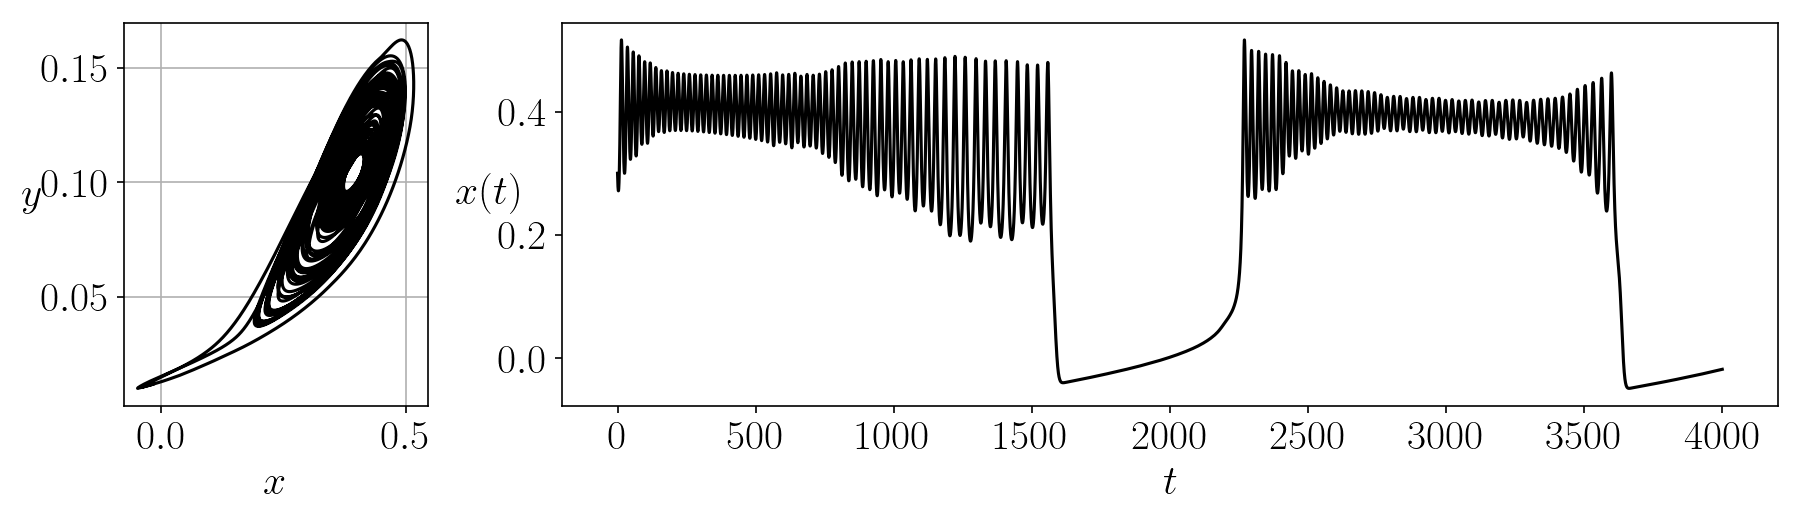

In [9]:
sz=20
%matplotlib notebook

fig, axs = plt.subplots(1, 2, figsize=(12, 3.5), gridspec_kw={'width_ratios': [1, 4]})


axs[0].plot(x1_sol[5000:], y1_sol[5000:], 'k-', ms =1, rasterized=True)
# axs[0, 0].plot(phi_x1, phi_y1, 'bo', ms =5, rasterized=True)
axs[0].set_xlabel('$x$', size=sz)
axs[0].set_ylabel('$y$', rotation = False, size=sz)
axs[0].tick_params(axis='both', labelsize=sz)
axs[0].grid()

axs[1].plot(tt, x1_sol, 'k-', ms=1, rasterized=True)
axs[1].set_ylabel('$x(t)$', size=sz, rotation=False)
axs[1].set_xlabel('$t$', size=sz)
axs[1].tick_params(axis='both', labelsize=sz)
plt.tight_layout()

## Gap junction coupling

In [3]:
## function to plot phase portraits, time series, and compute every metric for gap junction coupling
def bif_gap_pp(theta):
    ## parameter values
    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005
    
    ## define the dynamical system to simulate
    def system(t, vars):
        x1, y1, I1, x2, y2, I2= vars
        dx1dt = x1**2 * (1 - x1) - y1 + I1+ theta*(x2-x1)
        dy1dt = A * np.exp(alpha * x1) - gamma * y1
        dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
        dx2dt = x2**2 * (1 - x2) - y2 + I2 + theta*(x1-x2)
        dy2dt = A * np.exp(alpha * x2) - gamma * y2
        dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)

        return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt]

    ## Initial conditions
    x1_0 = np.random.uniform(low=-1, high=1)
    y1_0 = 0.1
    I1_0 = 0.019

    x2_0 = np.random.uniform(low=-1, high=1)
    y2_0 = .1
    I2_0 = 0.022
    print(x1_0, x2_0)


    initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0]


    ## Time span for the solution
    t_span = (0, 4000)
    t_eval = np.linspace(t_span[0], t_span[1], 50000)

    ## Solving the system of differential equations
    solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

    ## Extract solutions
    x1_sol = solution.y[0]
    y1_sol = solution.y[1]
    I1_sol = solution.y[2]

    x2_sol = solution.y[3]
    y2_sol = solution.y[4]
    I2_sol = solution.y[5]


    tt = solution.t
    
    ## cross-correlation coeff
    phi_x1 = np.array(x1_sol[5000:])
    phi_x2 = np.array(x2_sol[5000:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)
    
    Numerator = np.mean(x1_tilde*x2_tilde)
    Denominator = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    cc = Numerator/Denominator
    print("cc =",cc)
    
    ## Kuramoto order parameter
    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Indt = np.abs(1/2*(Ind1+Ind2))
    Kuram = np.mean(Indt)
    print("Kuram =",Kuram)
    
    
    ## 0-1 test
    ## New time span for performing the 0-1 test
    t_spanKK = (0, 4000)
    t_evalKK = np.linspace(t_spanKK[0], t_spanKK[1], 10000)
    
    ## New solution
    solutionKK = solve_ivp(system, t_spanKK, initial_conditions, t_eval=t_evalKK, method='RK45')

    x1_solKK = solutionKK.y[0]
    y1_solKK = solutionKK.y[1]
    I1_solKK = solutionKK.y[2]

    x2_solKK = solutionKK.y[3]
    y2_solKK = solutionKK.y[4]
    I2_solKK = solutionKK.y[5]


    ttKK = solutionKK.t
    
    ## Functions for 0-1 test 
    ## These have been converted from https://github.com/amitg7/01ChaosTest.jl by Anjana S Nair for her Masters project!
    def pq(phi, c):
        imax = len(phi)
        p = np.zeros(imax)
        q = np.zeros(imax)
        p[0] = phi[0] * np.cos(c)
        q[0] = phi[0] * np.sin(c)
        for i in range(1, imax):
            p[i] = p[i-1] + phi[i-1]*np.cos(c * (i-1))
            q[i] = q[i-1] + phi[i-1]*np.sin(c * (i-1))
        return p,q
    
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    c = 1.1
    ncut2 = 20

    phi_x1 = x1_solKK[8000:]
    phi_y1 = y1_solKK[8000:]
    phi_x2 = x2_solKK[8000:]
    phi_y2 = y2_solKK[8000:]
    print("length = ", len(phi_x1))
    
    p_x1, q_x1 = pq(phi_x1, c)
    p_x2, q_x2 = pq(phi_x2, c)
    
    if theta <0:
        KK1 = correlation_method(phi_x1, ncut2)
        KK2 = correlation_method(phi_x2, ncut2)
    else:
        KK1 = regression_method(phi_x1, ncut2)
        KK2 = regression_method(phi_x2, ncut2)
    print("KK =",(KK1+KK2)/2)
    
    return x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.sampen(x1_sol), nd.sampen(x2_sol), p_x1, q_x1, p_x2, q_x2

0.4345792349954316 -0.5684217607316435
cc = 0.9999972620173715
Kuram = 0.9998322930122311
length =  2000
KK = 0.15983645701066188


<IPython.core.display.Javascript object>


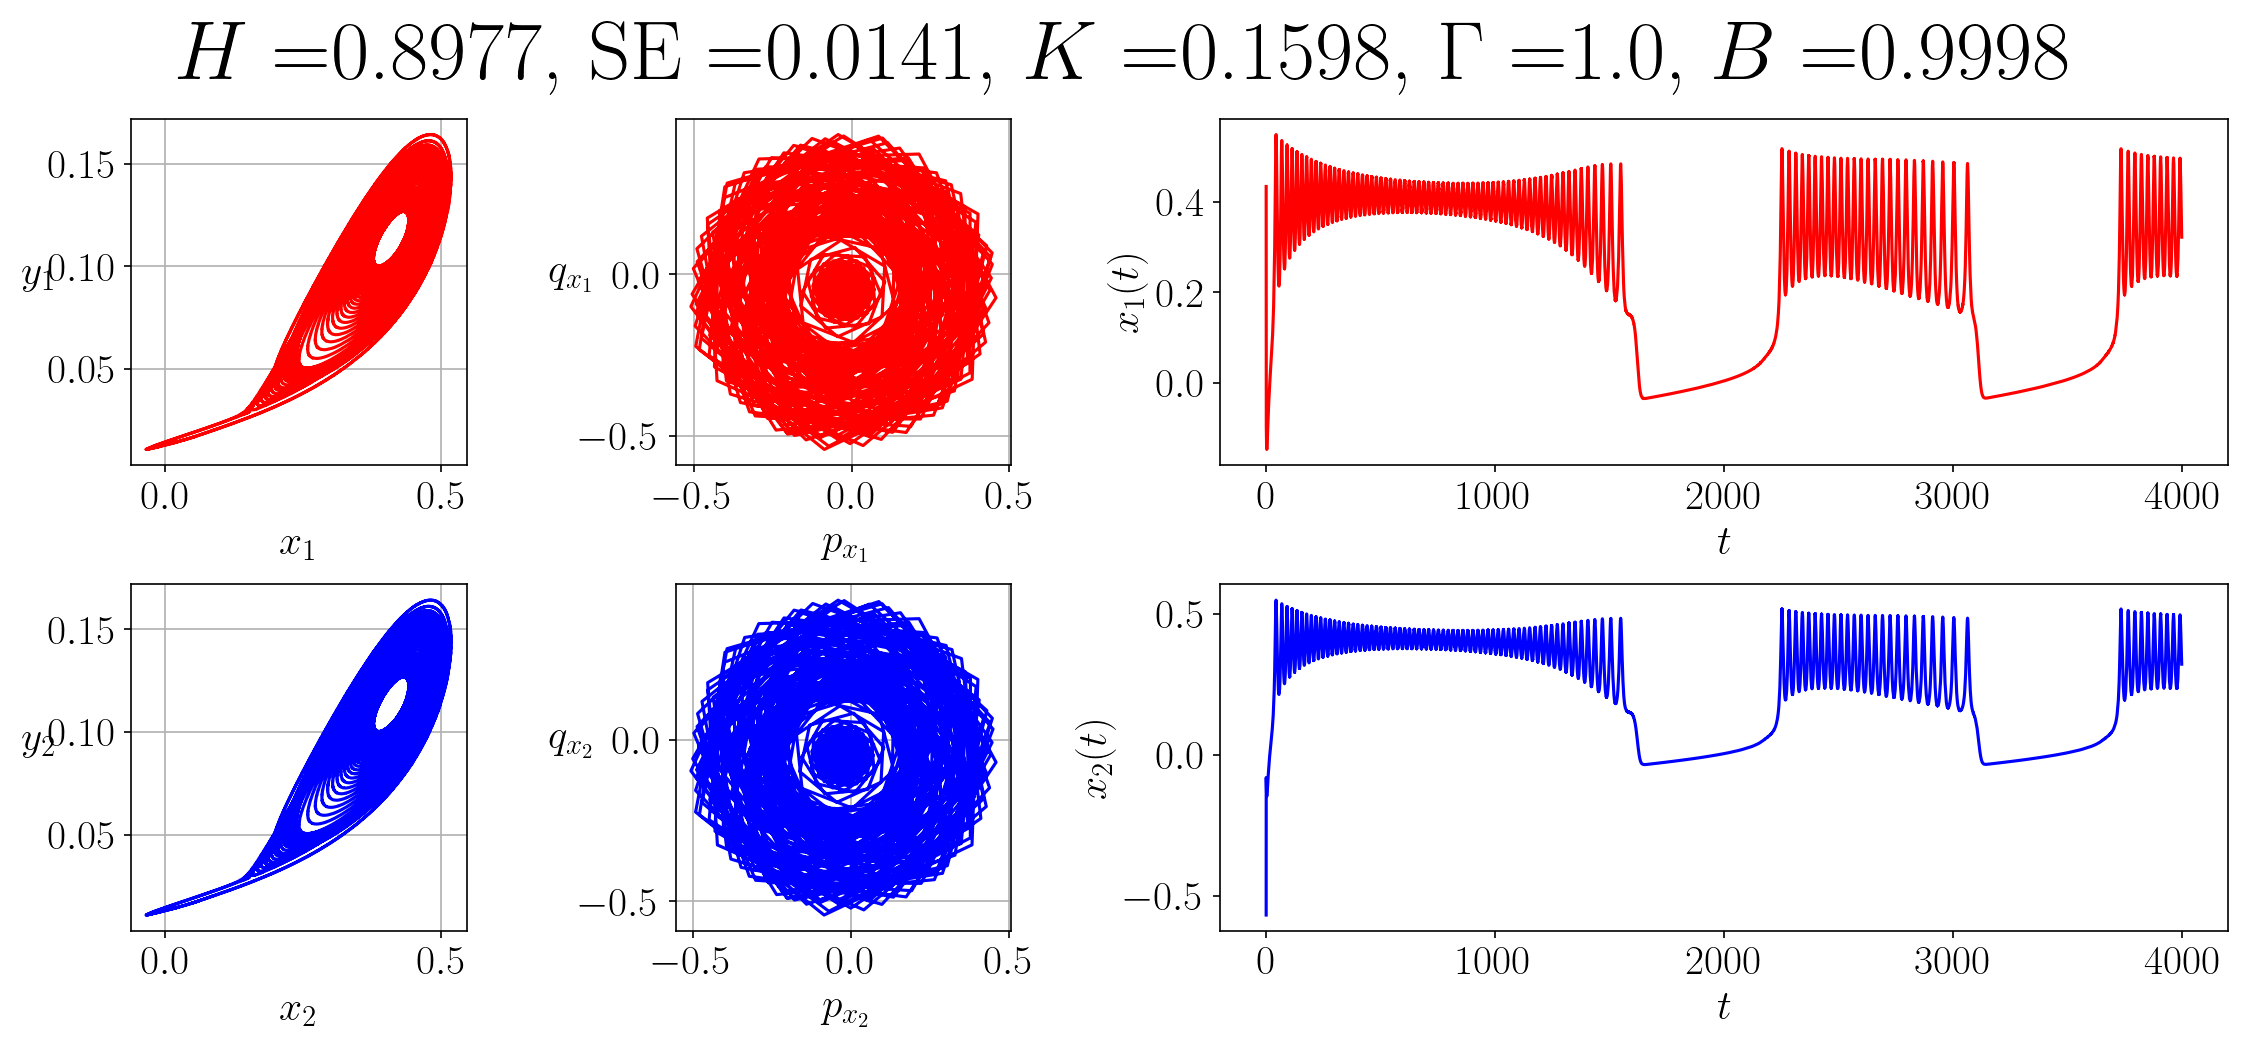

In [4]:
# theta = -10
# theta = -5
# theta = -1
# theta = 1
# theta = 5
theta = 10


x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2, p_x1, q_x1, p_x2, q_x2 = bif_gap_pp(theta)

sz=20
%matplotlib notebook

fig, axs = plt.subplots(2, 3, figsize=(15, 7), gridspec_kw={'width_ratios': [1, 1, 3]})
fig.tight_layout()
plt.suptitle(
    "$H=$" + str(round((h1 + h2) / 2, 4)) +
    ", $\mathrm{SE}=$" + str(round((se1 + se2) / 2, 4)) +
    ", $K=$" + str(round((KK1 + KK2) / 2, 4)) +
    ", $\Gamma=$" + str(round(cc, 4)) +
    ", $B=$" + str(round(Kuram, 4)),
    size=sz +20
)

axs[0, 0].plot(x1_sol[5000:], y1_sol[5000:], 'r-', ms =1, rasterized=True)
# axs[0, 0].plot(phi_x1, phi_y1, 'bo', ms =5, rasterized=True)
axs[0, 0].set_xlabel('$x_1$', size=sz)
axs[0, 0].set_ylabel('$y_1$', rotation = False, size=sz)
axs[0, 0].tick_params(axis='both', labelsize=sz)
axs[0, 0].grid()

axs[1, 0].plot(x2_sol[5000:], y2_sol[5000:], 'b-', ms =1,  rasterized=True)
# axs[1, 0].plot(phi_x2, phi_y2, 'ro', ms =5,  rasterized=True)
axs[1, 0].set_xlabel('$x_2$', size=sz)
axs[1, 0].set_ylabel('$y_2$', rotation=False, size=sz)
axs[1, 0].tick_params(axis='both', labelsize=sz)
axs[1, 0].grid()

axs[0, 1].plot(p_x1, q_x1, 'r-', ms =1, rasterized=True)
axs[0, 1].set_xlabel('$p_{x_1}$', size=sz)
axs[0, 1].set_ylabel('$q_{x_1}$', rotation = False, size=sz)
axs[0, 1].tick_params(axis='both', labelsize=sz)
axs[0, 1].grid()

axs[1, 1].plot(p_x2, q_x2, 'b-', ms =1, rasterized=True)
axs[1, 1].set_xlabel('$p_{x_2}$', size=sz)
axs[1, 1].set_ylabel('$q_{x_2}$', rotation = False, size=sz)
axs[1, 1].tick_params(axis='both', labelsize=sz)
axs[1, 1].grid()

axs[0, 2].plot(tt, x1_sol, 'r-', ms=1, rasterized=True)
axs[0, 2].set_ylabel('$x_1(t)$', size=sz)
axs[0, 2].set_xlabel('$t$', size=sz)
axs[0, 2].tick_params(axis='both', labelsize=sz)

axs[1, 2].plot(tt, x2_sol, 'b-', ms=1, rasterized=True)
axs[1, 2].set_ylabel('$x_2(t)$', size=sz)
axs[1, 2].set_xlabel('$t$', size=sz)
axs[1, 2].tick_params(axis='both', labelsize=sz)

plt.tight_layout()

In [5]:
## Function for the bifurcation parameter plot
def bif_gap(theta):
    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005

    def system(t, vars):
        x1, y1, I1, x2, y2, I2= vars
        dx1dt = x1**2 * (1 - x1) - y1 + I1+ theta*(x2-x1)
        dy1dt = A * np.exp(alpha * x1) - gamma * y1
        dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
        dx2dt = x2**2 * (1 - x2) - y2 + I2 + theta*(x1-x2)
        dy2dt = A * np.exp(alpha * x2) - gamma * y2
        dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)

        return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt]

    x1_0 = np.random.uniform(low=-1, high=1)
    y1_0 = 0.1
    I1_0 = 0.019

    x2_0 = np.random.uniform(low=-1, high=1)
    y2_0 = .1
    I2_0 = 0.022
    print(x1_0, x2_0)


    initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0]


    t_span = (0, 4000)  # from t=0 to t=10
    t_eval = np.linspace(t_span[0], t_span[1], 50000)

    
    solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

    x1_sol = solution.y[0]
    y1_sol = solution.y[1]
    I1_sol = solution.y[2]

    x2_sol = solution.y[3]
    y2_sol = solution.y[4]
    I2_sol = solution.y[5]


    tt = solution.t

    phi_x1 = np.array(x1_sol[5000:])
    phi_x2 = np.array(x2_sol[5000:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)
    
    Numerator = np.mean(x1_tilde*x2_tilde)
    Denominator = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    cc = Numerator/Denominator
    print("cc =",cc)
    
    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Indt = np.abs(1/2*(Ind1+Ind2))
    Kuram = np.mean(Indt)
    print("Kuram =",Kuram)
    
    

    t_spanKK = (0, 4000)
    t_evalKK = np.linspace(t_spanKK[0], t_spanKK[1], 10000)

    solutionKK = solve_ivp(system, t_spanKK, initial_conditions, t_eval=t_evalKK, method='RK45')

    x1_solKK = solutionKK.y[0]
    y1_solKK = solutionKK.y[1]
    I1_solKK = solutionKK.y[2]

    x2_solKK = solutionKK.y[3]
    y2_solKK = solutionKK.y[4]
    I2_solKK = solutionKK.y[5]


    ttKK = solutionKK.t
    
    def pq(phi, c):
        imax = len(phi)
        p = np.zeros(imax)
        q = np.zeros(imax)
        p[0] = phi[0] * np.cos(c)
        q[0] = phi[0] * np.sin(c)
        for i in range(1, imax):
            p[i] = p[i-1] + phi[i-1]*np.cos(c * (i-1))
            q[i] = q[i-1] + phi[i-1]*np.sin(c * (i-1))
        return p,q
    
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    c = 1.1
    ncut2 = 20

    phi_x1 = x1_solKK[8000:]
    phi_y1 = y1_solKK[8000:]
    phi_x2 = x2_solKK[8000:]
    phi_y2 = y2_solKK[8000:]
    print("length = ", len(phi_x1))
    
    if theta <0:
        KK1 = correlation_method(phi_x1, ncut2)
        KK2 = correlation_method(phi_x2, ncut2)
    else:
        KK1 = regression_method(phi_x1, ncut2)
        KK2 = regression_method(phi_x2, ncut2)
    print("KK =",(KK1+KK2)/2)
    
    return x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.sampen(x1_sol), nd.sampen(x2_sol)

In [ ]:
## Code to create the data files

SS = np.linspace(-10, 10, 50)

count = 1
HH=[]
SE=[]
KKTest = []
CC = []
Kuramoto = []
for theta in SS:
    print("count = "+str(count))
    x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2 = bif_gap(theta)
    HH+=[(h1+h2)/2, ]
    SE+=[(se1+se2)/2, ]
    CC+=[cc, ]
    KKTest+=[(KK1+KK2)/2, ]
    Kuramoto+=[Kuram, ]
    
    print("H=", (h1+h2)/2)
    print("SE=", (se1+se2)/2)
    print(" ")

    count+=1
    
df = pd.DataFrame({
    'theta': SS,
    'H': HH,
    'SE': SE,
    'CC': CC,
    'KK': KKTest,
    'Kuramoto': Kuramoto
})

## Create the data file
df.to_csv('data_gap.csv', index=False)

In [6]:
## Load the data file
dfGap = pd.read_csv('data_gap.csv')
dfGap

theta         H        SE        CC        KK  Kuramoto
0  -10.000000  0.075755  0.048965 -0.230950  0.974990  0.945371
1   -9.591837  0.068889  0.049600 -0.247435  0.973426  0.942219
2   -9.183673  0.070847  0.050584 -0.264226  0.974289  0.939167
3   -8.775510  0.056358  0.051361 -0.279553  0.974688  0.936165
4   -8.367347  0.065453  0.052763 -0.297540  0.976047  0.931959
5   -7.959184  0.067204  0.053522 -0.314207  0.979496  0.929517
6   -7.551020  0.073805  0.054817 -0.332759  0.980077  0.924822
7   -7.142857  0.068470  0.056010 -0.350708  0.981813  0.920045
8   -6.734694  0.074268  0.057403 -0.369906  0.982537  0.914924
9   -6.326531  0.075233  0.058941 -0.391002  0.983551  0.909313
10  -5.918367  0.083993  0.061830 -0.412140  0.982661  0.901997
11  -5.510204  0.086928  0.064623 -0.432834  0.982238  0.895319
12  -5.102041  0.088085  0.068565 -0.459491  0.979680  0.885796
13  -4.693878  0.090124  0.072917 -0.483525  0.975518  0.875428
14  -4.285714  0.088048  0.079621 -0.510293  0.972630  0.864797
15  -3.877551  0.073100  0.088338 -0.541188  0.971513  0.849629
16  -3.469388  0.078077  0.094849 -0.572404  0.968396  0.832087
17  -3.061224  0.073655  0.100209 -0.610033  0.958296  0.809464
18  -2.653061  0.064560  0.100412 -0.649992  0.939595  0.782760
19  -2.244898  0.066140  0.101566 -0.699652  0.848631  0.741990
20  -1.836735  0.143384  0.096027 -0.712262  0.725436  0.732971
21  -1.428571  0.121554  0.093772 -0.727539  0.407197  0.741209
22  -1.020408  0.185859  0.092587 -0.745289  0.333936  0.780202
23  -0.612245  0.483013  0.072652 -0.760369  0.161598  0.855394
24  -0.204082  0.183292  0.096668 -0.690536  0.359335  0.966093
25   0.204082  0.891629  0.010691  0.999983  0.145366  0.989647
26   0.612245  0.892388  0.014892  0.999997  0.169467  0.997597
27   1.020408  0.883665  0.013887  0.999997  0.151055  0.998539
28   1.428571  0.882593  0.014241  0.999997  0.159978  0.998967
29   1.836735  0.882094  0.013722  0.999997  0.148481  0.999244
30   2.244898  0.895802  0.014263  0.999997  0.158727  0.999269
31   2.653061  0.882532  0.014138  0.999997  0.158804  0.999422
32   3.061224  0.882515  0.014348  0.999997  0.159365  0.999449
33   3.469388  0.881757  0.014595  0.999997  0.163701  0.999581
34   3.877551  0.882037  0.014393  0.999997  0.159324  0.999573
35   4.285714  0.895550  0.014067  0.999997  0.154991  0.999641
36   4.693878  0.883112  0.014358  0.999997  0.158810  0.999644
37   5.102041  0.884104  0.014709  0.999997  0.162948  0.999700
38   5.510204  0.881558  0.014071  0.999997  0.154359  0.999741
39   5.918367  0.881144  0.014003  0.999997  0.154191  0.999760
40   6.326531  0.881196  0.014029  0.999997  0.154140  0.999738
41   6.734694  0.895283  0.014029  0.999997  0.154108  0.999738
42   7.142857  0.895300  0.013991  0.999997  0.154130  0.999760
43   7.551020  0.882215  0.014076  0.999997  0.156229  0.999777
44   7.959184  0.877133  0.011112  0.999997  0.122266  0.999800
45   8.367347  0.897791  0.014096  0.999997  0.159616  0.999797
46   8.775510  0.875080  0.010776  0.999997  0.138413  0.999818
47   9.183673  0.883091  0.014098  0.999997  0.159746  0.999831
48   9.591837  0.877144  0.012377  0.999997  0.148784  0.999840
49  10.000000  0.875466  0.012808  0.999997  0.156256  0.999840

<IPython.core.display.Javascript object>


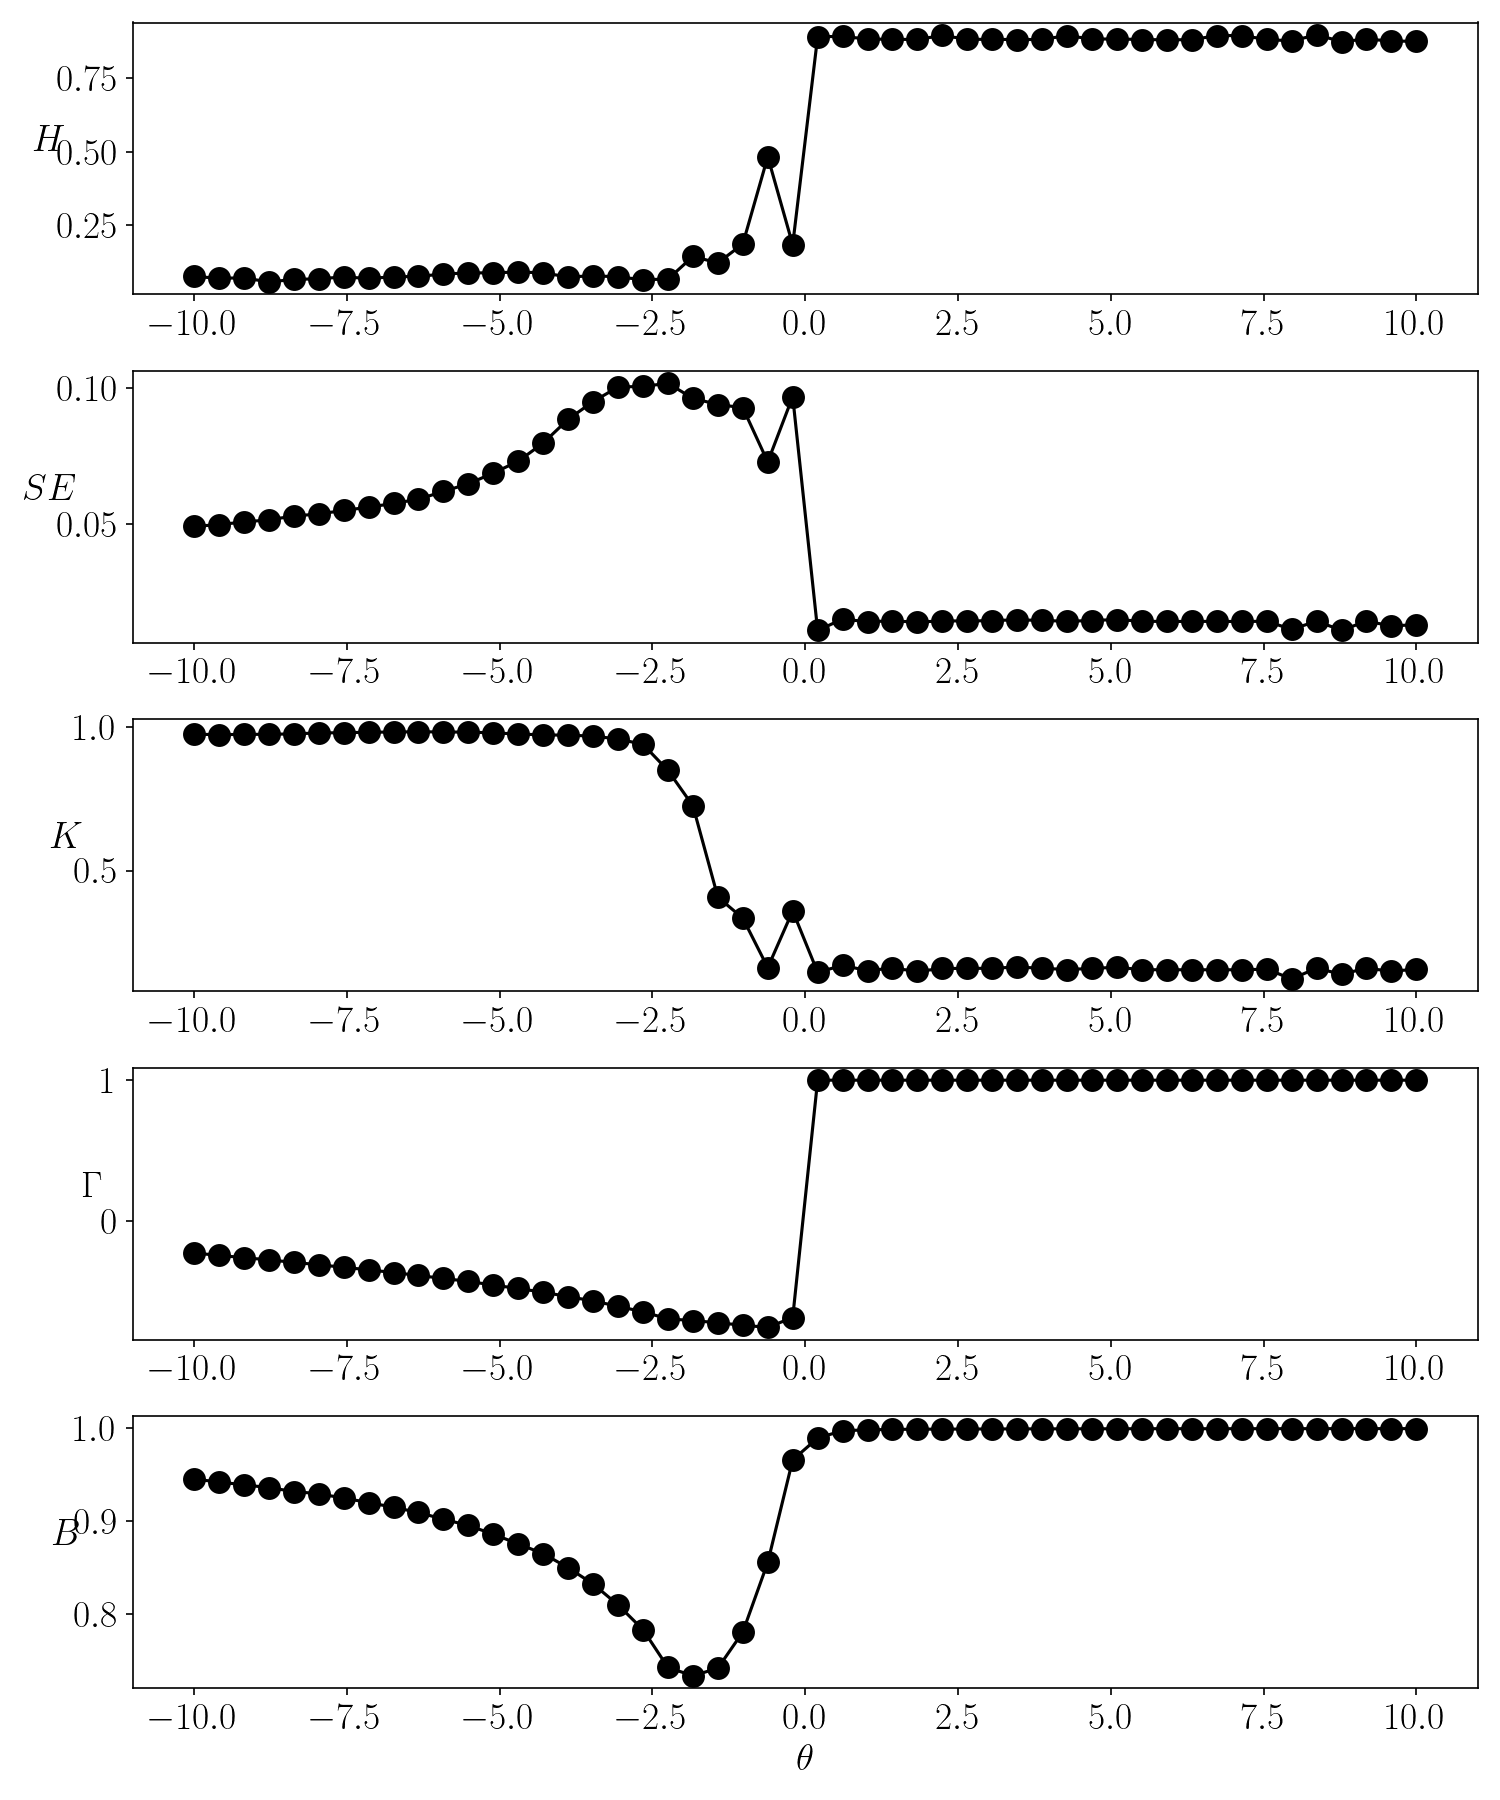

In [7]:
sz=18
%matplotlib notebook
matplotlib.rc('xtick', labelsize=sz)
matplotlib.rc('ytick', labelsize=sz)

SS = np.linspace(-10, 10, 50)

fig, axs = plt.subplots(5,1, figsize=(10, 12))

axs[0].set_ylabel('$H$',rotation=False, fontsize=sz)
axs[1].set_ylabel('$SE$',rotation=False, fontsize=sz)
axs[2].set_ylabel('$K$',rotation=False, fontsize=sz)
axs[3].set_ylabel('$\\Gamma$',rotation=False, fontsize=sz)
axs[4].set_ylabel('$B$',rotation=False, fontsize=sz)
axs[4].set_xlabel('$\\theta$', fontsize=sz)

HH = dfGap['H']
SE = dfGap['SE']
KKTest = dfGap['KK']
CC = dfGap['CC']
Kuramoto = dfGap['Kuramoto']


axs[0].plot(SS, HH, 'ko-', ms=10)
axs[1].plot(SS, SE, 'ko-', ms=10)
axs[2].plot(SS, KKTest, 'ko-', ms=10)
axs[3].plot(SS, CC, 'ko-', ms=10)
axs[4].plot(SS, Kuramoto, 'ko-', ms=10)

plt.tight_layout()


## Thermally sensitive gap junction coupling

In [11]:
## For plotting phase portraits, time series, and evaluating the metrics:

def twoD_bif_temp_pp(theta, Temp):
    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005

    rho =1.3
    T_ref = 20

    def Arr(x):
        return rho**(x - T_ref)/10

    def system(t, vars):
        x1, y1, I1, x2, y2, I2= vars
        dx1dt = x1**2 * (1 - x1) - y1 + I1+ theta*Arr(Temp)*(x2-x1)
        dy1dt = A * np.exp(alpha * x1) - gamma * y1
        dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
        dx2dt = x2**2 * (1 - x2) - y2 + I2 + theta*Arr(Temp)*(x1-x2)
        dy2dt = A * np.exp(alpha * x2) - gamma * y2
        dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)

        return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt]

    x1_0 = np.random.uniform(low=-1, high=1)
    y1_0 = 0.1
    I1_0 = 0.019

    x2_0 = np.random.uniform(low=-1, high=1)
    y2_0 = .1
    I2_0 = 0.022
    print(x1_0, x2_0)


    initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0]


    t_span = (0, 4000)
    t_eval = np.linspace(t_span[0], t_span[1], 50000)


    solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

    x1_sol = solution.y[0]
    y1_sol = solution.y[1]
    I1_sol = solution.y[2]

    x2_sol = solution.y[3]
    y2_sol = solution.y[4]
    I2_sol = solution.y[5]

    tt = solution.t

    phi_x1 = np.array(x1_sol[5000:])
    phi_x2 = np.array(x2_sol[5000:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)

    Numerator = np.mean(x1_tilde*x2_tilde)
    Denominator = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    cc = Numerator/Denominator
    print("cc =",cc)

    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Indt = np.abs(1/2*(Ind1+Ind2))
    Kuram = np.mean(Indt)
    print("Kuram =",Kuram)
    

    t_spanKK = (0, 4000)
    t_evalKK = np.linspace(t_spanKK[0], t_spanKK[1], 10000)

    solutionKK = solve_ivp(system, t_spanKK, initial_conditions, t_eval=t_evalKK, method='RK45')

    x1_solKK = solutionKK.y[0]
    y1_solKK = solutionKK.y[1]
    I1_solKK = solutionKK.y[2]

    x2_solKK = solutionKK.y[3]
    y2_solKK = solutionKK.y[4]
    I2_solKK = solutionKK.y[5]


    ttKK = solutionKK.t
    
    def pq(phi, c):
        imax = len(phi)
        p = np.zeros(imax)
        q = np.zeros(imax)
        p[0] = phi[0] * np.cos(c)
        q[0] = phi[0] * np.sin(c)
        for i in range(1, imax):
            p[i] = p[i-1] + phi[i-1]*np.cos(c * (i-1))
            q[i] = q[i-1] + phi[i-1]*np.sin(c * (i-1))
        return p,q
    
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    c = 1.1
    ncut2 = 20

    phi_x1 = x1_solKK[8000:]
    phi_y1 = y1_solKK[8000:]
    phi_x2 = x2_solKK[8000:]
    phi_y2 = y2_solKK[8000:]
    
    p_x1, q_x1 = pq(phi_x1, c)
    p_x2, q_x2 = pq(phi_x2, c)
    
    if theta <0:
        KK1 = correlation_method(phi_x1, ncut2)
        KK2 = correlation_method(phi_x2, ncut2)
    else:
        KK1 = regression_method(phi_x1, ncut2)
        KK2 = regression_method(phi_x2, ncut2)
    print("KK =",(KK1+KK2)/2)
    
    return x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.sampen(x1_sol), nd.sampen(x2_sol), p_x1, q_x1, p_x2, q_x2

-0.7382307173023415 0.23535545215714326


C:\Users\ighosh\AppData\Local\Temp/ipykernel_41572/4154237463.py:21: RuntimeWarning: overflow encountered in exp
  dy2dt = A * np.exp(alpha * x2) - gamma * y2
C:\Users\ighosh\AppData\Local\Temp/ipykernel_41572/4154237463.py:18: RuntimeWarning: overflow encountered in exp
  dy1dt = A * np.exp(alpha * x1) - gamma * y1
C:\Users\ighosh\AppData\Local\Temp/ipykernel_41572/4154237463.py:21: RuntimeWarning: invalid value encountered in double_scalars
  dy2dt = A * np.exp(alpha * x2) - gamma * y2


cc = 0.13147266457224663
Kuram = 0.9806559356091058
KK = 0.9784905941369594


<IPython.core.display.Javascript object>


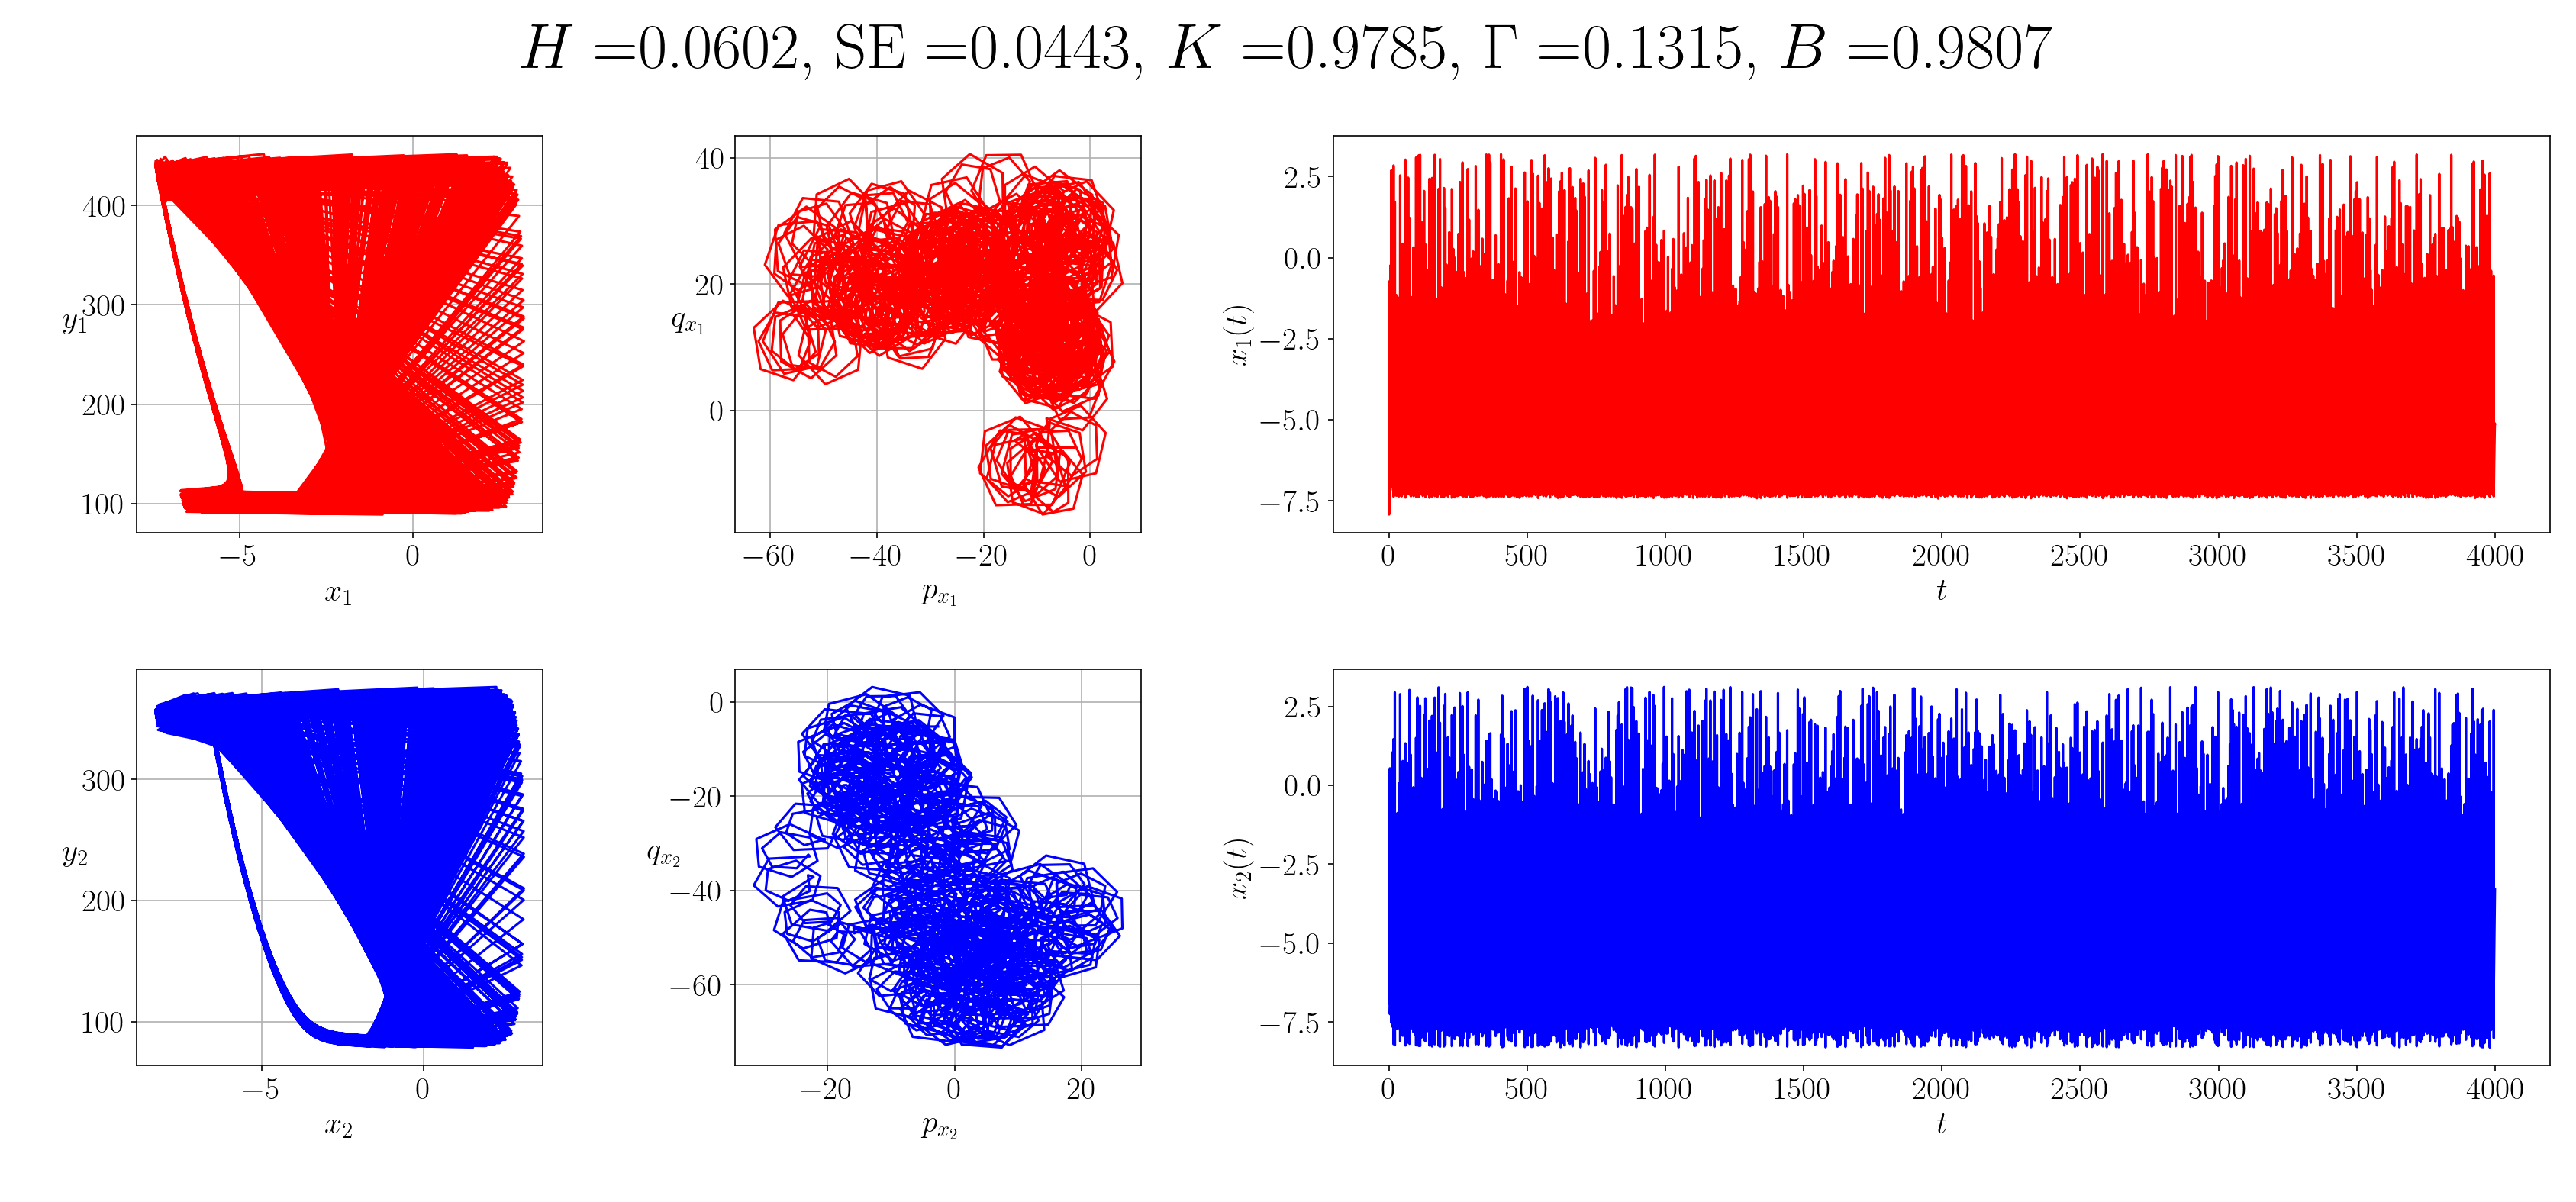

In [12]:
# Temp = 10
Temp =35

theta = -5
# theta = -2
# theta = -0.1
# theta = 0.1
# theta = 2
# theta = 5


x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2, p_x1, q_x1, p_x2, q_x2 = twoD_bif_temp_pp(theta, Temp)

sz=20
%matplotlib notebook

fig, axs = plt.subplots(2, 3, figsize=(15, 7), gridspec_kw={'width_ratios': [1, 1, 3]})
fig.tight_layout()
plt.suptitle(
    "$H=$" + str(round((h1 + h2) / 2, 4)) +
    ", $\mathrm{SE}=$" + str(round((se1 + se2) / 2, 4)) +
    ", $K=$" + str(round((KK1 + KK2) / 2, 4)) +
    ", $\Gamma=$" + str(round(cc, 4)) +
    ", $B=$" + str(round(Kuram, 4)),
    size=sz +20
)

axs[0, 0].plot(x1_sol[5000:], y1_sol[5000:], 'r-', ms =1, rasterized=True)
# axs[0, 0].plot(phi_x1, phi_y1, 'bo', ms =5, rasterized=True)
axs[0, 0].set_xlabel('$x_1$', size=sz)
axs[0, 0].set_ylabel('$y_1$', rotation = False, size=sz)
axs[0, 0].tick_params(axis='both', labelsize=sz)
axs[0, 0].grid()

axs[1, 0].plot(x2_sol[5000:], y2_sol[5000:], 'b-', ms =1,  rasterized=True)
# axs[1, 0].plot(phi_x2, phi_y2, 'ro', ms =5,  rasterized=True)
axs[1, 0].set_xlabel('$x_2$', size=sz)
axs[1, 0].set_ylabel('$y_2$', rotation=False, size=sz)
axs[1, 0].tick_params(axis='both', labelsize=sz)
axs[1, 0].grid()

axs[0, 1].plot(p_x1, q_x1, 'r-', ms =1, rasterized=True)
axs[0, 1].set_xlabel('$p_{x_1}$', size=sz)
axs[0, 1].set_ylabel('$q_{x_1}$', rotation = False, size=sz)
axs[0, 1].tick_params(axis='both', labelsize=sz)
axs[0, 1].grid()

axs[1, 1].plot(p_x2, q_x2, 'b-', ms =1, rasterized=True)
axs[1, 1].set_xlabel('$p_{x_2}$', size=sz)
axs[1, 1].set_ylabel('$q_{x_2}$', rotation = False, size=sz)
axs[1, 1].tick_params(axis='both', labelsize=sz)
axs[1, 1].grid()

axs[0, 2].plot(tt, x1_sol, 'r-', ms=1, rasterized=True)
axs[0, 2].set_ylabel('$x_1(t)$', size=sz)
axs[0, 2].set_xlabel('$t$', size=sz)
axs[0, 2].tick_params(axis='both', labelsize=sz)

axs[1, 2].plot(tt, x2_sol, 'b-', ms=1, rasterized=True)
axs[1, 2].set_ylabel('$x_2(t)$', size=sz)
axs[1, 2].set_xlabel('$t$', size=sz)
axs[1, 2].tick_params(axis='both', labelsize=sz)

plt.tight_layout()

In [13]:
## Function for evaluating the 2D bifurcation plots
def twoD_bif_temp(theta, Temp):
    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005

    rho =1.3
    T_ref = 20

    def Arr(x):
        return rho**(x - T_ref)/10

    def system(t, vars):
        x1, y1, I1, x2, y2, I2= vars
        dx1dt = x1**2 * (1 - x1) - y1 + I1+ theta*Arr(Temp)*(x2-x1)
        dy1dt = A * np.exp(alpha * x1) - gamma * y1
        dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
        dx2dt = x2**2 * (1 - x2) - y2 + I2 + theta*Arr(Temp)*(x1-x2)
        dy2dt = A * np.exp(alpha * x2) - gamma * y2
        dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)

        return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt]

    x1_0 = np.random.uniform(low=-1, high=1)
    y1_0 = 0.1
    I1_0 = 0.019

    x2_0 = np.random.uniform(low=-1, high=1)
    y2_0 = .1
    I2_0 = 0.022
    print(x1_0, x2_0)


    initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0]


    t_span = (0, 4000)
    t_eval = np.linspace(t_span[0], t_span[1], 50000)

    solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')


    x1_sol = solution.y[0]
    y1_sol = solution.y[1]
    I1_sol = solution.y[2]

    x2_sol = solution.y[3]
    y2_sol = solution.y[4]
    I2_sol = solution.y[5]

    tt = solution.t
    
    phi_x1 = np.array(x1_sol[5000:])
    phi_x2 = np.array(x2_sol[5000:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)
    

    Numerator = np.mean(x1_tilde*x2_tilde)
    Denominator = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    cc = Numerator/Denominator
    print("cc =",cc)
    
    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Indt = np.abs(1/2*(Ind1+Ind2))
    Kuram = np.mean(Indt)
    print("Kuram =",Kuram)
    
    
    t_spanKK = (0, 4000) 
    t_evalKK = np.linspace(t_spanKK[0], t_spanKK[1], 10000)

    solutionKK = solve_ivp(system, t_spanKK, initial_conditions, t_eval=t_evalKK, method='RK45')

    x1_solKK = solutionKK.y[0]
    y1_solKK = solutionKK.y[1]
    I1_solKK = solutionKK.y[2]

    x2_solKK = solutionKK.y[3]
    y2_solKK = solutionKK.y[4]
    I2_solKK = solutionKK.y[5]


    ttKK = solutionKK.t
    
    def pq(phi, c):
        imax = len(phi)
        p = np.zeros(imax)
        q = np.zeros(imax)
        p[0] = phi[0] * np.cos(c)
        q[0] = phi[0] * np.sin(c)
        for i in range(1, imax):
            p[i] = p[i-1] + phi[i-1]*np.cos(c * (i-1))
            q[i] = q[i-1] + phi[i-1]*np.sin(c * (i-1))
        return p,q
    
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    c = 1.1
    ncut2 = 20

    phi_x1 = x1_solKK[8000:]
    phi_y1 = y1_solKK[8000:]
    phi_x2 = x2_solKK[8000:]
    phi_y2 = y2_solKK[8000:]
    print("length = ", len(phi_x1))
    
    if theta <0:
        KK1 = correlation_method(phi_x1, ncut2)
        KK2 = correlation_method(phi_x2, ncut2)
    else:
        KK1 = regression_method(phi_x1, ncut2)
        KK2 = regression_method(phi_x2, ncut2)
    print("KK =",(KK1+KK2)/2)
    
    return x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.sampen(x1_sol), nd.sampen(x2_sol)

In [14]:
## Code to generate the data 

THETA = np.linspace(-5, 5, 20)
TEMP = np.linspace(0, 40, 20)

HH = np.zeros((len(THETA), len(TEMP)))
Sampen = np.zeros((len(THETA), len(TEMP)))
KK = np.zeros((len(THETA), len(TEMP)))
crossCor = np.zeros((len(THETA), len(TEMP)))
BB = np.zeros((len(THETA), len(TEMP)))

count = 1
for i in range(len(THETA)):
    for j in range(len(TEMP)):
        print("count=", count)
        print("theta = ", THETA[i])
        print("temp = ", TEMP[j])
        x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2 = twoD_bif_temp(THETA[i], TEMP[j])
        HH[j, i] = (h1+h2)/2
        Sampen[j, i] = (se1+se2)/2
        KK[j, i] = (KK1+KK2)/2
        crossCor[j, i] = cc
        BB[j, i] = Kuram
        
        print("H=", (h1+h2)/2)
        print("SE=", (se1+se2)/2)
        print(" ")
        
        count+=1

HHdf = pd.DataFrame(HH)
Sampendf = pd.DataFrame(Sampen)
KKdf = pd.DataFrame(KK)
crossCordf = pd.DataFrame(crossCor)
BBdf = pd.DataFrame(BB)

HHdf.to_csv('TempHH.csv', index=False, header=False)
Sampendf.to_csv('TempSampen.csv', index=False, header=False)
KKdf.to_csv('TempKK.csv', index=False, header=False)
crossCordf.to_csv('TempcrossCor.csv', index=False, header=False)
BBdf.to_csv('TempBB.csv', index=False, header=False)

<IPython.core.display.Javascript object>


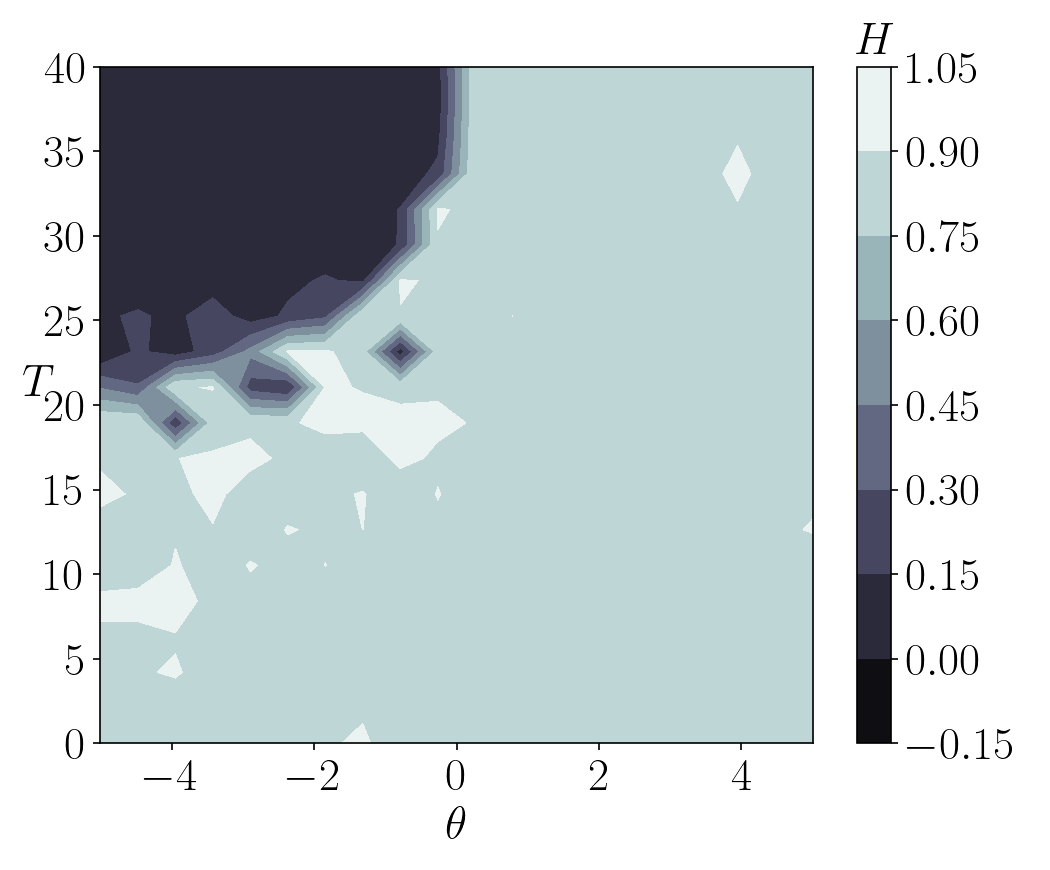

C:\Users\ighosh\AppData\Local\Temp/ipykernel_41572/3274292712.py:17: UserWarning: The following kwargs were not used by contour: 'aspect'
  c = plt.contourf(HH, cmap = 'bone', aspect='auto',


In [15]:
## Plotting
%matplotlib notebook
THETA = np.linspace(-5, 5, 20)
TEMP = np.linspace(0, 40, 20)
sz=22
plt.figure(figsize=(7, 5.8))

HH = pd.read_csv('TempHH.csv', header=None)
Sampen = pd.read_csv('TempSampen.csv', header=None)
KK = pd.read_csv('TempKK.csv', header=None)
crossCor = pd.read_csv('TempcrossCor.csv', header=None)
BB = pd.read_csv('TempBB.csv', header=None)

KK[4][10]=0 # post processed to replace spurious negative value with a zero

norm1 = matplotlib.colors.Normalize(vmin=0,vmax=1)
c = plt.contourf(HH, cmap = 'bone', aspect='auto',
                 extent =[min(THETA), max(THETA), min(TEMP), max(TEMP)]) 
cbar = plt.colorbar(c) 

cbar.ax.set_title("$H$", size=sz)
# cbar.ax.set_title("${\\rm SE}$", size=sz)
# cbar.ax.set_title("$K$", size=sz)
# cbar.ax.set_title("$\Gamma$", size=sz)
# cbar.ax.set_title("$B$", size=sz)

for t in cbar.ax.get_yticklabels():
    t.set_fontsize(sz)
plt.xlabel("$\\theta$", size=sz)
plt.ylabel("$T$", size=sz, rotation=False)
plt.xticks(fontsize=sz)
plt.yticks(fontsize=sz)

plt.tight_layout()


## Chemical coupling

In [16]:
def bif_chem_pp(theta):
    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005
    vs = 2
    lamb = 10
    q = -0.25

    def system(t, vars):
        x1, y1, I1, x2, y2, I2= vars
        dx1dt = x1**2 * (1 - x1) - y1 + I1
        dy1dt = A * np.exp(alpha * x1) - gamma * y1
        dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
        dx2dt = x2**2 * (1 - x2) - y2 + I2 + theta*(vs-x2)/(1+np.exp(-lamb*(x1-q)))
        dy2dt = A * np.exp(alpha * x2) - gamma * y2
        dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)

        return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt]

    x1_0 = np.random.uniform(low=-1, high=1)
    y1_0 = 0.1
    I1_0 = 0.019

    x2_0 = np.random.uniform(low=-1, high=1)
    y2_0 = .1
    I2_0 = 0.022
    print(x1_0, x2_0)


    initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0]

    t_span = (0, 4000)
    t_eval = np.linspace(t_span[0], t_span[1], 50000)

    solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

    x1_sol = solution.y[0]
    y1_sol = solution.y[1]
    I1_sol = solution.y[2]

    x2_sol = solution.y[3]
    y2_sol = solution.y[4]
    I2_sol = solution.y[5]


    tt = solution.t

    phi_x1 = np.array(x1_sol[5000:])
    phi_x2 = np.array(x2_sol[5000:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)
    
    Numerator = np.mean(x1_tilde*x2_tilde)
    Denominator = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    cc = Numerator/Denominator
    print("cc =",cc)

    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Indt = np.abs(1/2*(Ind1+Ind2))
    Kuram = np.mean(Indt)
    print("Kuram =",Kuram)
    
    t_spanKK = (0, 4000)
    t_evalKK = np.linspace(t_spanKK[0], t_spanKK[1], 10000)

    solutionKK = solve_ivp(system, t_spanKK, initial_conditions, t_eval=t_evalKK, method='RK45')

    x1_solKK = solutionKK.y[0]
    y1_solKK = solutionKK.y[1]
    I1_solKK = solutionKK.y[2]

    x2_solKK = solutionKK.y[3]
    y2_solKK = solutionKK.y[4]
    I2_solKK = solutionKK.y[5]


    ttKK = solutionKK.t
    
    def pq(phi, c):
        imax = len(phi)
        p = np.zeros(imax)
        q = np.zeros(imax)
        p[0] = phi[0] * np.cos(c)
        q[0] = phi[0] * np.sin(c)
        for i in range(1, imax):
            p[i] = p[i-1] + phi[i-1]*np.cos(c * (i-1))
            q[i] = q[i-1] + phi[i-1]*np.sin(c * (i-1))
        return p,q
    
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    c = 1.1
    ncut2 = 20

    phi_x1 = x1_solKK[8000:]
    phi_y1 = y1_solKK[8000:]
    phi_x2 = x2_solKK[8000:]
    phi_y2 = y2_solKK[8000:]
    print("length = ", len(phi_x1))
    
    p_x1, q_x1 = pq(phi_x1, c)
    p_x2, q_x2 = pq(phi_x2, c)
    
    if theta <0:
        KK1 = correlation_method(phi_x1, ncut2)
        KK2 = correlation_method(phi_x2, ncut2)
    else:
        KK1 = regression_method(phi_x1, ncut2)
        KK2 = regression_method(phi_x2, ncut2)
    print("KK =",(KK1+KK2)/2)
    
    return x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.sampen(x1_sol), nd.sampen(x2_sol), p_x1, q_x1, p_x2, q_x2

-0.6285863442930302 -0.6157097884498008
cc = 0.22894889061167528


C:\Users\ighosh\AppData\Local\Temp/ipykernel_41572/865375372.py:15: RuntimeWarning: overflow encountered in exp
  dx2dt = x2**2 * (1 - x2) - y2 + I2 + theta*(vs-x2)/(1+np.exp(-lamb*(x1-q)))


Kuram = 0.9624228339572829
length =  2000
KK = 0.1264387163361329


<IPython.core.display.Javascript object>


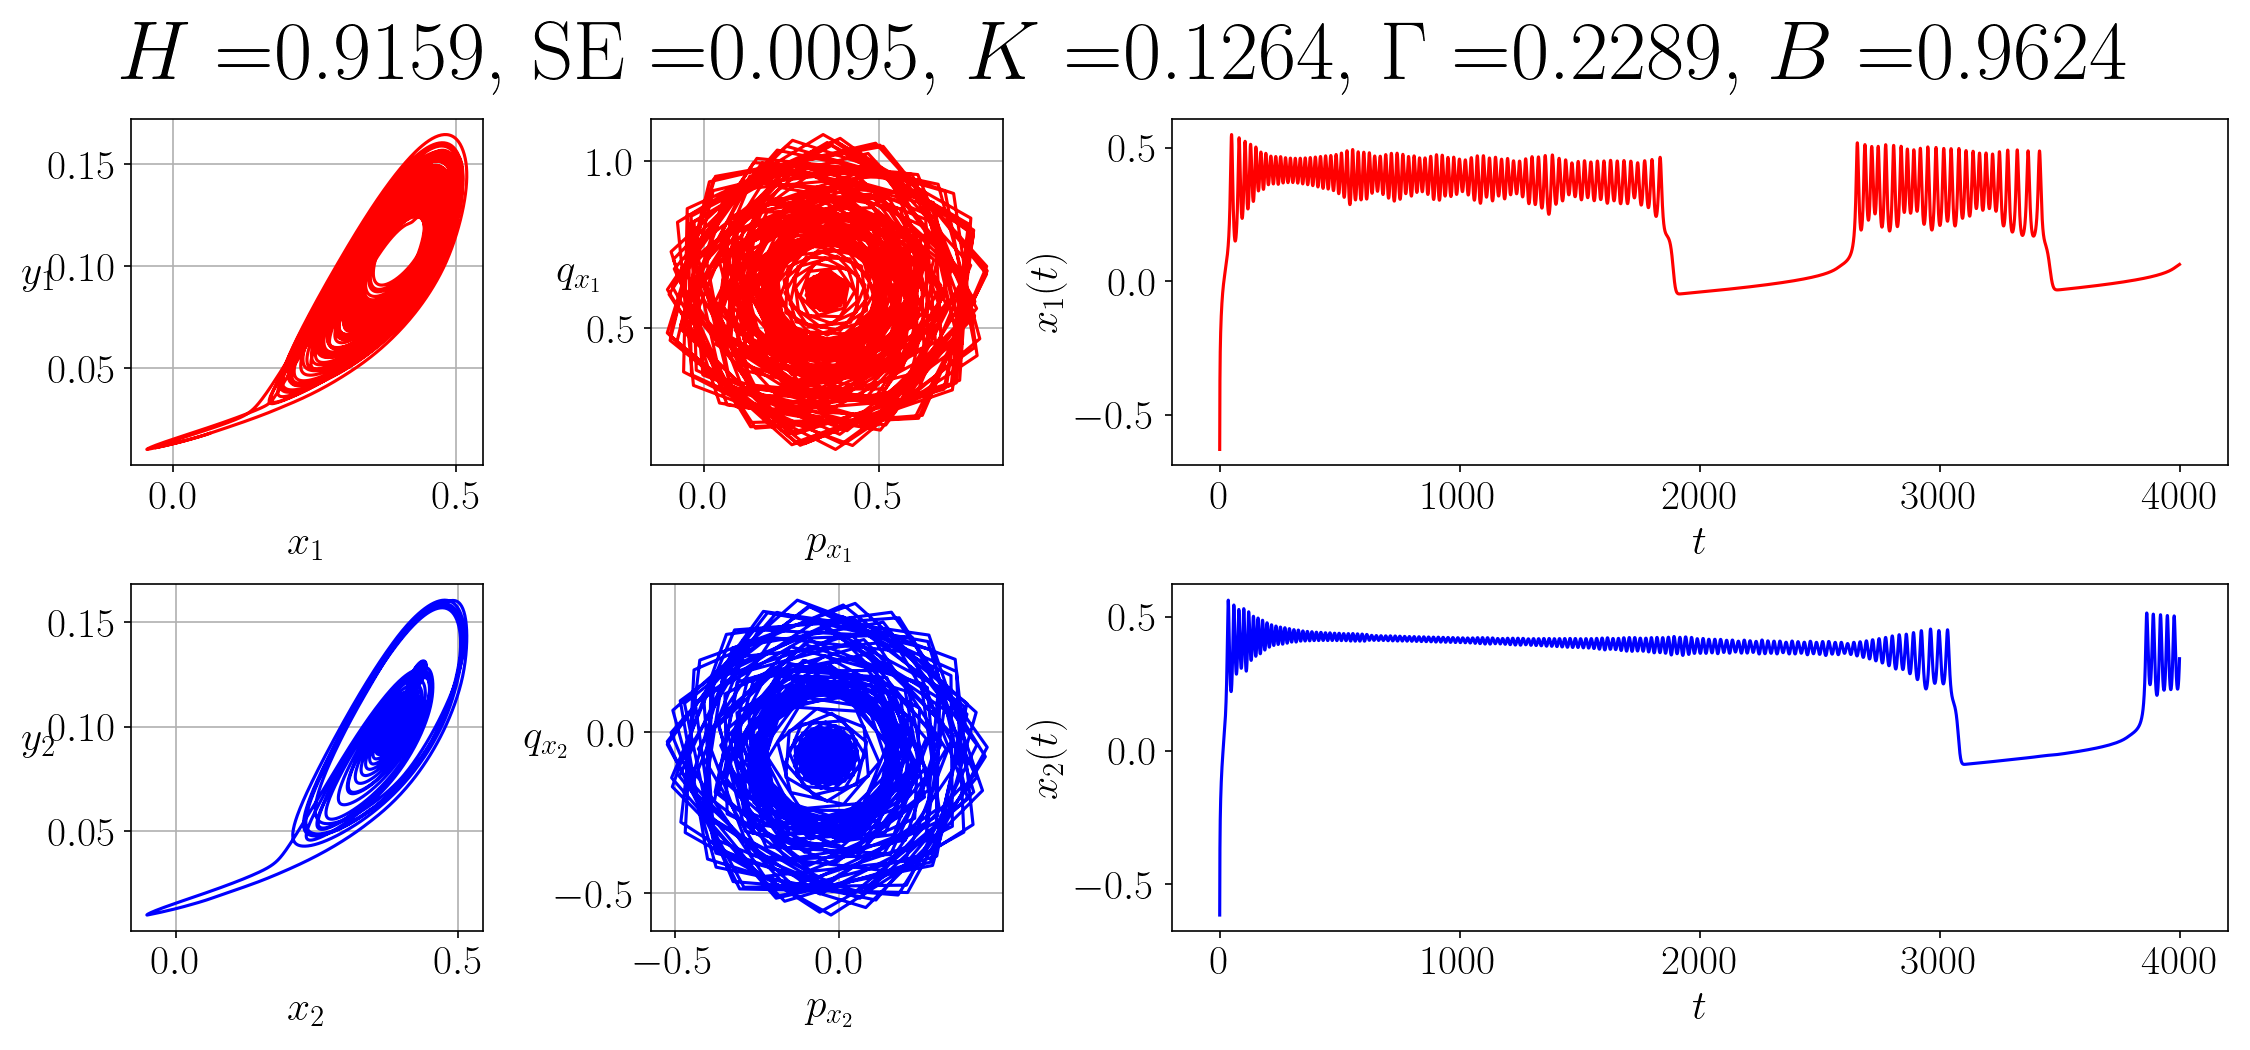

In [17]:
# theta = -0.005
# theta = -0.001
theta = 0.001
# theta = 0.01
# theta = 0.05
# theta =0.1


x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2, p_x1, q_x1, p_x2, q_x2 = bif_chem_pp(theta)

# phi_x1, phi_y1, phi_x2, phi_y2, KK1, se1, KK2, se2, kuram = [0.1, 0.2], [0.1, 0.2], [.1, .65], [0.1, 0.8], 1, 1, 1, 1, 1

sz=20
%matplotlib notebook

fig, axs = plt.subplots(2, 3, figsize=(15, 7), gridspec_kw={'width_ratios': [1, 1, 3]})
fig.tight_layout()
plt.suptitle(
    "$H=$" + str(round((h1 + h2) / 2, 4)) +
    ", $\mathrm{SE}=$" + str(round((se1 + se2) / 2, 4)) +
    ", $K=$" + str(round((KK1 + KK2) / 2, 4)) +
    ", $\Gamma=$" + str(round(cc, 4)) +
    ", $B=$" + str(round(Kuram, 4)),
    size=sz +20
)

axs[0, 0].plot(x1_sol[5000:], y1_sol[5000:], 'r-', ms =1, rasterized=True)
# axs[0, 0].plot(phi_x1, phi_y1, 'bo', ms =5, rasterized=True)
axs[0, 0].set_xlabel('$x_1$', size=sz)
axs[0, 0].set_ylabel('$y_1$', rotation = False, size=sz)
axs[0, 0].tick_params(axis='both', labelsize=sz)
axs[0, 0].grid()

axs[1, 0].plot(x2_sol[5000:], y2_sol[5000:], 'b-', ms =1,  rasterized=True)
# axs[1, 0].plot(phi_x2, phi_y2, 'ro', ms =5,  rasterized=True)
axs[1, 0].set_xlabel('$x_2$', size=sz)
axs[1, 0].set_ylabel('$y_2$', rotation=False, size=sz)
axs[1, 0].tick_params(axis='both', labelsize=sz)
axs[1, 0].grid()

axs[0, 1].plot(p_x1, q_x1, 'r-', ms =1, rasterized=True)
axs[0, 1].set_xlabel('$p_{x_1}$', size=sz)
axs[0, 1].set_ylabel('$q_{x_1}$', rotation = False, size=sz)
axs[0, 1].tick_params(axis='both', labelsize=sz)
axs[0, 1].grid()

axs[1, 1].plot(p_x2, q_x2, 'b-', ms =1, rasterized=True)
axs[1, 1].set_xlabel('$p_{x_2}$', size=sz)
axs[1, 1].set_ylabel('$q_{x_2}$', rotation = False, size=sz)
axs[1, 1].tick_params(axis='both', labelsize=sz)
axs[1, 1].grid()

axs[0, 2].plot(tt, x1_sol, 'r-', ms=1, rasterized=True)
axs[0, 2].set_ylabel('$x_1(t)$', size=sz)
axs[0, 2].set_xlabel('$t$', size=sz)
axs[0, 2].tick_params(axis='both', labelsize=sz)

axs[1, 2].plot(tt, x2_sol, 'b-', ms=1, rasterized=True)
axs[1, 2].set_ylabel('$x_2(t)$', size=sz)
axs[1, 2].set_xlabel('$t$', size=sz)
axs[1, 2].tick_params(axis='both', labelsize=sz)

plt.tight_layout()

In [18]:
def bif_chem(theta):
    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005

    vs = 2
    lamb = 10
    q = -0.25

    def system(t, vars):
        x1, y1, I1, x2, y2, I2= vars
        dx1dt = x1**2 * (1 - x1) - y1 + I1
        dy1dt = A * np.exp(alpha * x1) - gamma * y1
        dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
        dx2dt = x2**2 * (1 - x2) - y2 + I2 + theta*(vs-x2)/(1+np.exp(-lamb*(x1-q)))
        dy2dt = A * np.exp(alpha * x2) - gamma * y2
        dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)

        return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt]

    x1_0 = np.random.uniform(low=-1, high=1)
    y1_0 = 0.1
    I1_0 = 0.019

    x2_0 = np.random.uniform(low=-1, high=1)
    y2_0 = .1
    I2_0 = 0.022
    print(x1_0, x2_0)


    initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0]

    t_span = (0, 4000)
    t_eval = np.linspace(t_span[0], t_span[1], 50000)

    solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

    x1_sol = solution.y[0]
    y1_sol = solution.y[1]
    I1_sol = solution.y[2]

    x2_sol = solution.y[3]
    y2_sol = solution.y[4]
    I2_sol = solution.y[5]


    tt = solution.t

    phi_x1 = np.array(x1_sol[5000:])
    phi_x2 = np.array(x2_sol[5000:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)

    Numerator = np.mean(x1_tilde*x2_tilde)
    Denominator = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    cc = Numerator/Denominator
    print("cc =",cc)

    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Indt = np.abs(1/2*(Ind1+Ind2))
    Kuram = np.mean(Indt)
    print("Kuram =",Kuram)
    
    t_spanKK = (0, 4000)
    t_evalKK = np.linspace(t_spanKK[0], t_spanKK[1], 10000)

    solutionKK = solve_ivp(system, t_spanKK, initial_conditions, t_eval=t_evalKK, method='RK45')

    x1_solKK = solutionKK.y[0]
    y1_solKK = solutionKK.y[1]
    I1_solKK = solutionKK.y[2]

    x2_solKK = solutionKK.y[3]
    y2_solKK = solutionKK.y[4]
    I2_solKK = solutionKK.y[5]


    ttKK = solutionKK.t
    
    def pq(phi, c):
        imax = len(phi)
        p = np.zeros(imax)
        q = np.zeros(imax)
        p[0] = phi[0] * np.cos(c)
        q[0] = phi[0] * np.sin(c)
        for i in range(1, imax):
            p[i] = p[i-1] + phi[i-1]*np.cos(c * (i-1))
            q[i] = q[i-1] + phi[i-1]*np.sin(c * (i-1))
        return p,q
    
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    c = 1.1
    ncut2 = 20

    phi_x1 = x1_solKK[8000:]
    phi_y1 = y1_solKK[8000:]
    phi_x2 = x2_solKK[8000:]
    phi_y2 = y2_solKK[8000:]
    print("length = ", len(phi_x1))
    
    if theta <0:
        KK1 = correlation_method(phi_x1, ncut2)
        KK2 = correlation_method(phi_x2, ncut2)
    else:
        KK1 = regression_method(phi_x1, ncut2)
        KK2 = regression_method(phi_x2, ncut2)
    print("KK =",(KK1+KK2)/2)
    
    return x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.sampen(x1_sol), nd.sampen(x2_sol)

In [ ]:
SS = np.linspace(-0.005, 0.1, 50)

count = 1
HH=[]
SE=[]
KKTest = []
CC = []
Kuramoto = []
for theta in SS:
    print("count = "+str(count))
    x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2 = bif_chem(theta)
    HH+=[(h1+h2)/2, ]
    SE+=[(se1+se2)/2, ]
    CC+=[cc, ]
    KKTest+=[(KK1+KK2)/2, ]
    Kuramoto+=[Kuram, ]
    
    print("H=", (h1+h2)/2)
    print("SE=", (se1+se2)/2)
    print(" ")

    count+=1
    
df = pd.DataFrame({
    'theta': SS,
    'H': HH,
    'SE': SE,
    'CC': CC,
    'KK': KKTest,
    'Kuramoto': Kuramoto
})

df.to_csv('data_chem.csv', index=False)


In [37]:
## Load the data file
dfChem = pd.read_csv('data_chem.csv')
dfChem

theta         H        SE        CC        KK  Kuramoto
0  -0.005000  0.923849  0.005794 -0.492201  0.077783  0.914337
1  -0.002857  0.923023  0.007398  0.286720  0.079136  0.944625
2  -0.000714  0.897507  0.011322 -0.244157  0.059805  0.956951
3   0.001429  0.870133  0.010222  0.347373  0.170795  0.974453
4   0.003571  0.905298  0.017749  0.184921  0.074672  0.975399
5   0.005714  0.920352  0.012433  0.350794  0.072110  0.965590
6   0.007857  0.926875  0.012842  0.463088  0.082797  0.974808
7   0.010000  0.919667  0.012109  0.205651  0.031912  0.975747
8   0.012143  0.909515  0.016743  0.659701  0.086065  0.973903
9   0.014286  0.916078  0.012597  0.340348  0.064809  0.974825
10  0.016429  0.923585  0.013610  0.682584  0.074676  0.974831
11  0.018571  0.926574  0.009722  0.423346  0.087427  0.963719
12  0.020714  0.924078  0.011304  0.444881  0.075506  0.967806
13  0.022857  0.919010  0.011089  0.696994  0.075615  0.973332
14  0.025000  0.911045  0.009576  0.707449  0.076640  0.973210
15  0.027143  0.903602  0.012126  0.698268  0.074406  0.971341
16  0.029286  0.903333  0.011183  0.663473  0.077186  0.972734
17  0.031429  0.576832  0.013367  0.556194  0.052656  0.975534
18  0.033571  0.628664  0.011029  0.698692  0.080757  0.972603
19  0.035714  0.643971  0.012846  0.550989  0.063695  0.982431
20  0.037857  0.622336  0.009761  0.750204  0.063943  0.970739
21  0.040000  0.570243  0.010159  0.695070  0.085420  0.971324
22  0.042143  0.911496  0.020059  0.668875  0.083834  0.971247
23  0.044286  0.603712  0.019209  0.727307  0.076189  0.971352
24  0.046429  0.582825  0.010086  0.766055  0.052520  0.969143
25  0.048571  0.599397  0.011171  0.676297  0.084424  0.971126
26  0.050714  0.616173  0.015280  0.647960  0.057639  0.973414
27  0.052857  0.641660  0.010820  0.723174  0.076547  0.969580
28  0.055000  0.636435  0.012031  0.685515  0.067442  0.972155
29  0.057143  0.608046  0.018303  0.730532  0.087224  0.969356
30  0.059286  0.611147  0.012314  0.779656  0.070007  0.968511
31  0.061429  0.609492  0.012229  0.690936  0.082505  0.968876
32  0.063571  0.572599  0.023351  0.761512  0.075014  0.968270
33  0.065714  0.620690  0.011265  0.719344  0.087095  0.969108
34  0.067857  0.590936  0.023467  0.721524  0.087228  0.968118
35  0.070000  0.596356  0.016591  0.668695  0.075376  0.968772
36  0.072143  0.568801  0.022835  0.747198  0.085388  0.968661
37  0.074286  0.586490  0.015000  0.800767  0.045152  0.966405
38  0.076429  0.589495  0.010453  0.802950  0.057068  0.966520
39  0.078571  0.605723  0.022500  0.762202  0.077789  0.967931
40  0.080714  0.602991  0.025217  0.762537  0.086676  0.967046
41  0.082857  0.598354  0.011114  0.757367  0.088799  0.966951
42  0.085000  0.607778  0.024322  0.765745  0.086511  0.966276
43  0.087143  0.587897  0.011723  0.753650  0.078419  0.967465
44  0.089286  0.594224  0.025385  0.746282  0.081363  0.966892
45  0.091429  0.635597  0.027401  0.800004  0.071531  0.965362
46  0.093571  0.600445  0.011983  0.757272  0.085605  0.966289
47  0.095714  0.615517  0.026855  0.812445  0.059858  0.964466
48  0.097857  0.605050  0.022393  0.812573  0.081276  0.964975
49  0.100000  0.625067  0.012312  0.763455  0.079727  0.965924

<IPython.core.display.Javascript object>


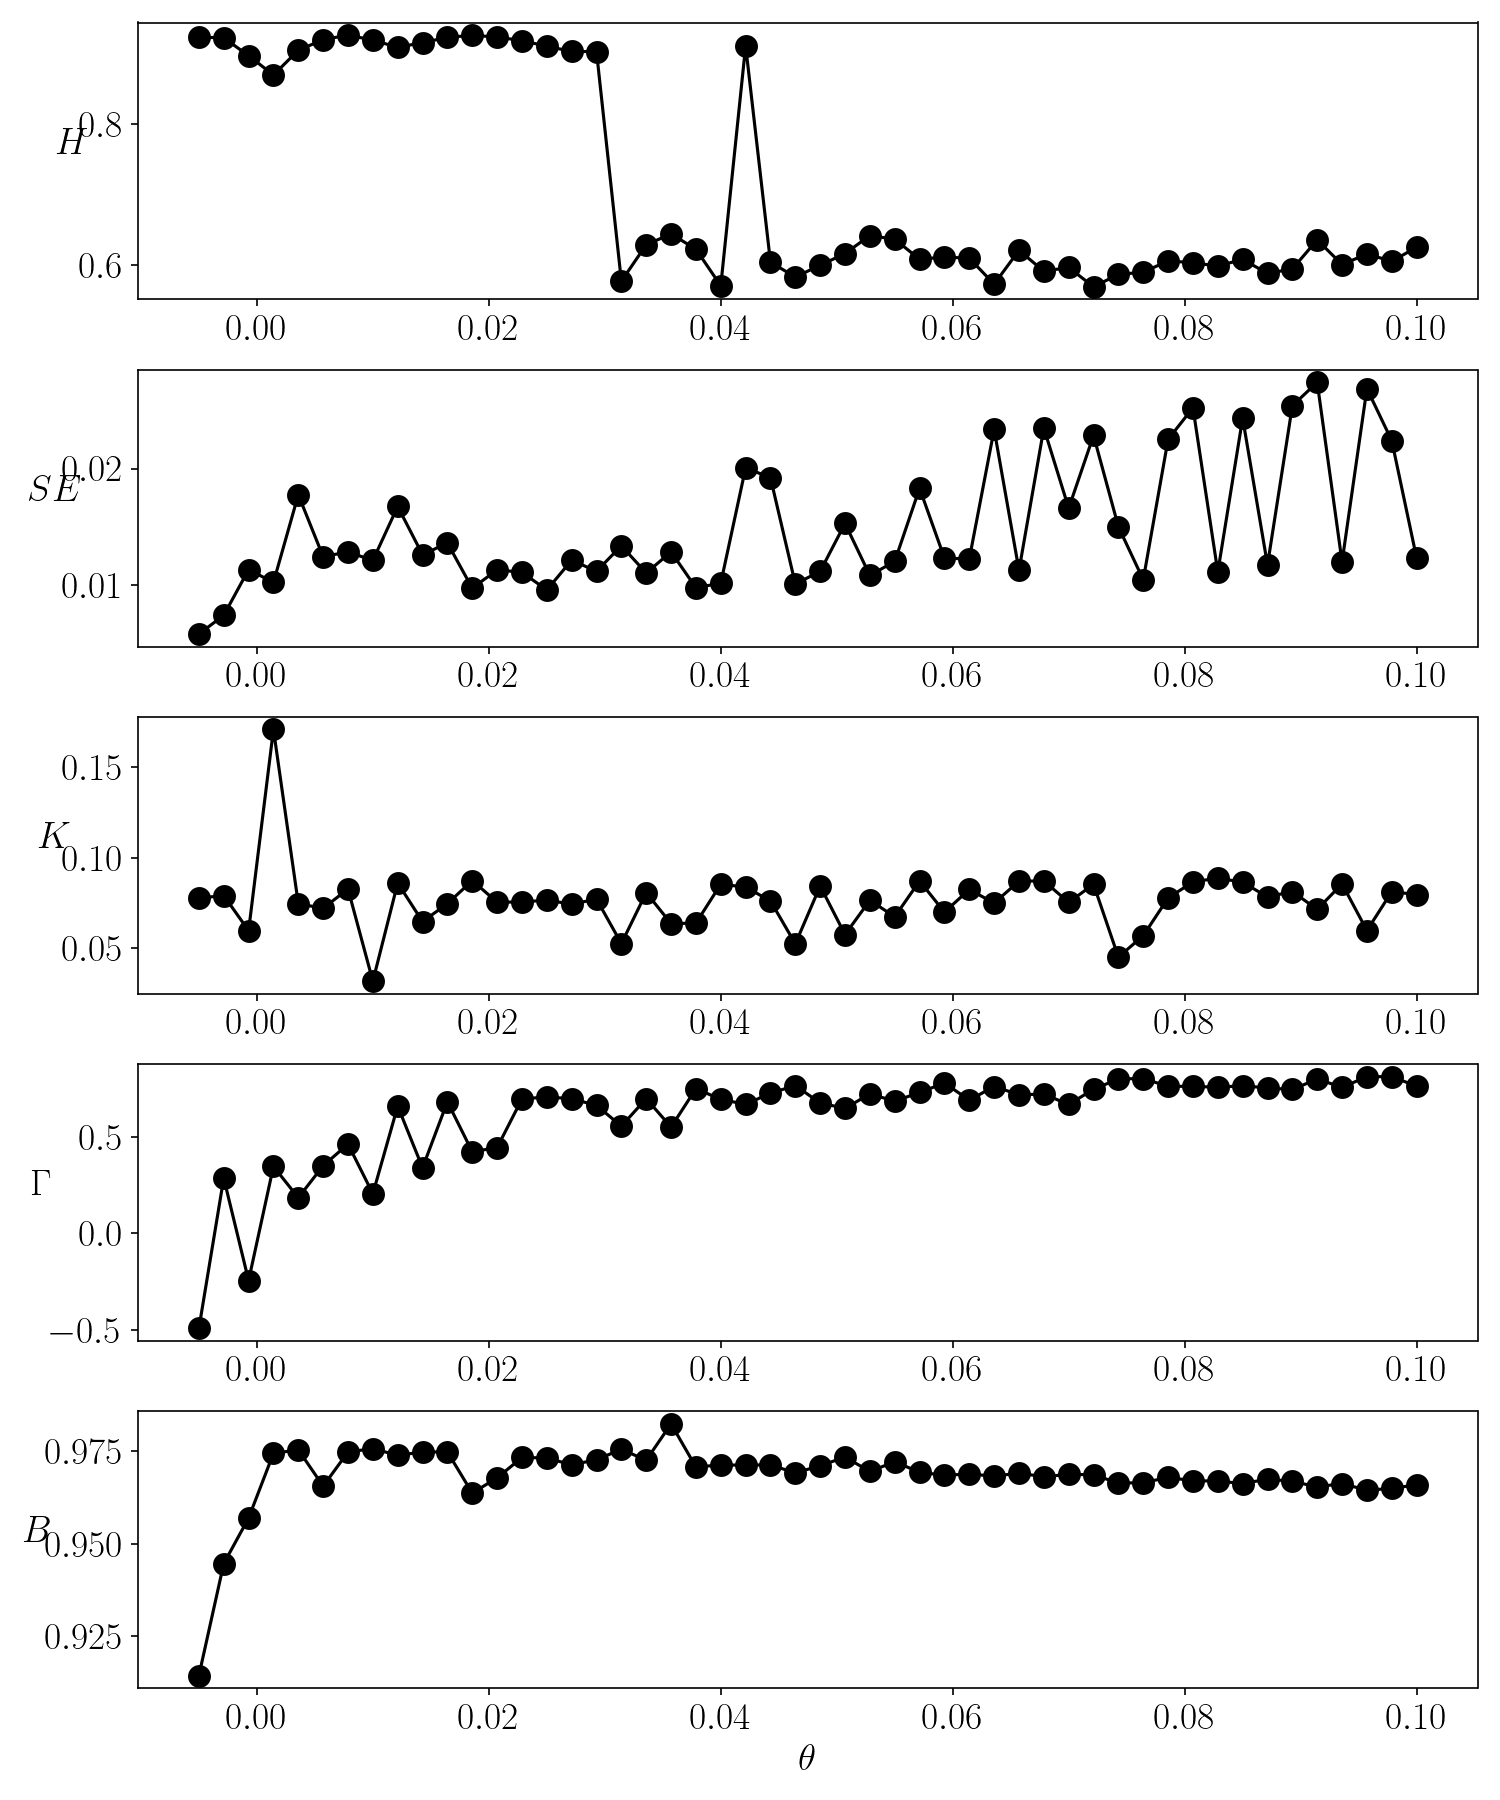

In [38]:
sz=18
%matplotlib notebook
matplotlib.rc('xtick', labelsize=sz)
matplotlib.rc('ytick', labelsize=sz)

SS = np.linspace(-0.005, 0.1, 50)

fig, axs = plt.subplots(5,1, figsize=(10, 12))

axs[0].set_ylabel('$H$',rotation=False, fontsize=sz)
axs[1].set_ylabel('$SE$',rotation=False, fontsize=sz)
axs[2].set_ylabel('$K$',rotation=False, fontsize=sz)
axs[3].set_ylabel('$\\Gamma$',rotation=False, fontsize=sz)
axs[4].set_ylabel('$B$',rotation=False, fontsize=sz)
axs[4].set_xlabel('$\\theta$', fontsize=sz)

HH = dfChem['H']
SE = dfChem['SE']
KKTest = dfChem['KK']
CC = dfChem['CC']
Kuramoto = dfChem['Kuramoto']


axs[0].plot(SS, HH, 'ko-', ms=10)
axs[1].plot(SS, SE, 'ko-', ms=10)
axs[2].plot(SS, KKTest, 'ko-', ms=10)
axs[3].plot(SS, CC, 'ko-', ms=10)
axs[4].plot(SS, Kuramoto, 'ko-', ms=10)

plt.tight_layout()


## Josephson junction coupling

In [21]:
def bif_JJ_pp(theta):
    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005

    beta = 3
    mu = 3
    print("theta=", theta)
    def system(t, vars):
        x1, y1, I1, x2, y2, I2, z= vars
        dx1dt = x1**2 * (1 - x1) - y1 + I1-beta*np.sin(z) + theta*(x2 - x1)
        dy1dt = A * np.exp(alpha * x1) - gamma * y1
        dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
        dx2dt = x2**2 * (1 - x2) - y2 + I2 + beta*np.sin(z) + theta*(x1 - x2)
        dy2dt = A * np.exp(alpha * x2) - gamma * y2
        dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)
        dzdt = mu*(x1-x2)

        return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt, dzdt]

    x1_0 = np.random.uniform(low=-1, high=1)
    y1_0 = 0.1
    I1_0 = 0.018

    x2_0 = np.random.uniform(low=-1, high=1)
    y2_0 = .1
    I2_0 = 0.022

    z_0 = mu*(x1_0 - x2_0)
    print(x1_0, x2_0)


    initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0, z_0]

    t_span = (0, 4000) 
    t_eval = np.linspace(t_span[0], t_span[1], 50000)

    solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

    x1_sol = solution.y[0]
    y1_sol = solution.y[1]
    I1_sol = solution.y[2]

    x2_sol = solution.y[3]
    y2_sol = solution.y[4]
    I2_sol = solution.y[5]


    tt = solution.t

    phi_x1 = np.array(x1_sol[5000:])
    phi_x2 = np.array(x2_sol[5000:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)
    
    Numerator = np.mean(x1_tilde*x2_tilde)
    Denominator = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    cc = Numerator/Denominator
    print("cc =",cc)

    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Indt = np.abs(1/2*(Ind1+Ind2))
    Kuram = np.mean(Indt)
    print("Kuram =",Kuram)
    

    t_spanKK = (0, 4000)
    t_evalKK = np.linspace(t_spanKK[0], t_spanKK[1], 10000)

    solutionKK = solve_ivp(system, t_spanKK, initial_conditions, t_eval=t_evalKK, method='RK45')

    x1_solKK = solutionKK.y[0]
    y1_solKK = solutionKK.y[1]
    I1_solKK = solutionKK.y[2]

    x2_solKK = solutionKK.y[3]
    y2_solKK = solutionKK.y[4]
    I2_solKK = solutionKK.y[5]


    ttKK = solutionKK.t
    
    def pq(phi, c):
        imax = len(phi)
        p = np.zeros(imax)
        q = np.zeros(imax)
        p[0] = phi[0] * np.cos(c)
        q[0] = phi[0] * np.sin(c)
        for i in range(1, imax):
            p[i] = p[i-1] + phi[i-1]*np.cos(c * (i-1))
            q[i] = q[i-1] + phi[i-1]*np.sin(c * (i-1))
        return p,q
    
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    c = 1.1
    ncut2 = 20
    
    phi_x1 = x1_solKK[8000:]
    phi_y1 = y1_solKK[8000:]
    phi_x2 = x2_solKK[8000:]
    phi_y2 = y2_solKK[8000:]
    print("length = ", len(phi_x1))
    
    p_x1, q_x1 = pq(phi_x1, c)
    p_x2, q_x2 = pq(phi_x2, c)
    
    if theta <0:
        KK1 = correlation_method(phi_x1, ncut2)
        KK2 = correlation_method(phi_x2, ncut2)
    else:
        KK1 = regression_method(phi_x1, ncut2)
        KK2 = regression_method(phi_x2, ncut2)
    print("KK =",(KK1+KK2)/2)
    
    return x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.sampen(x1_sol), nd.sampen(x2_sol), p_x1, q_x1, p_x2, q_x2

theta= -1
-0.47795074718483566 0.5970042077928859


C:\Users\ighosh\AppData\Local\Temp/ipykernel_41572/2277620818.py:16: RuntimeWarning: overflow encountered in exp
  dy2dt = A * np.exp(alpha * x2) - gamma * y2
C:\Users\ighosh\AppData\Local\Temp/ipykernel_41572/2277620818.py:13: RuntimeWarning: overflow encountered in exp
  dy1dt = A * np.exp(alpha * x1) - gamma * y1


cc = -0.5848702274368209
Kuram = 0.8545407678250299
length =  2000
KK = 0.9968543547796298


<IPython.core.display.Javascript object>


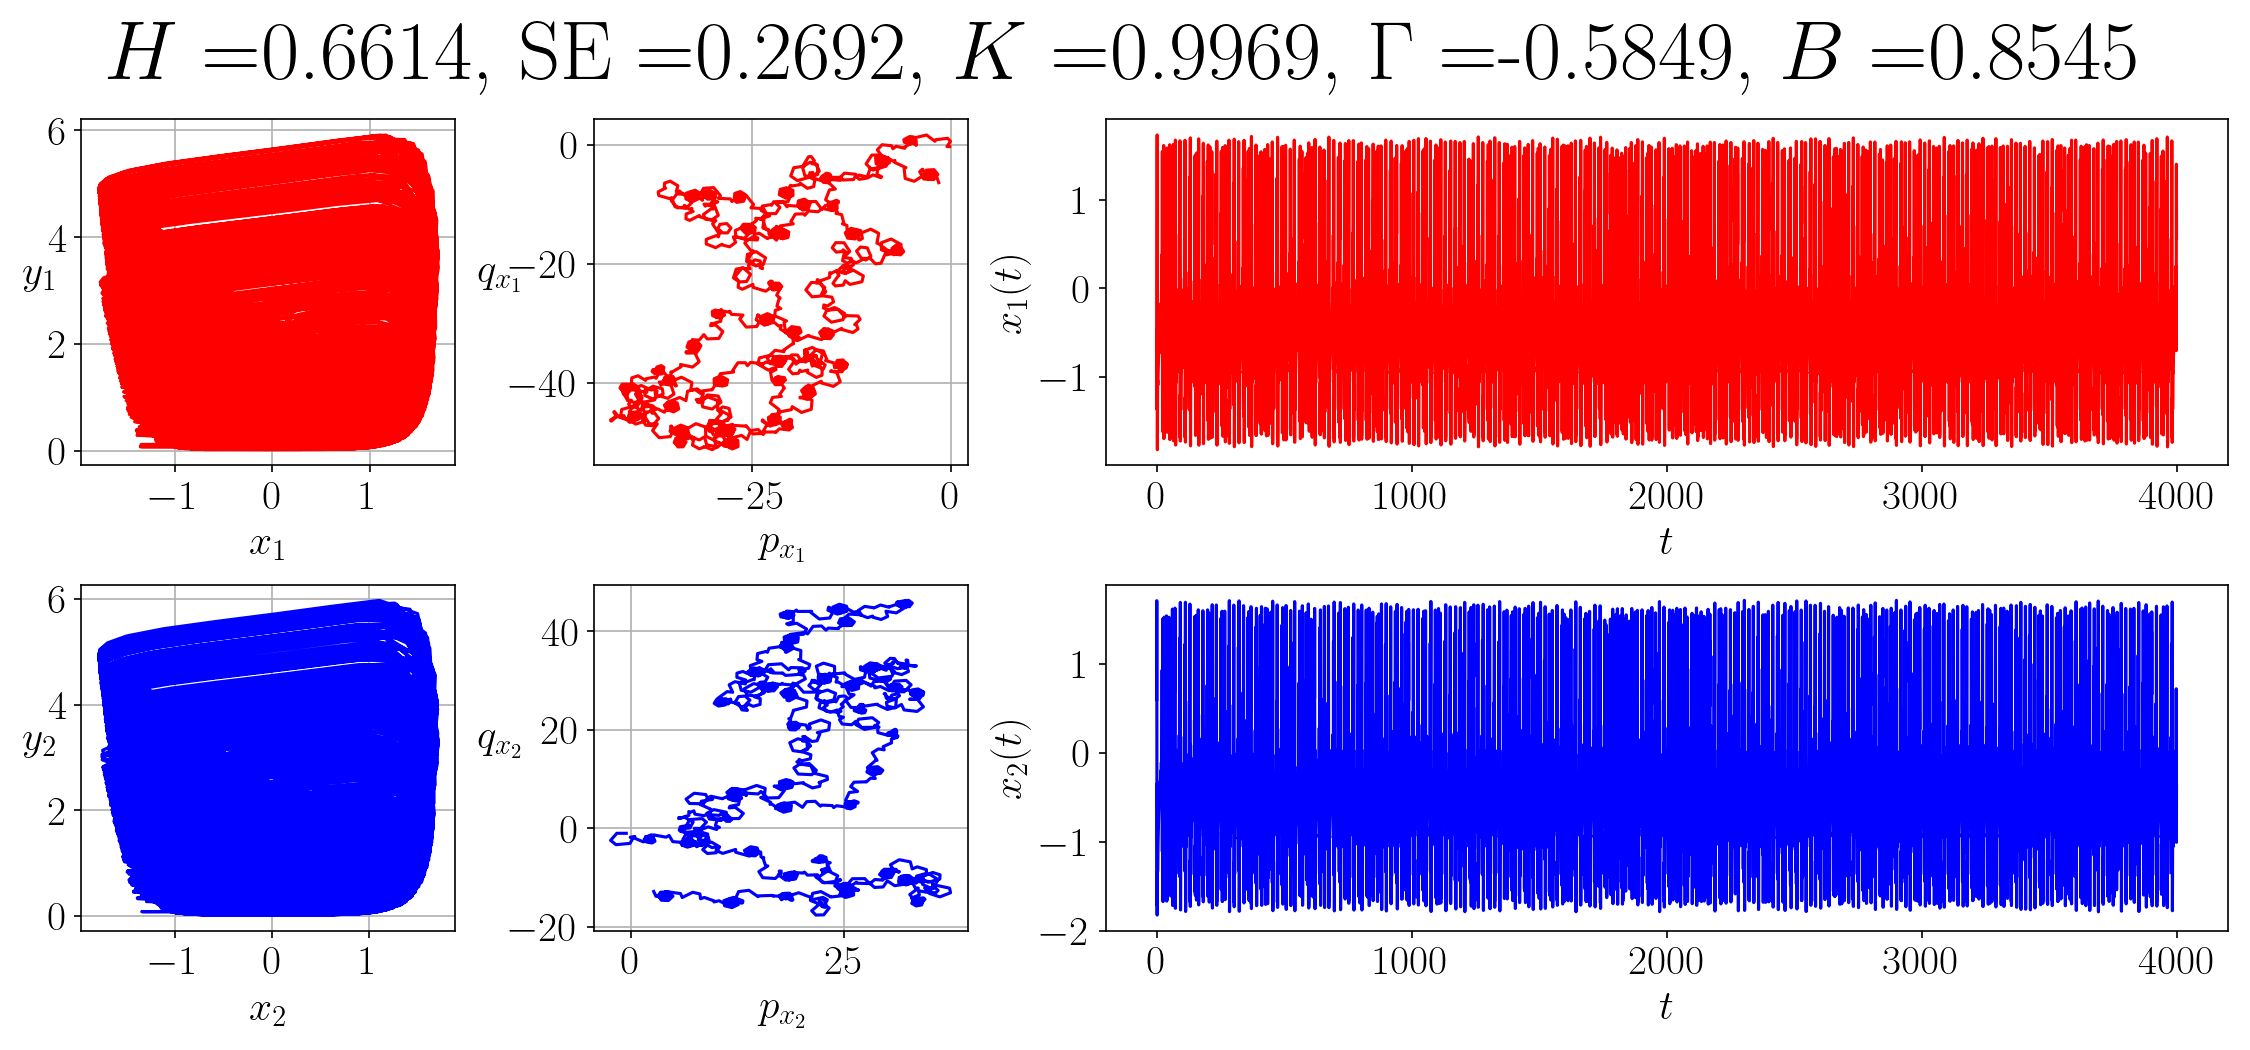

In [22]:
theta = -1
# theta = -.5
# theta = -.1
# theta = .1
# theta = 0.5
# theta =1


x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2, p_x1, q_x1, p_x2, q_x2 = bif_JJ_pp(theta)

sz=20
%matplotlib notebook

fig, axs = plt.subplots(2, 3, figsize=(15, 7), gridspec_kw={'width_ratios': [1, 1, 3]})
fig.tight_layout()
plt.suptitle(
    "$H=$" + str(round((h1 + h2) / 2, 4)) +
    ", $\mathrm{SE}=$" + str(round((se1 + se2) / 2, 4)) +
    ", $K=$" + str(round((KK1 + KK2) / 2, 4)) +
    ", $\Gamma=$" + str(round(cc, 4)) +
    ", $B=$" + str(round(Kuram, 4)),
    size=sz +20
)

axs[0, 0].plot(x1_sol[5000:], y1_sol[5000:], 'r-', ms =1, rasterized=True)
# axs[0, 0].plot(phi_x1, phi_y1, 'bo', ms =5, rasterized=True)
axs[0, 0].set_xlabel('$x_1$', size=sz)
axs[0, 0].set_ylabel('$y_1$', rotation = False, size=sz)
axs[0, 0].tick_params(axis='both', labelsize=sz)
axs[0, 0].grid()

axs[1, 0].plot(x2_sol[5000:], y2_sol[5000:], 'b-', ms =1,  rasterized=True)
# axs[1, 0].plot(phi_x2, phi_y2, 'ro', ms =5,  rasterized=True)
axs[1, 0].set_xlabel('$x_2$', size=sz)
axs[1, 0].set_ylabel('$y_2$', rotation=False, size=sz)
axs[1, 0].tick_params(axis='both', labelsize=sz)
axs[1, 0].grid()

axs[0, 1].plot(p_x1, q_x1, 'r-', ms =1, rasterized=True)
axs[0, 1].set_xlabel('$p_{x_1}$', size=sz)
axs[0, 1].set_ylabel('$q_{x_1}$', rotation = False, size=sz)
axs[0, 1].tick_params(axis='both', labelsize=sz)
axs[0, 1].grid()

axs[1, 1].plot(p_x2, q_x2, 'b-', ms =1, rasterized=True)
axs[1, 1].set_xlabel('$p_{x_2}$', size=sz)
axs[1, 1].set_ylabel('$q_{x_2}$', rotation = False, size=sz)
axs[1, 1].tick_params(axis='both', labelsize=sz)
axs[1, 1].grid()

axs[0, 2].plot(tt, x1_sol, 'r-', ms=1, rasterized=True)
axs[0, 2].set_ylabel('$x_1(t)$', size=sz)
axs[0, 2].set_xlabel('$t$', size=sz)
axs[0, 2].tick_params(axis='both', labelsize=sz)

axs[1, 2].plot(tt, x2_sol, 'b-', ms=1, rasterized=True)
axs[1, 2].set_ylabel('$x_2(t)$', size=sz)
axs[1, 2].set_xlabel('$t$', size=sz)
axs[1, 2].tick_params(axis='both', labelsize=sz)

plt.tight_layout()

In [23]:
def bif_JJ(theta):
    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005

    beta = 3
    mu = 3
    print("theta=", theta)
    
    def system(t, vars):
        x1, y1, I1, x2, y2, I2, z= vars
        dx1dt = x1**2 * (1 - x1) - y1 + I1-beta*np.sin(z) + theta*(x2 - x1)
        dy1dt = A * np.exp(alpha * x1) - gamma * y1
        dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
        dx2dt = x2**2 * (1 - x2) - y2 + I2 + beta*np.sin(z) + theta*(x1 - x2)
        dy2dt = A * np.exp(alpha * x2) - gamma * y2
        dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)
        dzdt = mu*(x1-x2)

        return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt, dzdt]

    x1_0 = np.random.uniform(low=-1, high=1)
    y1_0 = 0.1
    I1_0 = 0.018

    x2_0 = np.random.uniform(low=-1, high=1)
    y2_0 = .1
    I2_0 = 0.022

    z_0 = mu*(x1_0 - x2_0)
    print(x1_0, x2_0)


    initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0, z_0]

    t_span = (0, 4000)
    t_eval = np.linspace(t_span[0], t_span[1], 50000)

    solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

    x1_sol = solution.y[0]
    y1_sol = solution.y[1]
    I1_sol = solution.y[2]

    x2_sol = solution.y[3]
    y2_sol = solution.y[4]
    I2_sol = solution.y[5]


    tt = solution.t
 
    phi_x1 = np.array(x1_sol[5000:])
    phi_x2 = np.array(x2_sol[5000:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)
  
    Numerator = np.mean(x1_tilde*x2_tilde)
    Denominator = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    cc = Numerator/Denominator
    print("cc =",cc)

    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Indt = np.abs(1/2*(Ind1+Ind2))
    Kuram = np.mean(Indt)
    print("Kuram =",Kuram)
    
    
    t_spanKK = (0, 4000) 
    t_evalKK = np.linspace(t_spanKK[0], t_spanKK[1], 10000)

    solutionKK = solve_ivp(system, t_spanKK, initial_conditions, t_eval=t_evalKK, method='RK45')

    x1_solKK = solutionKK.y[0]
    y1_solKK = solutionKK.y[1]
    I1_solKK = solutionKK.y[2]

    x2_solKK = solutionKK.y[3]
    y2_solKK = solutionKK.y[4]
    I2_solKK = solutionKK.y[5]


    ttKK = solutionKK.t
    
    def pq(phi, c):
        imax = len(phi)
        p = np.zeros(imax)
        q = np.zeros(imax)
        p[0] = phi[0] * np.cos(c)
        q[0] = phi[0] * np.sin(c)
        for i in range(1, imax):
            p[i] = p[i-1] + phi[i-1]*np.cos(c * (i-1))
            q[i] = q[i-1] + phi[i-1]*np.sin(c * (i-1))
        return p,q
    
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    c = 1.1
    ncut2 = 20

    phi_x1 = x1_solKK[8000:]
    phi_y1 = y1_solKK[8000:]
    phi_x2 = x2_solKK[8000:]
    phi_y2 = y2_solKK[8000:]
    print("length = ", len(phi_x1))
    
    if theta <0:
        KK1 = correlation_method(phi_x1, ncut2)
        KK2 = correlation_method(phi_x2, ncut2)
    else:
        KK1 = regression_method(phi_x1, ncut2)
        KK2 = regression_method(phi_x2, ncut2)
    print("KK =",(KK1+KK2)/2)
    
    return x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.sampen(x1_sol), nd.sampen(x2_sol)

In [ ]:
SS = np.linspace(-1, 1, 50)

count = 1
HH=[]
SE=[]
KKTest = []
CC = []
Kuramoto = []
for theta in SS:
    print("count = "+str(count))
    x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2 = bif_JJ(theta)
    HH+=[(h1+h2)/2, ]
    SE+=[(se1+se2)/2, ]
    CC+=[cc, ]
    KKTest+=[(KK1+KK2)/2, ]
    Kuramoto+=[Kuram, ]
    
    print("H=", (h1+h2)/2)
    print("SE=", (se1+se2)/2)
    print(" ")

    count+=1
    
df = pd.DataFrame({
    'theta': SS,
    'H': HH,
    'SE': SE,
    'CC': CC,
    'KK': KKTest,
    'Kuramoto': Kuramoto
})

df.to_csv('data_JJ.csv', index=False)

In [35]:
dfJJ = pd.read_csv('data_JJ.csv')
dfJJ

theta         H        SE        CC        KK  Kuramoto
0  -1.000000  0.715412  0.249412 -0.559797  0.997739  0.864507
1  -0.959184  0.669068  0.290079 -0.620625  0.998626  0.844556
2  -0.918367  0.617765  0.363462 -0.703680  0.997074  0.810715
3  -0.877551  0.332506  0.474427 -0.809675  0.993575  0.741725
4  -0.836735  0.296941  0.395087 -0.886237  0.962742  0.666206
5  -0.795918  0.149510  0.339337 -0.914849  0.898199  0.655070
6  -0.755102  0.050548  0.158614 -0.921800  0.333948  0.712729
7  -0.714286  0.033626  0.130768 -0.940928  0.278267  0.695687
8  -0.673469 -0.052990  0.131582 -0.953943  0.340542  0.687539
9  -0.632653 -0.034089  0.135035 -0.962635  0.307188  0.684204
10 -0.591837  0.038619  0.137526 -0.969299  0.209827  0.684359
11 -0.551020  0.021232  0.140762 -0.974883  0.192019  0.685676
12 -0.510204  0.005576  0.146874 -0.979388  0.225991  0.690673
13 -0.469388 -0.010789  0.147982 -0.983014  0.220094  0.694656
14 -0.428571  0.026157  0.154208 -0.986143  0.214195  0.701082
15 -0.387755  0.008161  0.161353 -0.988708  0.184232  0.707507
16 -0.346939  0.024826  0.168289 -0.990847  0.172442  0.715662
17 -0.306122  0.013545  0.172480 -0.992725  0.177593  0.741214
18 -0.265306 -0.015011  0.178446 -0.994249  0.156913  0.774942
19 -0.224490  0.048978  0.184605 -0.995511  0.147821  0.805735
20 -0.183673  0.096121  0.188133 -0.996496  0.143556  0.833101
21 -0.142857  0.007287  0.192483 -0.997336  0.138894  0.858011
22 -0.102041  0.152236  0.199971 -0.998015  0.138266  0.879843
23 -0.061224 -0.064440  0.203635 -0.998595  0.126246  0.898597
24 -0.020408  0.050031  0.208441 -0.999024  0.126428  0.912774
25  0.020408  0.118553  0.217595 -0.999388  0.455887  0.924317
26  0.061224  0.078561  0.223818 -0.999626  0.388445  0.926839
27  0.102041 -0.002248  0.232210 -0.999177  0.309390  0.913805
28  0.142857  0.869110  0.159947  0.411330  0.278641  0.987684
29  0.183673  0.999078  0.080250  0.983258  0.228039  0.999263
30  0.224490  0.884956  0.014667  1.000000  0.165954  0.999851
31  0.265306  0.887989  0.015697  1.000000  0.168844  0.999462
32  0.306122  0.883290  0.014465  1.000000  0.165126  0.999720
33  0.346939  0.885128  0.014968  1.000000  0.165715  0.999705
34  0.387755  0.886235  0.015060  1.000000  0.168422  0.999903
35  0.428571  0.883687  0.014754  1.000000  0.165123  0.999732
36  0.469388  0.883181  0.014501  1.000000  0.165289  0.999753
37  0.510204  0.897861  0.014756  1.000000  0.165123  0.999754
38  0.551020  0.885156  0.014676  1.000000  0.165877  0.999952
39  0.591837  0.885892  0.014873  1.000000  0.165429  0.999766
40  0.632653  0.884331  0.014627  1.000000  0.165180  0.999778
41  0.673469  0.899185  0.014893  1.000000  0.165611  0.999736
42  0.714286  0.885714  0.014799  1.000000  0.165188  0.999742
43  0.755102  0.884027  0.014792  1.000000  0.165198  0.999874
44  0.795918  0.884688  0.014821  1.000000  0.166502  0.999702
45  0.836735  0.885108  0.014641  1.000000  0.165786  0.999979
46  0.877551  0.896498  0.017026  0.999770  0.169896  0.999777
47  0.918367  0.886524  0.014781  1.000000  0.165043  0.999835
48  0.959184  0.884649  0.014653  1.000000  0.165985  0.999971
49  1.000000  0.883836  0.014570  1.000000  0.165157  0.999849

<IPython.core.display.Javascript object>


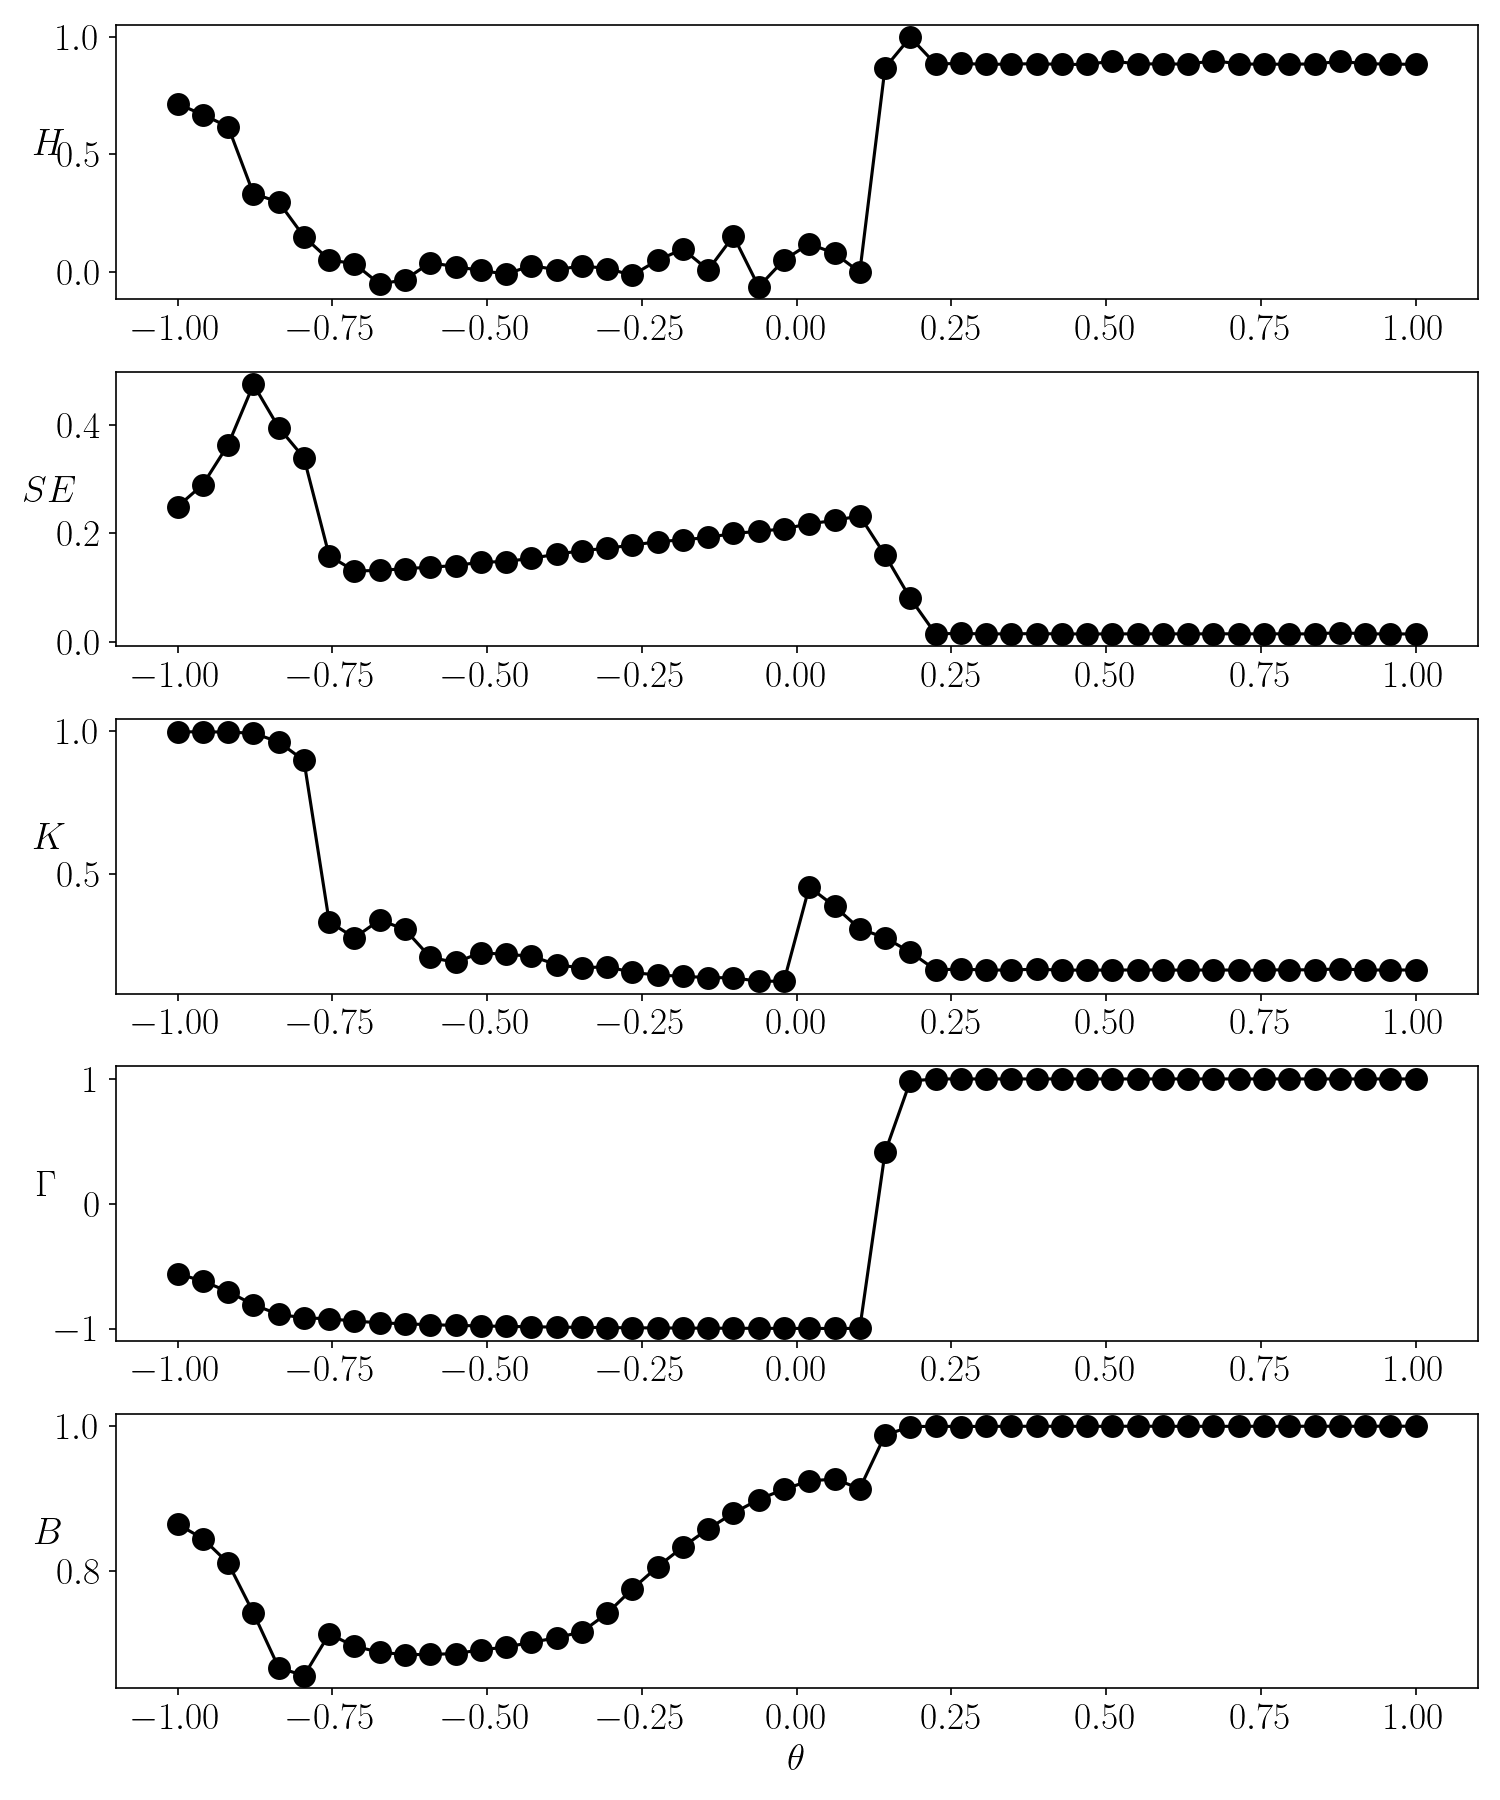

In [36]:
sz=18
%matplotlib notebook
matplotlib.rc('xtick', labelsize=sz)
matplotlib.rc('ytick', labelsize=sz)

SS = np.linspace(-1, 1, 50)

fig, axs = plt.subplots(5,1, figsize=(10, 12))

axs[0].set_ylabel('$H$',rotation=False, fontsize=sz)
axs[1].set_ylabel('$SE$',rotation=False, fontsize=sz)
axs[2].set_ylabel('$K$',rotation=False, fontsize=sz)
axs[3].set_ylabel('$\\Gamma$',rotation=False, fontsize=sz)
axs[4].set_ylabel('$B$',rotation=False, fontsize=sz)
axs[4].set_xlabel('$\\theta$', fontsize=sz)

HH = dfJJ['H']
SE = dfJJ['SE']
KKTest = dfJJ['KK']
CC = dfJJ['CC']
Kuramoto = dfJJ['Kuramoto']


axs[0].plot(SS, HH, 'ko-', ms=10)
axs[1].plot(SS, SE, 'ko-', ms=10)
axs[2].plot(SS, KKTest, 'ko-', ms=10)
axs[3].plot(SS, CC, 'ko-', ms=10)
axs[4].plot(SS, Kuramoto, 'ko-', ms=10)

plt.tight_layout()


## Memristive coupling

In [26]:
def bif_mem_pp(theta):
    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005

    alpha = 10
    beta = 5
    
    print("theta=", theta)
    def rho(p): return alpha + 3*beta*p**2

    def system(t, vars):
        x1, y1, I1, x2, y2, I2, p= vars
        dx1dt = x1**2 * (1 - x1) - y1 + I1 + theta*rho(p)*(x2 - x1)
        dy1dt = A * np.exp(alpha * x1) - gamma * y1
        dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
        dx2dt = x2**2 * (1 - x2) - y2 + I2 + theta*rho(p)*(x1 - x2)
        dy2dt = A * np.exp(alpha * x2) - gamma * y2
        dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)
        dpdt = theta*(x1-x2)

        return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt, dpdt]

    # Initial conditions
    x1_0 = np.random.uniform(low=-1, high=1)
    y1_0 = 0.1
    I1_0 = 0.018

    x2_0 = np.random.uniform(low=-1, high=1)
    y2_0 = .1
    I2_0 = 0.022

    p_0 = theta*(x1_0 - x2_0)
    print(x1_0, x2_0)


    initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0, p_0]

    t_span = (0, 4000)
    t_eval = np.linspace(t_span[0], t_span[1], 50000)

    solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

    x1_sol = solution.y[0]
    y1_sol = solution.y[1]
    I1_sol = solution.y[2]

    x2_sol = solution.y[3]
    y2_sol = solution.y[4]
    I2_sol = solution.y[5]


    tt = solution.t
    
    phi_x1 = np.array(x1_sol[5000:])
    phi_x2 = np.array(x2_sol[5000:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)

    Numerator = np.mean(x1_tilde*x2_tilde)
    Denominator = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    cc = Numerator/Denominator
    print("cc =",cc)

    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Indt = np.abs(1/2*(Ind1+Ind2))
    Kuram = np.mean(Indt)
    print("Kuram =",Kuram)
    
    t_spanKK = (0, 4000)
    t_evalKK = np.linspace(t_spanKK[0], t_spanKK[1], 10000)

    solutionKK = solve_ivp(system, t_spanKK, initial_conditions, t_eval=t_evalKK, method='RK45')

    x1_solKK = solutionKK.y[0]
    y1_solKK = solutionKK.y[1]
    I1_solKK = solutionKK.y[2]

    x2_solKK = solutionKK.y[3]
    y2_solKK = solutionKK.y[4]
    I2_solKK = solutionKK.y[5]


    ttKK = solutionKK.t
    
    def pq(phi, c):
        imax = len(phi)
        p = np.zeros(imax)
        q = np.zeros(imax)
        p[0] = phi[0] * np.cos(c)
        q[0] = phi[0] * np.sin(c)
        for i in range(1, imax):
            p[i] = p[i-1] + phi[i-1]*np.cos(c * (i-1))
            q[i] = q[i-1] + phi[i-1]*np.sin(c * (i-1))
        return p,q
    
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    c = 1.1
    ncut2 = 50

    phi_x1 = x1_solKK[8000:]
    phi_y1 = y1_solKK[8000:]
    phi_x2 = x2_solKK[8000:]
    phi_y2 = y2_solKK[8000:]
    print("length = ", len(phi_x1))
    
    p_x1, q_x1 = pq(phi_x1, c)
    p_x2, q_x2 = pq(phi_x2, c)
    
    if theta <0:
        KK1 = correlation_method(phi_x1, ncut2)
        KK2 = correlation_method(phi_x2, ncut2)
    else:
        KK1 = regression_method(phi_x1, ncut2)
        KK2 = regression_method(phi_x2, ncut2)
    print("KK =",(KK1+KK2)/2)
    
    return x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.sampen(x1_sol), nd.sampen(x2_sol), p_x1, q_x1, p_x2, q_x2

theta= 0.01
-0.86547177667945 -0.6333754414323167
cc = -0.9714577566025705
Kuram = 0.9998086190110956
length =  2000
KK = -1.887305125106294e-07


<IPython.core.display.Javascript object>


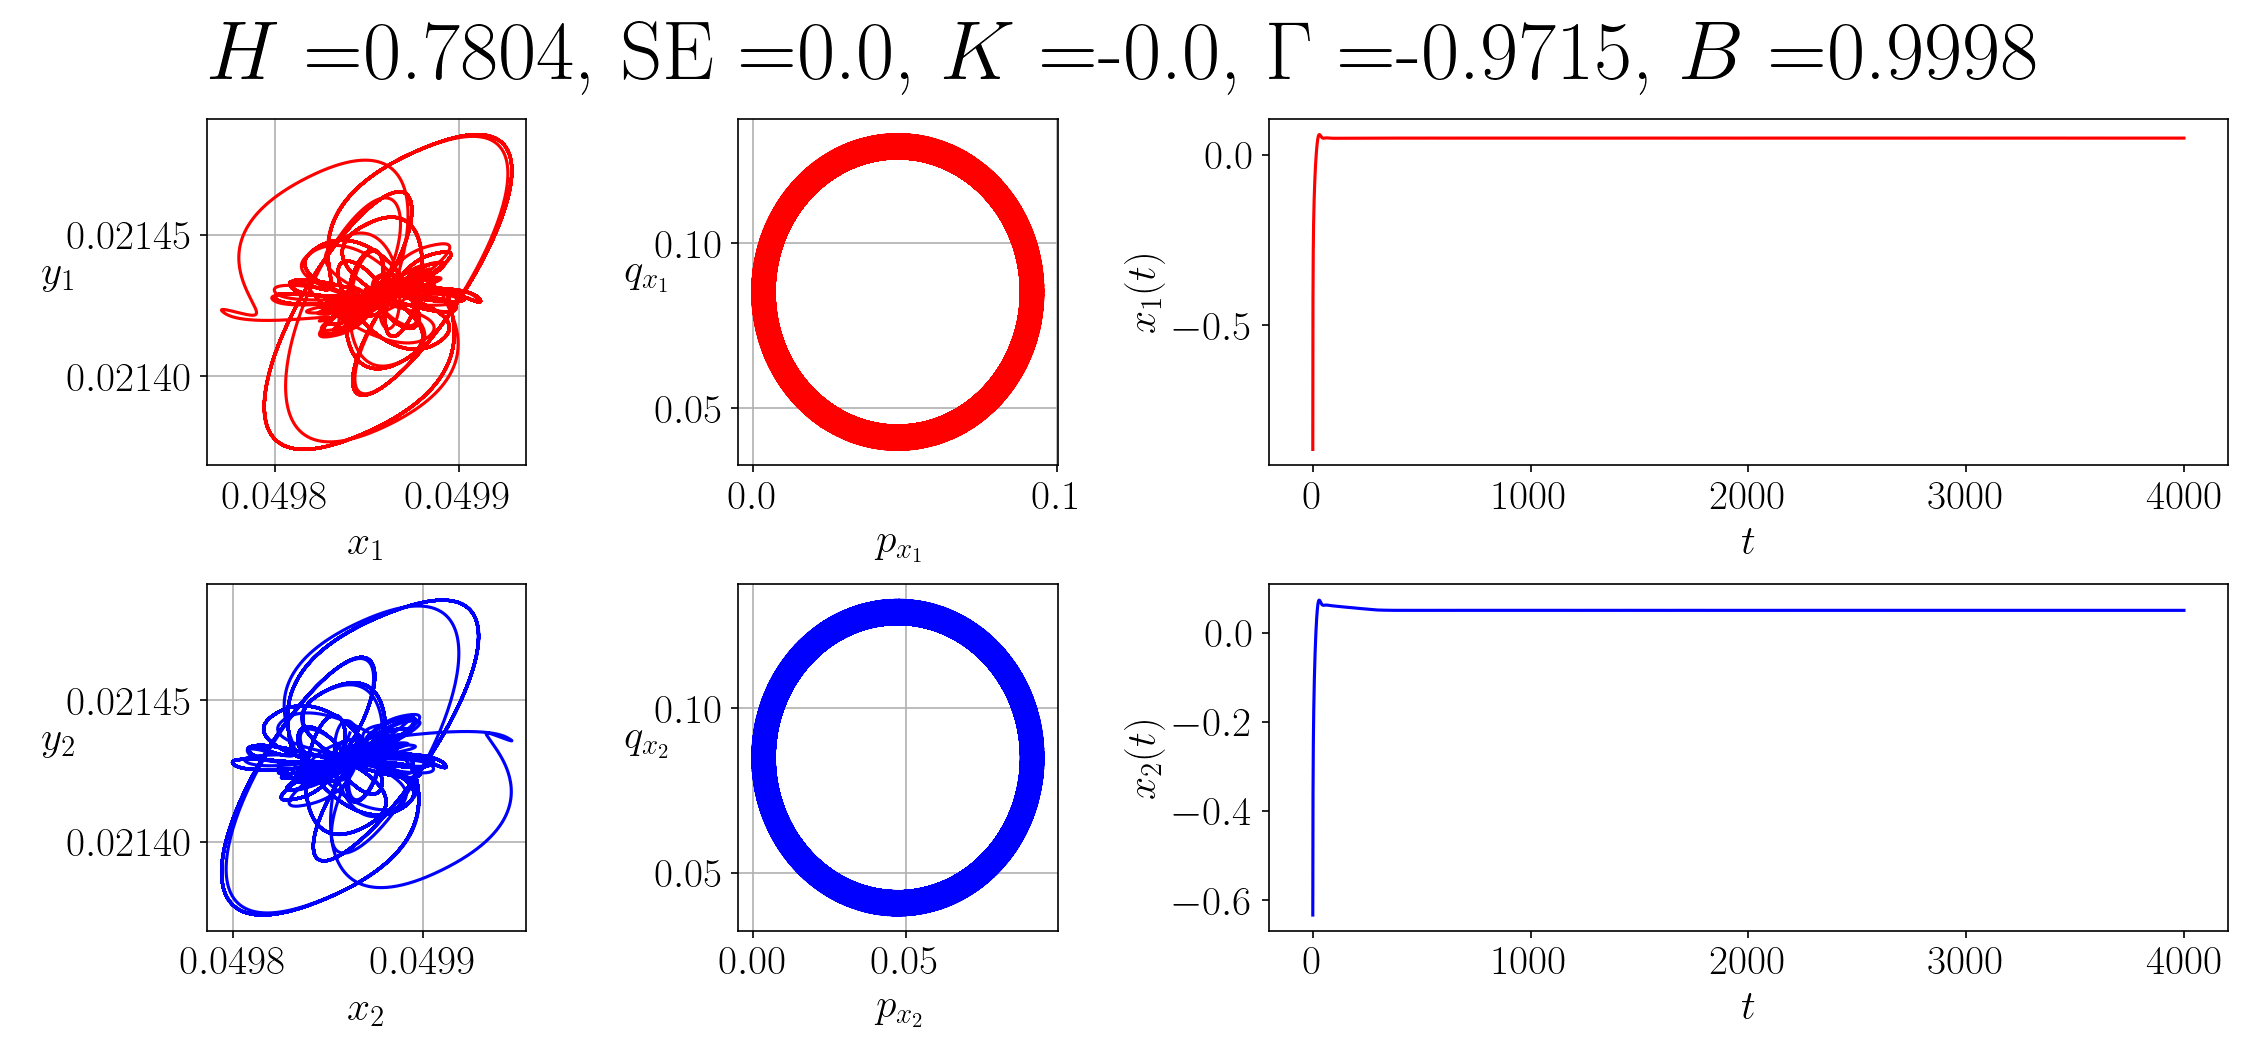

In [27]:
# theta = -0.02
# theta = -.01
# theta = -0.005
# theta = 0.002
# theta = 0.005
theta = 0.01


x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2, p_x1, q_x1, p_x2, q_x2 = bif_mem_pp(theta)

# phi_x1, phi_y1, phi_x2, phi_y2, KK1, se1, KK2, se2, kuram = [0.1, 0.2], [0.1, 0.2], [.1, .65], [0.1, 0.8], 1, 1, 1, 1, 1

sz=20
%matplotlib notebook

fig, axs = plt.subplots(2, 3, figsize=(15, 7), gridspec_kw={'width_ratios': [1, 1, 3]})
fig.tight_layout()
plt.suptitle(
    "$H=$" + str(round((h1 + h2) / 2, 4)) +
    ", $\mathrm{SE}=$" + str(round((se1 + se2) / 2, 4)) +
    ", $K=$" + str(round((KK1 + KK2) / 2, 4)) +
    ", $\Gamma=$" + str(round(cc, 4)) +
    ", $B=$" + str(round(Kuram, 4)),
    size=sz +20
)

axs[0, 0].plot(x1_sol[5000:], y1_sol[5000:], 'r-', ms =1, rasterized=True)
# axs[0, 0].plot(phi_x1, phi_y1, 'bo', ms =5, rasterized=True)
axs[0, 0].set_xlabel('$x_1$', size=sz)
axs[0, 0].set_ylabel('$y_1$', rotation = False, size=sz)
axs[0, 0].tick_params(axis='both', labelsize=sz)
axs[0, 0].grid()

axs[1, 0].plot(x2_sol[5000:], y2_sol[5000:], 'b-', ms =1,  rasterized=True)
# axs[1, 0].plot(phi_x2, phi_y2, 'ro', ms =5,  rasterized=True)
axs[1, 0].set_xlabel('$x_2$', size=sz)
axs[1, 0].set_ylabel('$y_2$', rotation=False, size=sz)
axs[1, 0].tick_params(axis='both', labelsize=sz)
axs[1, 0].grid()

axs[0, 1].plot(p_x1, q_x1, 'r-', ms =1, rasterized=True)
axs[0, 1].set_xlabel('$p_{x_1}$', size=sz)
axs[0, 1].set_ylabel('$q_{x_1}$', rotation = False, size=sz)
axs[0, 1].tick_params(axis='both', labelsize=sz)
axs[0, 1].grid()

axs[1, 1].plot(p_x2, q_x2, 'b-', ms =1, rasterized=True)
axs[1, 1].set_xlabel('$p_{x_2}$', size=sz)
axs[1, 1].set_ylabel('$q_{x_2}$', rotation = False, size=sz)
axs[1, 1].tick_params(axis='both', labelsize=sz)
axs[1, 1].grid()

axs[0, 2].plot(tt, x1_sol, 'r-', ms=1, rasterized=True)
axs[0, 2].set_ylabel('$x_1(t)$', size=sz)
axs[0, 2].set_xlabel('$t$', size=sz)
axs[0, 2].tick_params(axis='both', labelsize=sz)

axs[1, 2].plot(tt, x2_sol, 'b-', ms=1, rasterized=True)
axs[1, 2].set_ylabel('$x_2(t)$', size=sz)
axs[1, 2].set_xlabel('$t$', size=sz)
axs[1, 2].tick_params(axis='both', labelsize=sz)

plt.tight_layout()

In [28]:
def bif_mem(theta):
    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005

    alpha = 10
    beta = 5
    
    print("theta=", theta)
    def rho(p): return alpha + 3*beta*p**2

    def system(t, vars):
        x1, y1, I1, x2, y2, I2, p= vars
        dx1dt = x1**2 * (1 - x1) - y1 + I1 + theta*rho(p)*(x2 - x1)
        dy1dt = A * np.exp(alpha * x1) - gamma * y1
        dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
        dx2dt = x2**2 * (1 - x2) - y2 + I2 + theta*rho(p)*(x1 - x2)
        dy2dt = A * np.exp(alpha * x2) - gamma * y2
        dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)
        dpdt = theta*(x1-x2)

        return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt, dpdt]

    # Initial conditions
    x1_0 = np.random.uniform(low=-1, high=1)
    y1_0 = 0.1
    I1_0 = 0.018

    x2_0 = np.random.uniform(low=-1, high=1)
    y2_0 = .1
    I2_0 = 0.022

    p_0 = theta*(x1_0 - x2_0)
    print(x1_0, x2_0)


    initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0, p_0]

    t_span = (0, 4000) 
    t_eval = np.linspace(t_span[0], t_span[1], 50000)

    solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

    x1_sol = solution.y[0]
    y1_sol = solution.y[1]
    I1_sol = solution.y[2]

    x2_sol = solution.y[3]
    y2_sol = solution.y[4]
    I2_sol = solution.y[5]


    tt = solution.t

    phi_x1 = np.array(x1_sol[5000:])
    phi_x2 = np.array(x2_sol[5000:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)

    Numerator = np.mean(x1_tilde*x2_tilde)
    Denominator = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    cc = Numerator/Denominator
    print("cc =",cc)

    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Indt = np.abs(1/2*(Ind1+Ind2))
    Kuram = np.mean(Indt)
    print("Kuram =",Kuram)
    
    t_spanKK = (0, 4000)
    t_evalKK = np.linspace(t_spanKK[0], t_spanKK[1], 10000)

    solutionKK = solve_ivp(system, t_spanKK, initial_conditions, t_eval=t_evalKK, method='RK45')

    x1_solKK = solutionKK.y[0]
    y1_solKK = solutionKK.y[1]
    I1_solKK = solutionKK.y[2]

    x2_solKK = solutionKK.y[3]
    y2_solKK = solutionKK.y[4]
    I2_solKK = solutionKK.y[5]


    ttKK = solutionKK.t
    
    def pq(phi, c):
        imax = len(phi)
        p = np.zeros(imax)
        q = np.zeros(imax)
        p[0] = phi[0] * np.cos(c)
        q[0] = phi[0] * np.sin(c)
        for i in range(1, imax):
            p[i] = p[i-1] + phi[i-1]*np.cos(c * (i-1))
            q[i] = q[i-1] + phi[i-1]*np.sin(c * (i-1))
        return p,q
    
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    
    c = 1.1
    ncut2 = 50

    phi_x1 = x1_solKK[8000:]
    phi_y1 = y1_solKK[8000:]
    phi_x2 = x2_solKK[8000:]
    phi_y2 = y2_solKK[8000:]
    print("length = ", len(phi_x1))
    
    if theta <0:
        KK1 = correlation_method(phi_x1, ncut2)
        KK2 = correlation_method(phi_x2, ncut2)
    else:
        KK1 = regression_method(phi_x1, ncut2)
        KK2 = regression_method(phi_x2, ncut2)
    print("KK =",(KK1+KK2)/2)
    
    return x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.sampen(x1_sol), nd.sampen(x2_sol)

In [ ]:
SS = np.linspace(-.02, .01, 50)

count = 1
HH=[]
SE=[]
KKTest = []
CC = []
Kuramoto = []
for theta in SS:
    print("count = "+str(count))
    x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2 = bif_mem(theta)
    HH+=[(h1+h2)/2, ]
    SE+=[(se1+se2)/2, ]
    CC+=[cc, ]
    KKTest+=[(KK1+KK2)/2, ]
    Kuramoto+=[Kuram, ]
    
    print("H=", (h1+h2)/2)
    print("SE=", (se1+se2)/2)
    print(" ")

    count+=1

df = pd.DataFrame({
    'theta': SS,
    'H': HH,
    'SE': SE,
    'CC': CC,
    'KK': KKTest,
    'Kuramoto': Kuramoto
})

df.to_csv('data_mem.csv', index=False)


In [32]:
dfMem = pd.read_csv('data_mem.csv')
dfMem

theta         H        SE        CC            KK  Kuramoto
0  -0.020000  0.932623  0.033901 -0.721205  6.427763e-02  0.933038
1  -0.019388  0.904771  0.037273 -0.720102  6.484284e-02  0.932966
2  -0.018776  0.829822  0.031870 -0.721226  6.130597e-02  0.935723
3  -0.018163  0.935668  0.032032 -0.721023  6.100375e-02  0.936760
4  -0.017551  0.795219  0.037047 -0.718619  6.562731e-02  0.936368
5  -0.016939  0.916222  0.046523 -0.714188  6.381501e-02  0.935249
6  -0.016327  0.899742  0.031230 -0.720379  5.555517e-02  0.939676
7  -0.015714  0.915819  0.028793 -0.722825  4.750071e-02  0.941408
8  -0.015102  0.884929  0.025959 -0.726597  4.674106e-02  0.943128
9  -0.014490  0.899991  0.026818 -0.727880  4.773651e-02  0.943766
10 -0.013878  0.913915  0.026302 -0.727196  4.832706e-02  0.944248
11 -0.013265  0.925677  0.027798 -0.728052  4.822172e-02  0.944845
12 -0.012653  0.901162  0.028349 -0.731976  5.075447e-02  0.944836
13 -0.012041  0.906238  0.030704 -0.732147  5.040298e-02  0.943584
14 -0.011429  0.926842  0.029849 -0.725217  4.759968e-02  0.942391
15 -0.010816  0.809108  0.052714 -0.711043  6.601365e-02  0.936775
16 -0.010204  0.841437  0.048323 -0.711407  6.255534e-02  0.941036
17 -0.009592  0.906862  0.047368 -0.711708  5.968352e-02  0.941401
18 -0.008980  0.917635  0.033274 -0.725568  4.745427e-02  0.944713
19 -0.008367  0.864183  0.038230 -0.712102  4.881084e-02  0.940935
20 -0.007755  0.814028  0.040034 -0.708193  4.587133e-02  0.942927
21 -0.007143  0.883055  0.036498 -0.719719  4.385774e-02  0.945713
22 -0.006531  0.957089  0.002476 -0.991248  3.049116e-02  0.910876
23 -0.005918  0.964233  0.004575 -0.986130  3.958265e-02  0.978118
24 -0.005306  0.974466  0.002707 -0.995718  6.290618e-02  0.995414
25 -0.004694  0.899326  0.000026 -0.525713 -5.566496e-01  0.998190
26 -0.004082  0.873588  0.000026  0.678393  6.210196e-01  0.999218
27 -0.003469  0.861162  0.000070  0.992075  4.526188e-01  0.999253
28 -0.002857  0.868862  0.000025  0.959470 -6.774515e-01  0.999365
29 -0.002245  0.870676  0.000067  0.981702  1.768858e-01  0.999506
30 -0.001633  0.858922  0.000024  0.983568 -2.265238e-01  0.999572
31 -0.001020  0.857022  0.000023  0.996434 -7.567195e-01  0.999790
32 -0.000408  0.809893  0.000024  0.209704 -3.144450e-01  0.999535
33  0.000204  0.829271  0.000044 -0.455601  1.103205e-07  0.999703
34  0.000816  0.833633  0.000043 -0.591332  2.212543e-06  0.999477
35  0.001429  0.784943  0.000044 -0.688793  2.594599e-07  0.999745
36  0.002041  0.838635  0.000047 -0.825310 -1.496245e-07  0.999745
37  0.002653  0.755536  0.000064 -0.903060  6.802689e-08  0.999370
38  0.003265  0.778946  0.000064 -0.945746 -3.411940e-07  0.999569
39  0.003878  0.686191  0.000042 -0.988001  8.108375e-08  0.999512
40  0.004490  0.789497  0.000066 -0.942455  3.379463e-07  0.999503
41  0.005102  0.766360  0.000043 -0.944541 -1.027973e-07  0.999546
42  0.005714  0.745199  0.000044 -0.960207 -1.003734e-07  0.999595
43  0.006327  0.716354  0.000044 -0.956120  3.992778e-07  0.999669
44  0.006939  0.662454  0.000044 -0.955234  2.982101e-07  0.999757
45  0.007551  0.704764  0.000043 -0.968218 -5.846018e-08  0.999768
46  0.008163  0.699538  0.000043 -0.968142  2.305547e-07  0.999623
47  0.008776  0.714256  0.000043 -0.966104  1.044440e-07  0.999657
48  0.009388  0.806035  0.000042 -0.975806  1.102877e-08  0.999785
49  0.010000  0.781673  0.000043 -0.968492 -7.398329e-08  0.999584

<IPython.core.display.Javascript object>


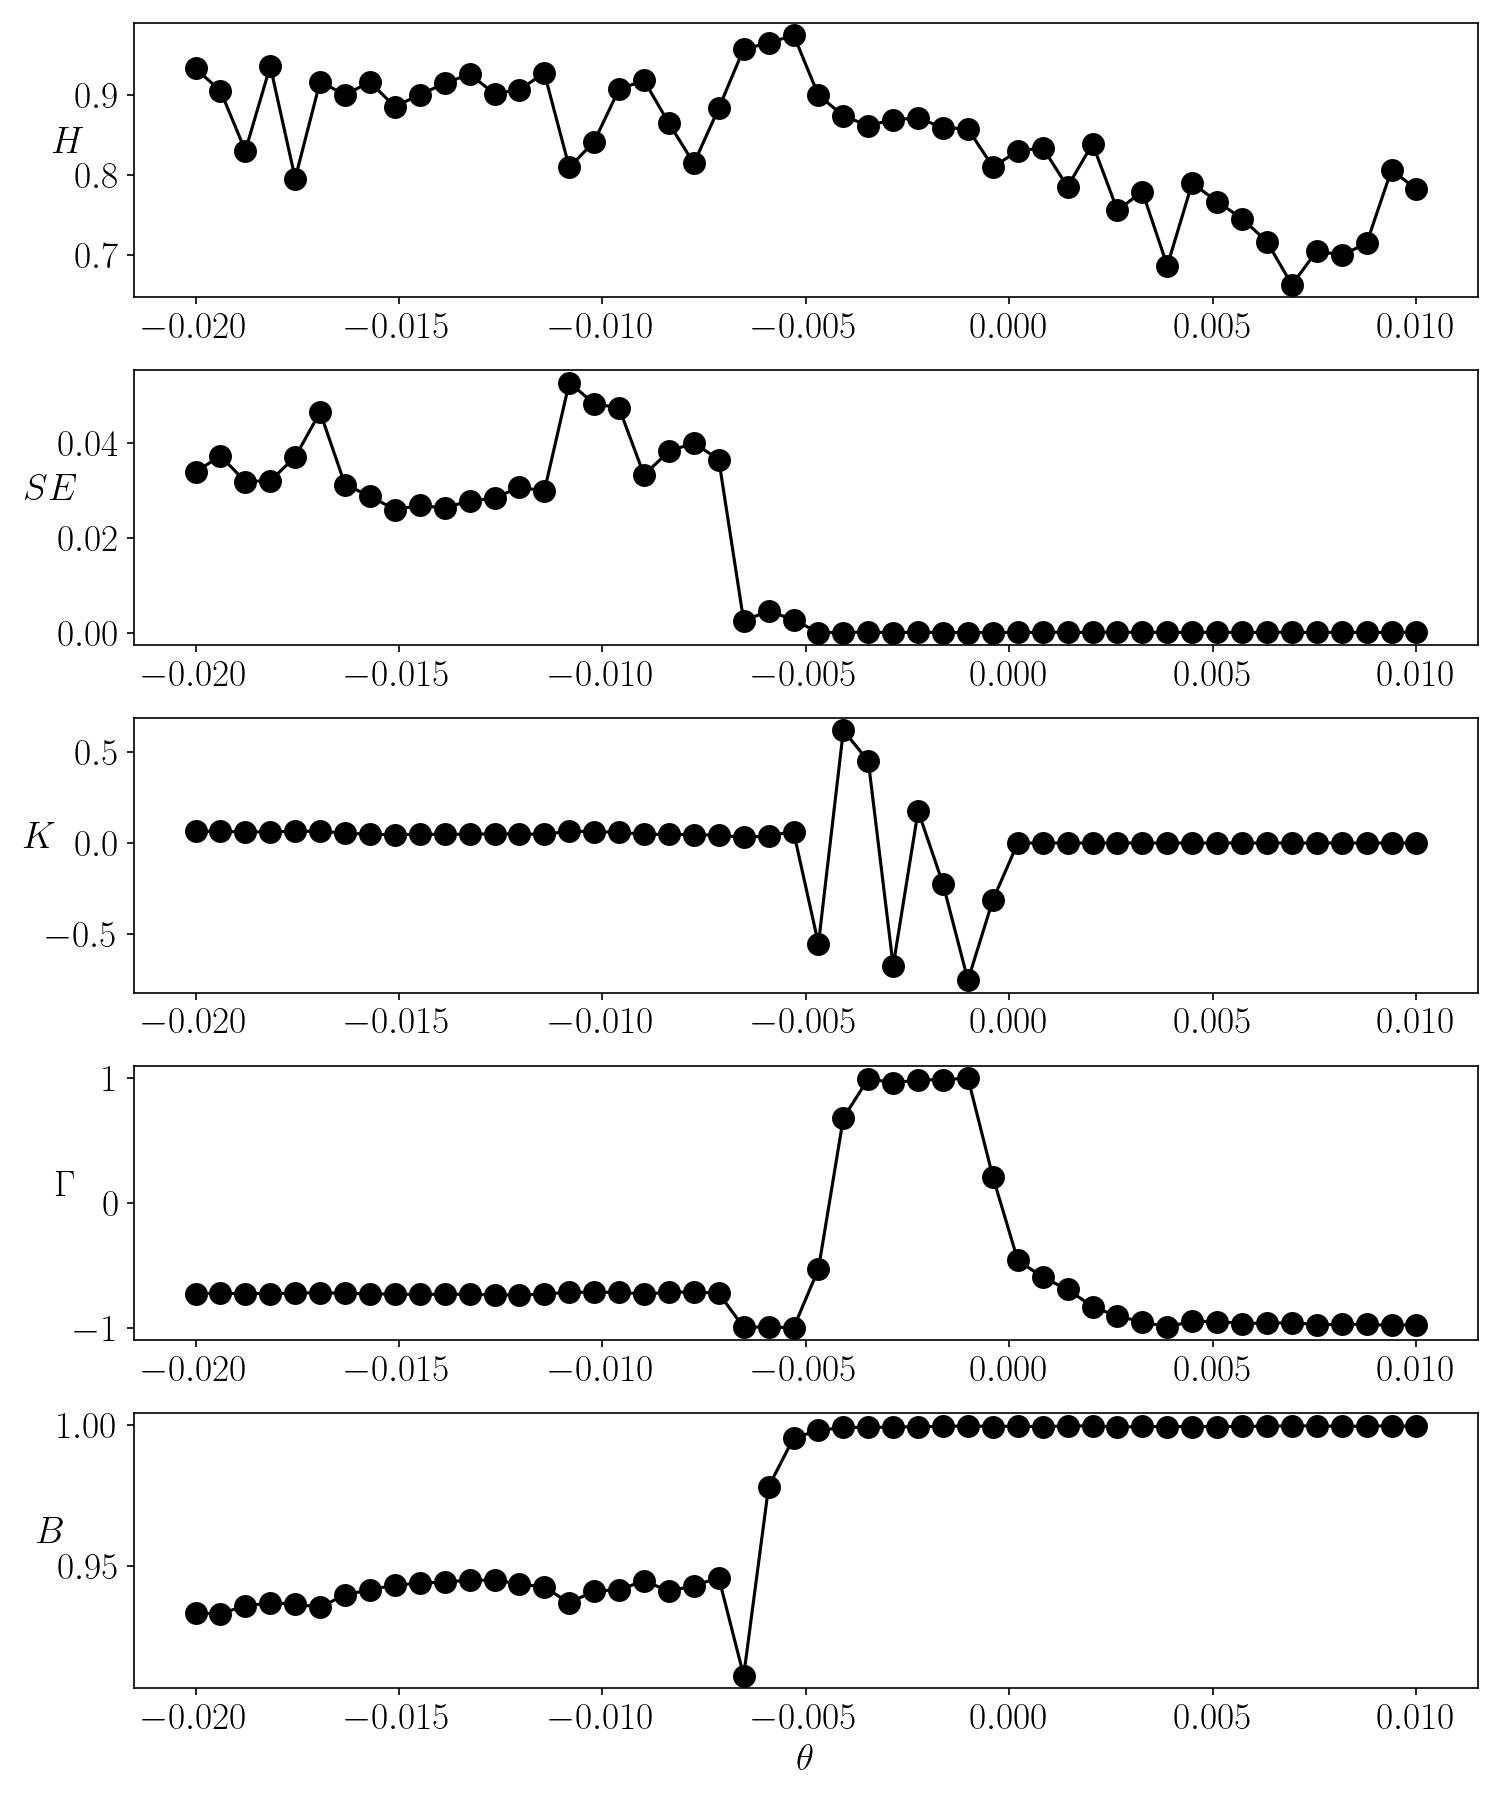

In [33]:
sz=18
%matplotlib notebook
matplotlib.rc('xtick', labelsize=sz)
matplotlib.rc('ytick', labelsize=sz)

SS = np.linspace(-.02, .01, 50)

fig, axs = plt.subplots(5,1, figsize=(10, 12))

axs[0].set_ylabel('$H$',rotation=False, fontsize=sz)
axs[1].set_ylabel('$SE$',rotation=False, fontsize=sz)
axs[2].set_ylabel('$K$',rotation=False, fontsize=sz)
axs[3].set_ylabel('$\\Gamma$',rotation=False, fontsize=sz)
axs[4].set_ylabel('$B$',rotation=False, fontsize=sz)
axs[4].set_xlabel('$\\theta$', fontsize=sz)

HH = dfMem['H']
SE = dfMem['SE']
KKTest = dfMem['KK']
CC = dfMem['CC']
Kuramoto = dfMem['Kuramoto']


axs[0].plot(SS, HH, 'ko-', ms=10)
axs[1].plot(SS, SE, 'ko-', ms=10)
axs[2].plot(SS, KKTest, 'ko-', ms=10)
axs[3].plot(SS, CC, 'ko-', ms=10)
axs[4].plot(SS, Kuramoto, 'ko-', ms=10)

plt.tight_layout()


<IPython.core.display.Javascript object>


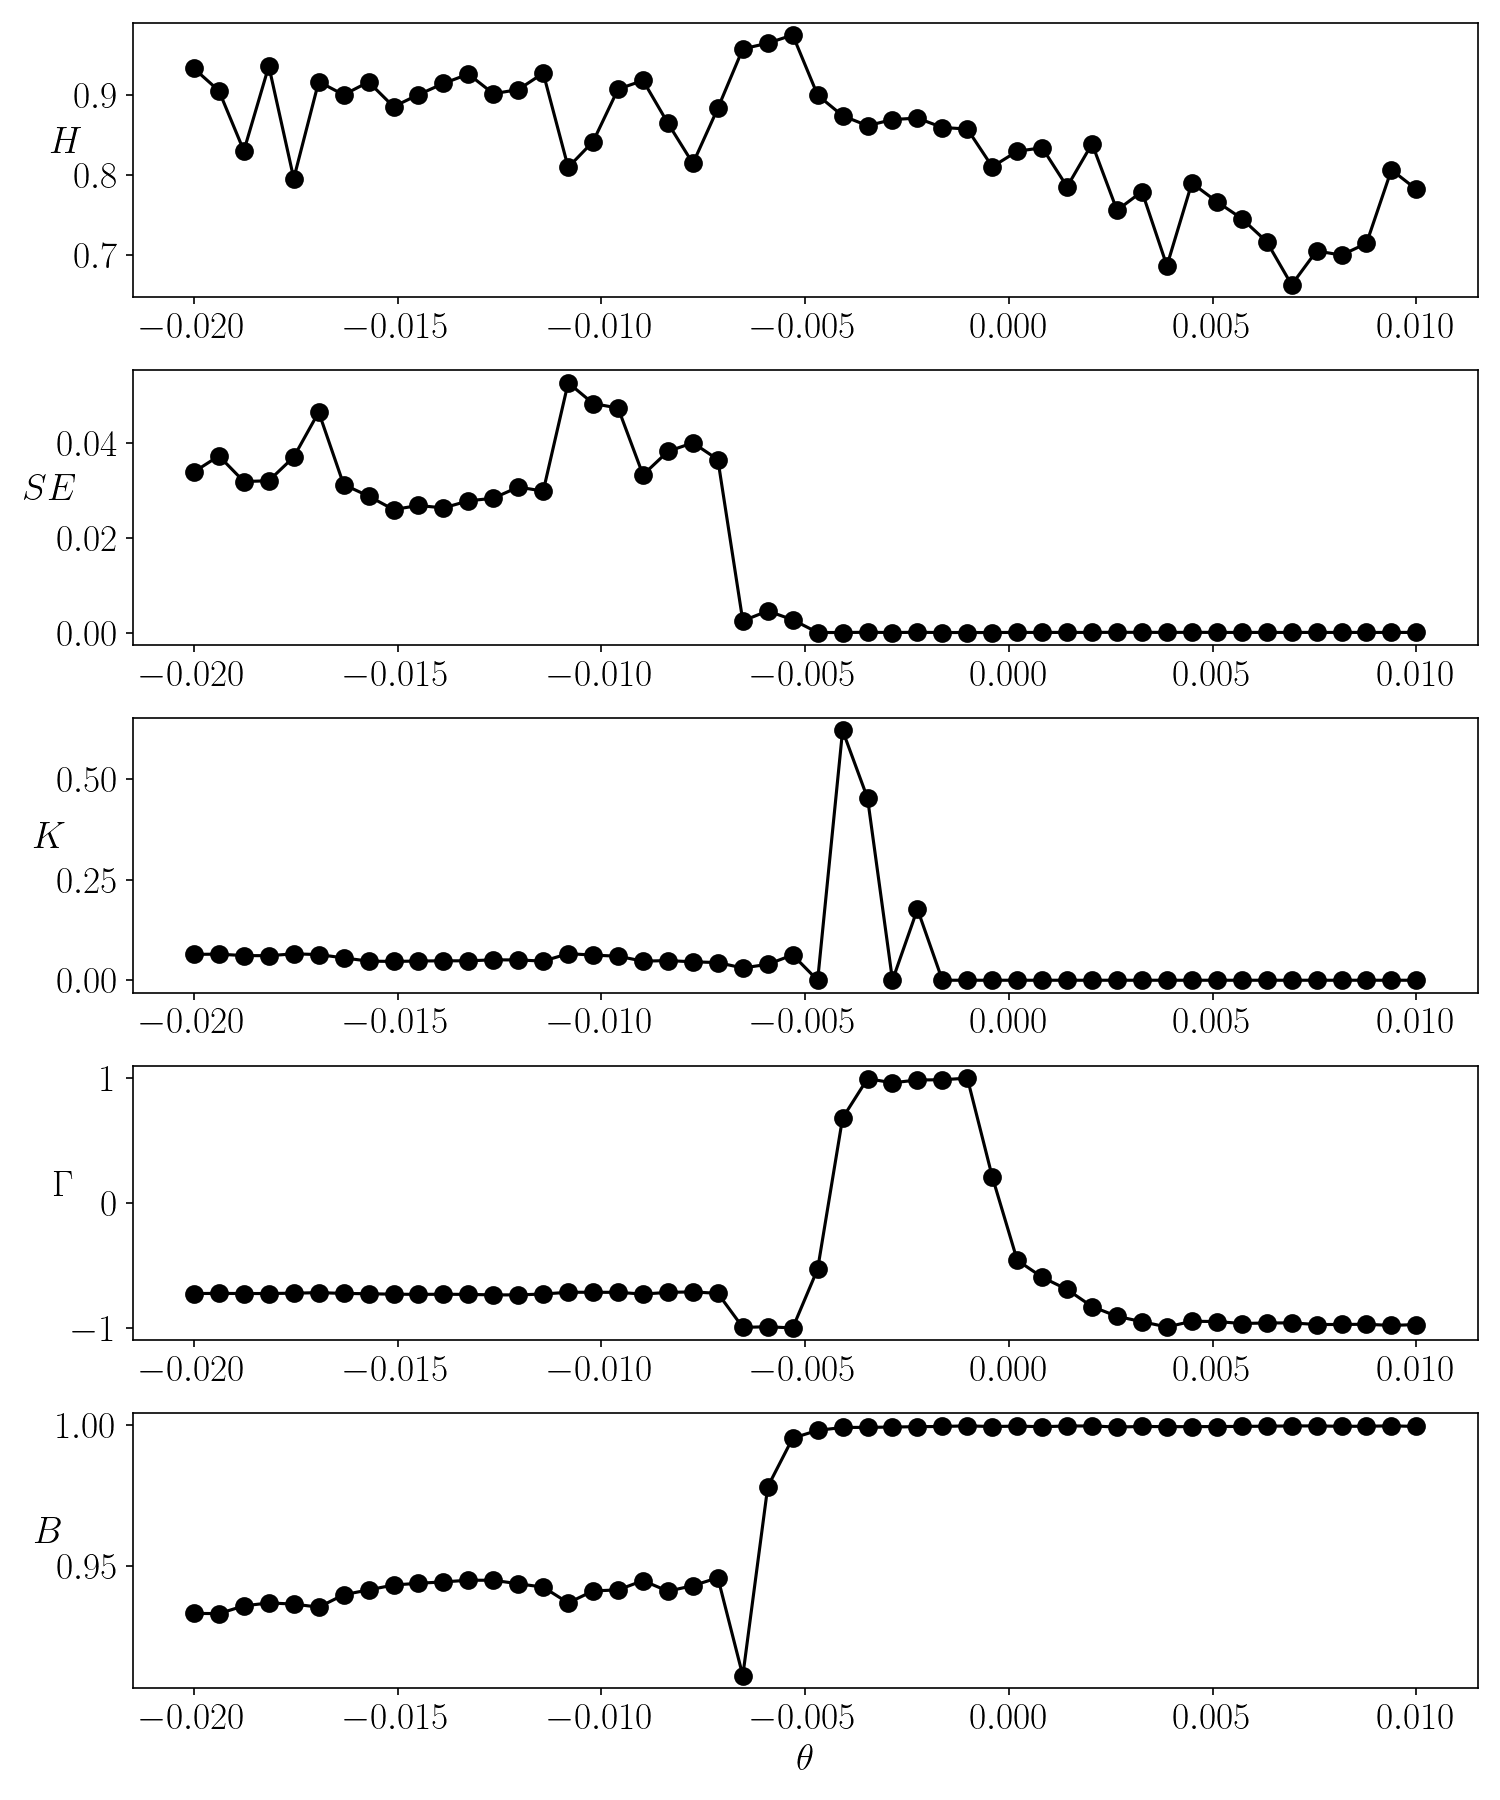

In [34]:
## After processing the data to replace spurious negative values with zeros

dfMem['KK'][25] = 0
dfMem['KK'][28] = 0
dfMem['KK'][30] = 0
dfMem['KK'][31] = 0
dfMem['KK'][32] = 0

sz=18
%matplotlib notebook
matplotlib.rc('xtick', labelsize=sz)
matplotlib.rc('ytick', labelsize=sz)

SS = np.linspace(-.02, .01, 50)

fig, axs = plt.subplots(5,1, figsize=(10, 12))

axs[0].set_ylabel('$H$',rotation=False, fontsize=sz)
axs[1].set_ylabel('$SE$',rotation=False, fontsize=sz)
axs[2].set_ylabel('$K$',rotation=False, fontsize=sz)
axs[3].set_ylabel('$\\Gamma$',rotation=False, fontsize=sz)
axs[4].set_ylabel('$B$',rotation=False, fontsize=sz)
axs[4].set_xlabel('$\\theta$', fontsize=sz)

axs[0].plot(SS, dfMem['H'], 'ko-', ms=8)
axs[1].plot(SS, dfMem['SE'], 'ko-', ms=8)
axs[2].plot(SS, dfMem['KK'], 'ko-', ms=8)
axs[3].plot(SS, dfMem['CC'], 'ko-', ms=8)
axs[4].plot(SS, dfMem['Kuramoto'], 'ko-', ms=8)

plt.tight_layout()

## Higher-order gap junction coupling in the smallest ring-star network

In [39]:
def bif_ho_pp(theta):
    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005

    mu = .01
    sigma = .01

    def system(t, vars):
        x1, y1, I1, x2, y2, I2, x3, y3, I3, x4, y4, I4= vars
        dx1dt = x1**2 * (1 - x1) - y1 + I1+ mu * (x2+x3+x4 - 3*x1) + 2*theta*(x2+x3+x4-3*x1)
        dy1dt = A * np.exp(alpha * x1) - gamma * y1
        dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
        dx2dt = x2**2 * (1 - x2) - y2 + I2 + mu * (x1 - x2) +sigma*(x3+x4-2*x2) + 2*theta*(x1+x3+x4 - 3*x2)
        dy2dt = A * np.exp(alpha * x2) - gamma * y2
        dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)
        dx3dt = x3**2 * (1 - x3) - y3 + I3+ mu * (x1 - x3) +sigma*(x2+x4-2*x3) + 2*theta*(x1+x2+x4 - 3*x3)
        dy3dt = A * np.exp(alpha * x3) - gamma * y3
        dI3dt = epsilon*(1/60*(1+np.tanh((0.05-x3)/0.001)) - I3)
        dx4dt = x4**2 * (1 - x4) - y4 + I4 + mu * (x1 - x4) +sigma*(x2+x3-2*x4) + 2*theta*(x1+x2+x3 - 3*x4)
        dy4dt = A * np.exp(alpha * x4) - gamma * y4
        dI4dt = epsilon*(1/60*(1+np.tanh((0.05-x4)/0.001)) - I4)

        return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt, dx3dt, dy3dt, dI3dt, dx4dt, dy4dt, dI4dt]

    x1_0 = np.random.uniform(low=-1, high=1)

    y1_0 = 0.1
    I1_0 = 0.018

    x2_0 = np.random.uniform(low=-1, high=1)

    y2_0 = .1
    I2_0 = 0.019

    x3_0 = np.random.uniform(low=-1, high=1)
    y3_0 = 0.1
    I3_0 = 0.02


    x4_0 = np.random.uniform(low=-1, high=1)
    y4_0 = .1
    I4_0 = 0.022


    initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0, x3_0, y3_0, I3_0, x4_0, y4_0, I4_0]

    t_span = (0, 4000)
    t_eval = np.linspace(t_span[0], t_span[1], 50000)

    solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

    x1_sol = solution.y[0]
    y1_sol = solution.y[1]
    I1_sol = solution.y[2]

    x2_sol = solution.y[3]
    y2_sol = solution.y[4]
    I2_sol = solution.y[5]

    x3_sol = solution.y[6]
    y3_sol = solution.y[7]
    I3_sol = solution.y[8]

    x4_sol = solution.y[9]
    y4_sol = solution.y[10]
    I4_sol = solution.y[11]

    tt = solution.t

    phi_x1 = np.array(x1_sol[5000:])
    phi_x2 = np.array(x2_sol[5000:])
    phi_x3 = np.array(x3_sol[5000:])
    phi_x4 = np.array(x4_sol[5000:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)
    x3_tilde = phi_x3 - np.mean(phi_x3)
    x4_tilde = phi_x4 - np.mean(phi_x4)
    

    Numerator2 = np.mean(x1_tilde*x2_tilde)
    Denominator2 = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    Numerator3 = np.mean(x1_tilde*x3_tilde)
    Denominator3 = np.sqrt(np.mean(x1_tilde**2)*np.mean(x3_tilde**2))
    
    Numerator4 = np.mean(x1_tilde*x4_tilde)
    Denominator4 = np.sqrt(np.mean(x1_tilde**2)*np.mean(x4_tilde**2))
    
    cc = (Numerator2/Denominator2 + Numerator3/Denominator3+ Numerator4/Denominator4)/3
    print("cc =",cc)
    

    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)
    l3 = np.arctan(y3_sol/x3_sol)
    l4 = np.arctan(y4_sol/x4_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Ind3 = np.exp(1j*l3)
    Ind4 = np.exp(1j*l4)
    Indt = np.abs(1/4*(Ind1+Ind2+Ind3+Ind4))
    Kuram = np.mean(Indt)
    print("Kuram =",Kuram)

    t_spanKK = (0, 4000)
    t_evalKK = np.linspace(t_spanKK[0], t_spanKK[1], 10000)

    solutionKK = solve_ivp(system, t_spanKK, initial_conditions, t_eval=t_evalKK, method='RK45')

    
    x1_solKK = solutionKK.y[0]
    y1_solKK = solutionKK.y[1]
    I1_solKK = solutionKK.y[2]

    x2_solKK = solutionKK.y[3]
    y2_solKK = solutionKK.y[4]
    I2_solKK = solutionKK.y[5]

    x3_solKK = solutionKK.y[6]
    y3_solKK = solutionKK.y[7]
    I3_solKK = solutionKK.y[8]

    x4_solKK = solutionKK.y[9]
    y4_solKK = solutionKK.y[10]
    I4_solKK = solutionKK.y[11]

    ttKK = solutionKK.t
    
    def pq(phi, c):
        imax = len(phi)
        p = np.zeros(imax)
        q = np.zeros(imax)
        p[0] = phi[0] * np.cos(c)
        q[0] = phi[0] * np.sin(c)
        for i in range(1, imax):
            p[i] = p[i-1] + phi[i-1]*np.cos(c * (i-1))
            q[i] = q[i-1] + phi[i-1]*np.sin(c * (i-1))
        return p,q
    
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    c = 1.1
    ncut2 = 50

    phi_x1 = x1_solKK[8000:]
    phi_y1 = y1_solKK[8000:]
    phi_x2 = x2_solKK[8000:]
    phi_y2 = y2_solKK[8000:]
    phi_x3 = x3_solKK[8000:]
    phi_y3 = y3_solKK[8000:]
    phi_x4 = x4_solKK[8000:]
    phi_y4 = y4_solKK[8000:]
    print("length = ", len(phi_x1))
    
    p_x1, q_x1 = pq(phi_x1, c)
    p_x2, q_x2 = pq(phi_x2, c)
    p_x3, q_x3 = pq(phi_x3, c)
    p_x4, q_x4 = pq(phi_x4, c)
    
    if theta <0:
        KK1 = correlation_method(phi_x1, ncut2)
        KK2 = correlation_method(phi_x2, ncut2)
        KK3 = correlation_method(phi_x3, ncut2)
        KK4 = correlation_method(phi_x4, ncut2)
    else:
        KK1 = regression_method(phi_x1, ncut2)
        KK2 = regression_method(phi_x2, ncut2)
        KK3 = regression_method(phi_x3, ncut2)
        KK4 = regression_method(phi_x4, ncut2)
    print("KK =",(KK1+KK2+KK3+KK4)/4)
    
    return x1_sol, y1_sol, x2_sol, y2_sol, x3_sol, y3_sol, x4_sol, y4_sol, tt, cc, KK1, KK2, KK3, KK4, Kuram, nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.hurst_rs(x3_sol), nd.hurst_rs(x4_sol), nd.sampen(x1_sol), nd.sampen(x2_sol), nd.sampen(x3_sol), nd.sampen(x4_sol), p_x1, q_x1, p_x2, q_x2, p_x3, q_x3, p_x4, q_x4

C:\Users\ighosh\AppData\Local\Temp/ipykernel_41572/2944260958.py:13: RuntimeWarning: overflow encountered in exp
  dy1dt = A * np.exp(alpha * x1) - gamma * y1
C:\Users\ighosh\AppData\Local\Temp/ipykernel_41572/2944260958.py:16: RuntimeWarning: overflow encountered in exp
  dy2dt = A * np.exp(alpha * x2) - gamma * y2
C:\Users\ighosh\AppData\Local\Temp/ipykernel_41572/2944260958.py:19: RuntimeWarning: overflow encountered in exp
  dy3dt = A * np.exp(alpha * x3) - gamma * y3
C:\Users\ighosh\AppData\Local\Temp/ipykernel_41572/2944260958.py:22: RuntimeWarning: overflow encountered in exp
  dy4dt = A * np.exp(alpha * x4) - gamma * y4


cc = 0.9999970297737932
Kuram = 0.9972047236847655
length =  2000
KK = 0.10039964829292367


<IPython.core.display.Javascript object>


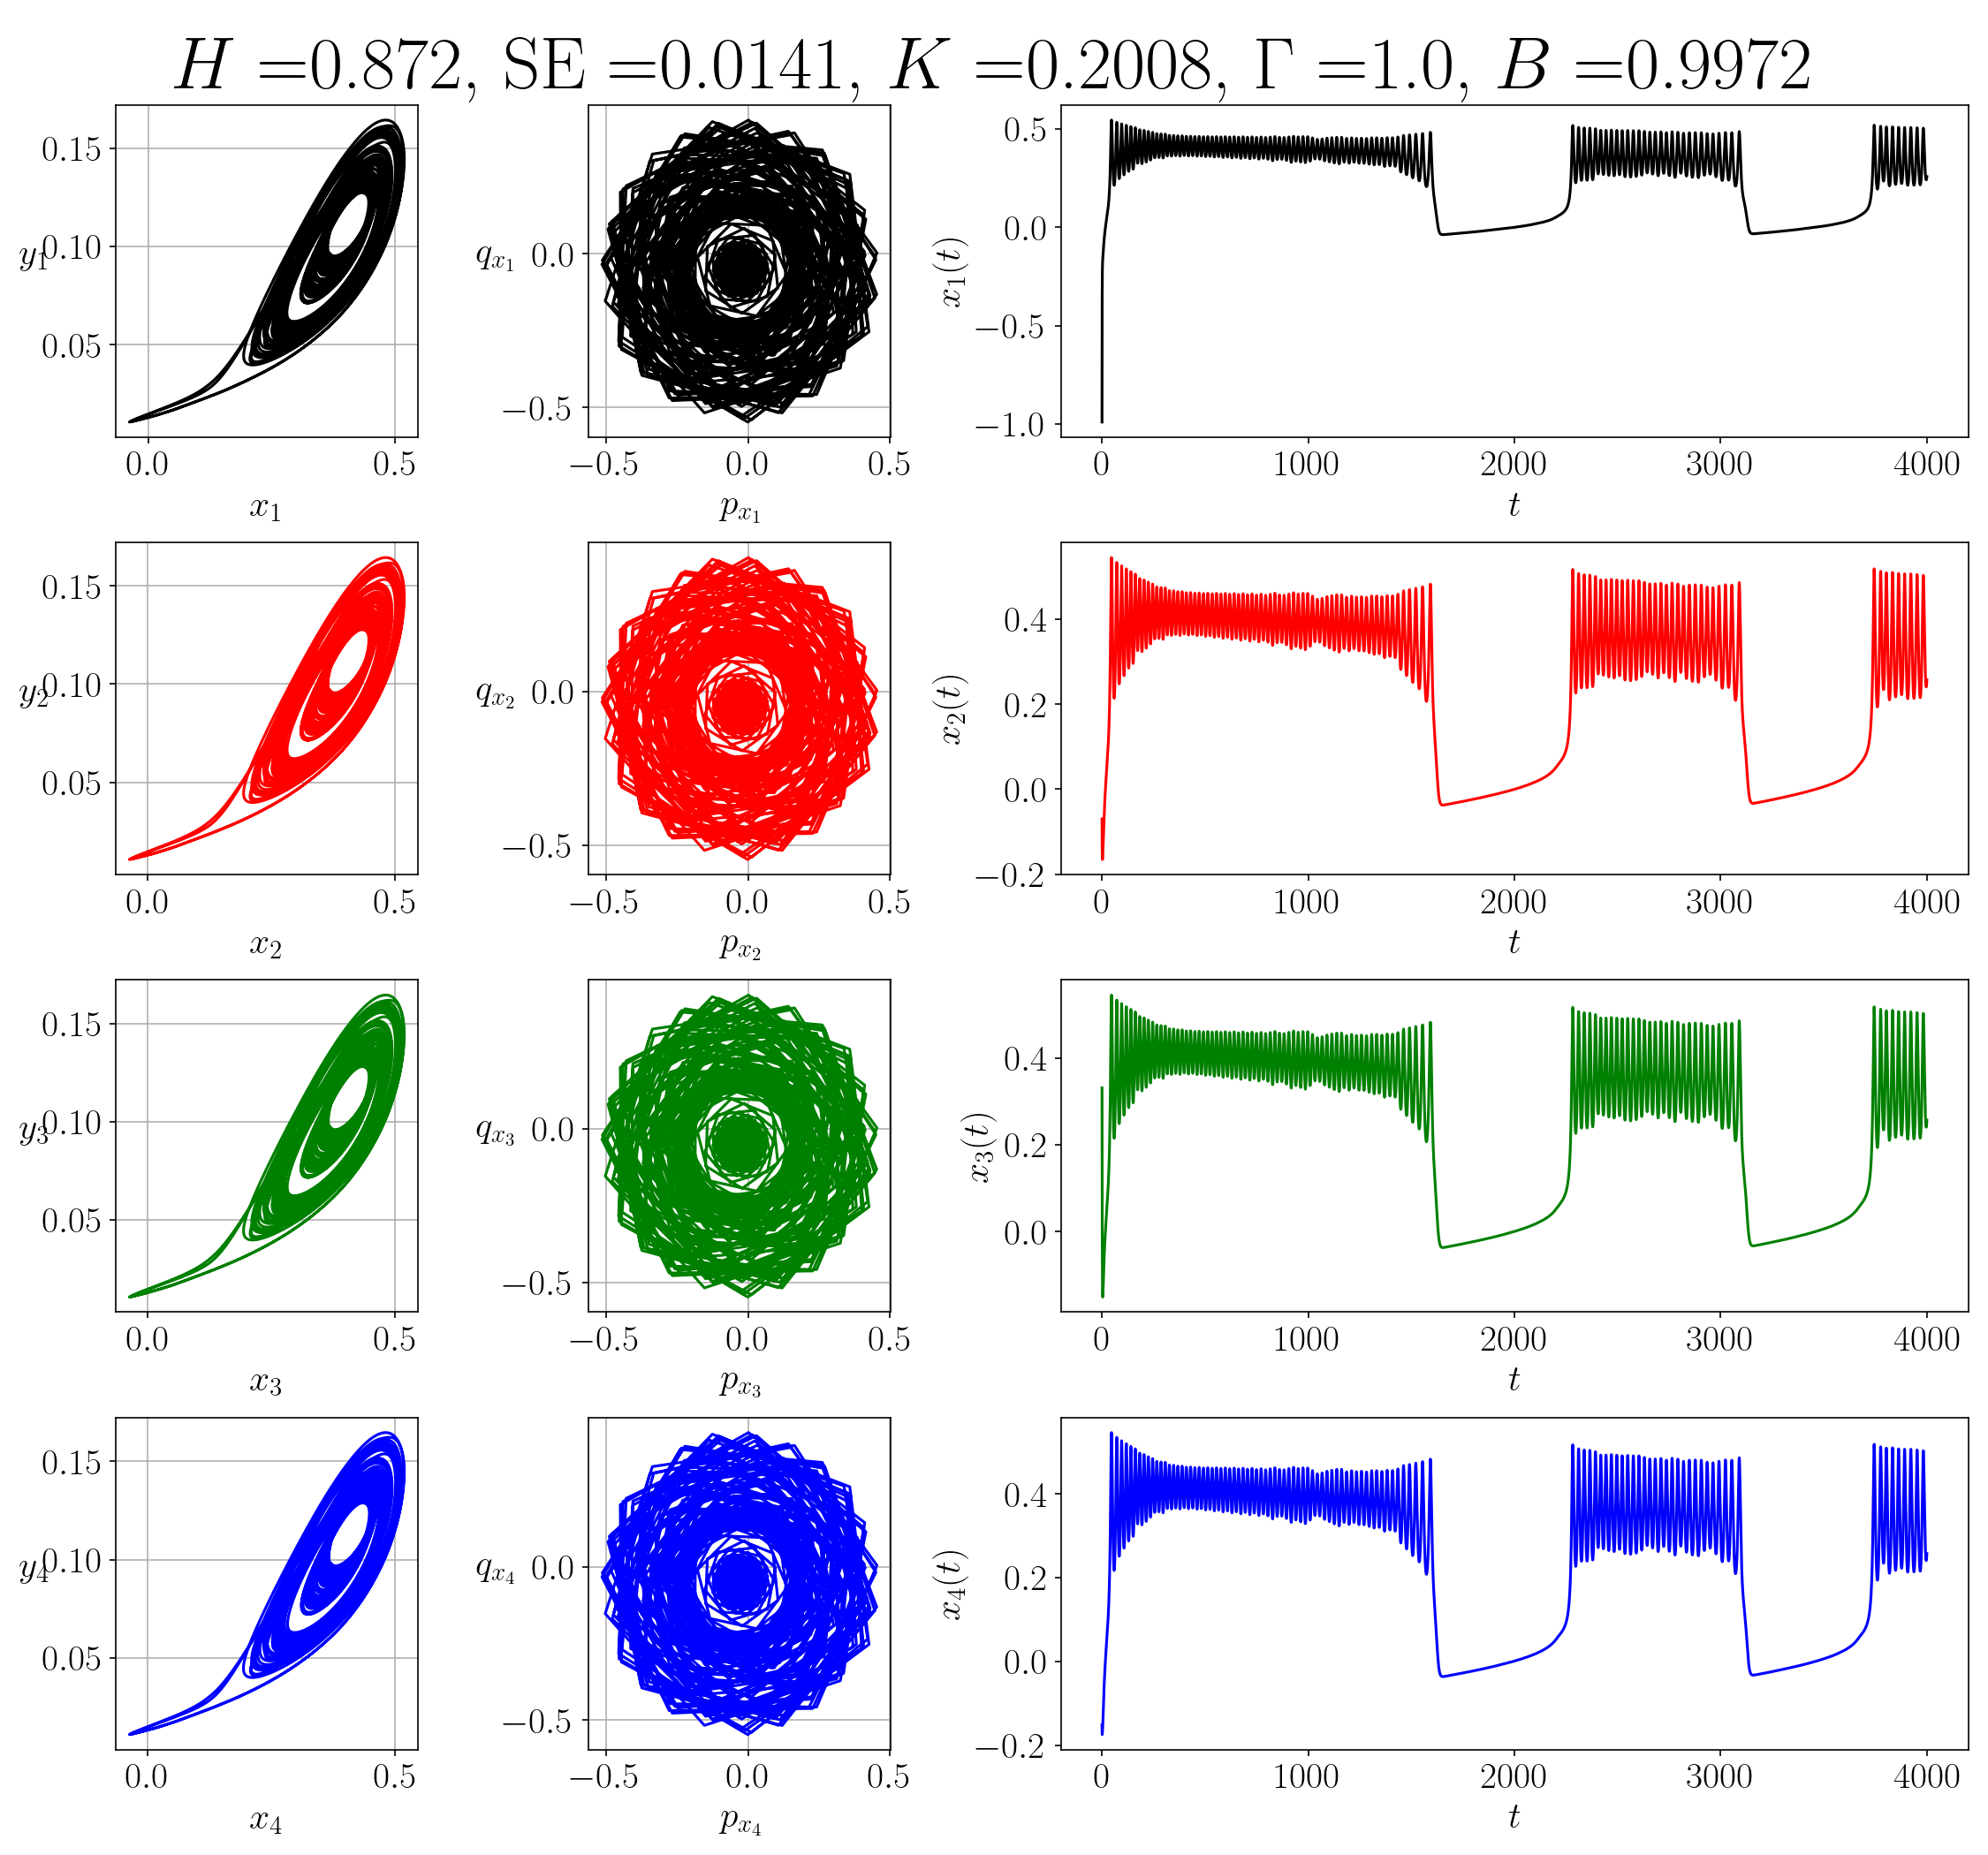

In [40]:
# theta = -0.1
# theta = -0.05
# theta = -0.01
# theta = 0.01
# theta = 0.05
theta = 0.1

x1_sol, y1_sol, x2_sol, y2_sol, x3_sol, y3_sol, x4_sol, y4_sol, tt, cc, KK1, KK2, KK3, KK4, Kuram, h1, h2, h3, h4, se1, se2, se3, se4, p_x1, q_x1, p_x2, q_x2, p_x3, q_x3, p_x4, q_x4 = bif_ho_pp(theta)

sz=20
%matplotlib notebook

fig, axs = plt.subplots(4, 3, figsize=(15, 14), gridspec_kw={'width_ratios': [1, 1, 3]})
fig.tight_layout()
plt.suptitle(
    "$H=$" + str(round((h1 + h2 + h3+ h4) / 4, 4)) +
    ", $\mathrm{SE}=$" + str(round((se1 + se2 + se3 + se4) / 4, 4)) +
    ", $K=$" + str(round((KK1 + KK2 + KK3+ KK4) / 2, 4)) +
    ", $\Gamma=$" + str(round(cc, 4)) +
    ", $B=$" + str(round(Kuram, 4)),
    size=sz +20
)

axs[0, 0].plot(x1_sol[5000:], y1_sol[5000:], 'k-', ms =1, rasterized=True)
axs[0, 0].set_xlabel('$x_1$', size=sz)
axs[0, 0].set_ylabel('$y_1$', rotation = False, size=sz)
axs[0, 0].tick_params(axis='both', labelsize=sz)
axs[0, 0].grid()

axs[1, 0].plot(x2_sol[5000:], y2_sol[5000:], 'r-', ms =1,  rasterized=True)
axs[1, 0].set_xlabel('$x_2$', size=sz)
axs[1, 0].set_ylabel('$y_2$', rotation=False, size=sz)
axs[1, 0].tick_params(axis='both', labelsize=sz)
axs[1, 0].grid()

axs[2, 0].plot(x3_sol[5000:], y3_sol[5000:], 'g-', ms =1, rasterized=True)
axs[2, 0].set_xlabel('$x_3$', size=sz)
axs[2, 0].set_ylabel('$y_3$', rotation = False, size=sz)
axs[2, 0].tick_params(axis='both', labelsize=sz)
axs[2, 0].grid()

axs[3, 0].plot(x4_sol[5000:], y4_sol[5000:], 'b-', ms =1,  rasterized=True)
axs[3, 0].set_xlabel('$x_4$', size=sz)
axs[3, 0].set_ylabel('$y_4$', rotation=False, size=sz)
axs[3, 0].tick_params(axis='both', labelsize=sz)
axs[3, 0].grid()

axs[0, 1].plot(p_x1, q_x1, 'k-', ms =1, rasterized=True)
axs[0, 1].set_xlabel('$p_{x_1}$', size=sz)
axs[0, 1].set_ylabel('$q_{x_1}$', rotation = False, size=sz)
axs[0, 1].tick_params(axis='both', labelsize=sz)
axs[0, 1].grid()

axs[1, 1].plot(p_x2, q_x2, 'r-', ms =1, rasterized=True)
axs[1, 1].set_xlabel('$p_{x_2}$', size=sz)
axs[1, 1].set_ylabel('$q_{x_2}$', rotation = False, size=sz)
axs[1, 1].tick_params(axis='both', labelsize=sz)
axs[1, 1].grid()

axs[2, 1].plot(p_x3, q_x3, 'g-', ms =1, rasterized=True)
axs[2, 1].set_xlabel('$p_{x_3}$', size=sz)
axs[2, 1].set_ylabel('$q_{x_3}$', rotation = False, size=sz)
axs[2, 1].tick_params(axis='both', labelsize=sz)
axs[2, 1].grid()

axs[3, 1].plot(p_x4, q_x4, 'b-', ms =1, rasterized=True)
axs[3, 1].set_xlabel('$p_{x_4}$', size=sz)
axs[3, 1].set_ylabel('$q_{x_4}$', rotation = False, size=sz)
axs[3, 1].tick_params(axis='both', labelsize=sz)
axs[3, 1].grid()

axs[0, 2].plot(tt, x1_sol, 'k-', ms=1, rasterized=True)
axs[0, 2].set_ylabel('$x_1(t)$', size=sz)
axs[0, 2].set_xlabel('$t$', size=sz)
axs[0, 2].tick_params(axis='both', labelsize=sz)

axs[1, 2].plot(tt, x2_sol, 'r-', ms=1, rasterized=True)
axs[1, 2].set_ylabel('$x_2(t)$', size=sz)
axs[1, 2].set_xlabel('$t$', size=sz)
axs[1, 2].tick_params(axis='both', labelsize=sz)

axs[2, 2].plot(tt, x3_sol, 'g-', ms=1, rasterized=True)
axs[2, 2].set_ylabel('$x_3(t)$', size=sz)
axs[2, 2].set_xlabel('$t$', size=sz)
axs[2, 2].tick_params(axis='both', labelsize=sz)

axs[3, 2].plot(tt, x4_sol, 'b-', ms=1, rasterized=True)
axs[3, 2].set_ylabel('$x_4(t)$', size=sz)
axs[3, 2].set_xlabel('$t$', size=sz)
axs[3, 2].tick_params(axis='both', labelsize=sz)

plt.tight_layout()

In [41]:
def bif_ho(theta):
    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005

    mu = .01
    sigma = .01

    def system(t, vars):
        x1, y1, I1, x2, y2, I2, x3, y3, I3, x4, y4, I4= vars
        dx1dt = x1**2 * (1 - x1) - y1 + I1+ mu * (x2+x3+x4 - 3*x1) + 2*theta*(x2+x3+x4-3*x1)
        dy1dt = A * np.exp(alpha * x1) - gamma * y1
        dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
        dx2dt = x2**2 * (1 - x2) - y2 + I2 + mu * (x1 - x2) +sigma*(x3+x4-2*x2) + 2*theta*(x1+x3+x4 - 3*x2)
        dy2dt = A * np.exp(alpha * x2) - gamma * y2
        dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)
        dx3dt = x3**2 * (1 - x3) - y3 + I3+ mu * (x1 - x3) +sigma*(x2+x4-2*x3) + 2*theta*(x1+x2+x4 - 3*x3)
        dy3dt = A * np.exp(alpha * x3) - gamma * y3
        dI3dt = epsilon*(1/60*(1+np.tanh((0.05-x3)/0.001)) - I3)
        dx4dt = x4**2 * (1 - x4) - y4 + I4 + mu * (x1 - x4) +sigma*(x2+x3-2*x4) + 2*theta*(x1+x2+x3 - 3*x4)
        dy4dt = A * np.exp(alpha * x4) - gamma * y4
        dI4dt = epsilon*(1/60*(1+np.tanh((0.05-x4)/0.001)) - I4)

        return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt, dx3dt, dy3dt, dI3dt, dx4dt, dy4dt, dI4dt]

    x1_0 = np.random.uniform(low=-1, high=1)
    y1_0 = 0.1
    I1_0 = 0.018

    x2_0 = np.random.uniform(low=-1, high=1)
    y2_0 = .1
    I2_0 = 0.019


    x3_0 = np.random.uniform(low=-1, high=1)
    y3_0 = 0.1
    I3_0 = 0.02


    x4_0 = np.random.uniform(low=-1, high=1)
    y4_0 = .1
    I4_0 = 0.022


    initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0, x3_0, y3_0, I3_0, x4_0, y4_0, I4_0]

    t_span = (0, 4000)
    t_eval = np.linspace(t_span[0], t_span[1], 50000)

    solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

    x1_sol = solution.y[0]
    y1_sol = solution.y[1]
    I1_sol = solution.y[2]

    x2_sol = solution.y[3]
    y2_sol = solution.y[4]
    I2_sol = solution.y[5]

    x3_sol = solution.y[6]
    y3_sol = solution.y[7]
    I3_sol = solution.y[8]

    x4_sol = solution.y[9]
    y4_sol = solution.y[10]
    I4_sol = solution.y[11]

    tt = solution.t

    phi_x1 = np.array(x1_sol[5000:])
    phi_x2 = np.array(x2_sol[5000:])
    phi_x3 = np.array(x3_sol[5000:])
    phi_x4 = np.array(x4_sol[5000:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)
    x3_tilde = phi_x3 - np.mean(phi_x3)
    x4_tilde = phi_x4 - np.mean(phi_x4)

    Numerator2 = np.mean(x1_tilde*x2_tilde)
    Denominator2 = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    Numerator3 = np.mean(x1_tilde*x3_tilde)
    Denominator3 = np.sqrt(np.mean(x1_tilde**2)*np.mean(x3_tilde**2))
    
    Numerator4 = np.mean(x1_tilde*x4_tilde)
    Denominator4 = np.sqrt(np.mean(x1_tilde**2)*np.mean(x4_tilde**2))
    
    cc = (Numerator2/Denominator2 + Numerator3/Denominator3+ Numerator4/Denominator4)/3
    print("cc =",cc)

    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)
    l3 = np.arctan(y3_sol/x3_sol)
    l4 = np.arctan(y4_sol/x4_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Ind3 = np.exp(1j*l3)
    Ind4 = np.exp(1j*l4)
    Indt = np.abs(1/4*(Ind1+Ind2+Ind3+Ind4))
    Kuram = np.mean(Indt)
    print("Kuram =",Kuram)

    t_spanKK = (0, 4000)
    t_evalKK = np.linspace(t_spanKK[0], t_spanKK[1], 10000)

    solutionKK = solve_ivp(system, t_spanKK, initial_conditions, t_eval=t_evalKK, method='RK45')

    x1_solKK = solutionKK.y[0]
    y1_solKK = solutionKK.y[1]
    I1_solKK = solutionKK.y[2]

    x2_solKK = solutionKK.y[3]
    y2_solKK = solutionKK.y[4]
    I2_solKK = solutionKK.y[5]

    x3_solKK = solutionKK.y[6]
    y3_solKK = solutionKK.y[7]
    I3_solKK = solutionKK.y[8]

    x4_solKK = solutionKK.y[9]
    y4_solKK = solutionKK.y[10]
    I4_solKK = solutionKK.y[11]

    ttKK = solutionKK.t
    
    def pq(phi, c):
        imax = len(phi)
        p = np.zeros(imax)
        q = np.zeros(imax)
        p[0] = phi[0] * np.cos(c)
        q[0] = phi[0] * np.sin(c)
        for i in range(1, imax):
            p[i] = p[i-1] + phi[i-1]*np.cos(c * (i-1))
            q[i] = q[i-1] + phi[i-1]*np.sin(c * (i-1))
        return p,q
    
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    c = 1.1
    ncut2 = 50

    phi_x1 = x1_solKK[8000:]
    phi_y1 = y1_solKK[8000:]
    phi_x2 = x2_solKK[8000:]
    phi_y2 = y2_solKK[8000:]
    phi_x3 = x3_solKK[8000:]
    phi_y3 = y3_solKK[8000:]
    phi_x4 = x4_solKK[8000:]
    phi_y4 = y4_solKK[8000:]
    print("length = ", len(phi_x1))
    
    if theta <0:
        KK1 = correlation_method(phi_x1, ncut2)
        KK2 = correlation_method(phi_x2, ncut2)
        KK3 = correlation_method(phi_x3, ncut2)
        KK4 = correlation_method(phi_x4, ncut2)
    else:
        KK1 = regression_method(phi_x1, ncut2)
        KK2 = regression_method(phi_x2, ncut2)
        KK3 = regression_method(phi_x3, ncut2)
        KK4 = regression_method(phi_x4, ncut2)
    print("KK =",(KK1+KK2+KK3+KK4)/4)
    
    return x1_sol, y1_sol, x2_sol, y2_sol, x3_sol, y3_sol, x4_sol, y4_sol, tt, cc, KK1, KK2, KK3, KK4, Kuram, nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.hurst_rs(x3_sol), nd.hurst_rs(x4_sol), nd.sampen(x1_sol), nd.sampen(x2_sol), nd.sampen(x3_sol), nd.sampen(x4_sol)

In [ ]:


SS = np.linspace(-.1, .1, 50)

count = 1
HH=[]
SE=[]
KKTest = []
CC = []
Kuramoto = []
for theta in SS:
    print("count = "+str(count))
    x1_sol, y1_sol, x2_sol, y2_sol, x3_sol, y3_sol, x4_sol, y4_sol, tt, cc, KK1, KK2, KK3, KK4, Kuram, h1, h2, h3, h4, se1, se2, se3, se4 = bif_ho(theta)
    HH+=[(h1+h2+h3+h4)/4, ]
    SE+=[(se1+se2+se3+se4)/4, ]
    CC+=[cc, ]
    KKTest+=[(KK1+KK2+KK3+KK4)/4, ]
    Kuramoto+=[Kuram, ]
    
    print("H=", (h1+h2+h3+h4)/4)
    print("SE=", (se1+se2+se3+se4)/4)
    print(" ")

    count+=1

df = pd.DataFrame({
    'theta': SS,
    'H': HH,
    'SE': SE,
    'CC': CC,
    'KK': KKTest,
    'Kuramoto': Kuramoto
})

df.to_csv('data_ho.csv', index=False)


In [42]:
dfHO = pd.read_csv('data_ho.csv')
dfHO

theta         H        SE        CC        KK  Kuramoto
0  -0.100000  0.875897  0.064335 -0.273149  0.100511  0.880872
1  -0.095918  0.842979  0.061004 -0.253432  0.088090  0.886210
2  -0.091837  0.877581  0.057679 -0.238588  0.088586  0.890946
3  -0.087755  0.831070  0.054383 -0.233997  0.076989  0.897949
4  -0.083673  0.798365  0.047953 -0.176581  0.069053  0.897469
5  -0.079592  0.835750  0.048597 -0.275321  0.066639  0.909310
6  -0.075510  0.854187  0.045035 -0.243216  0.076105  0.914655
7  -0.071429  0.870168  0.042811 -0.301057  0.068468  0.918141
8  -0.067347  0.851749  0.037930 -0.266600  0.064057  0.925147
9  -0.063265  0.875885  0.038727 -0.306122  0.065619  0.925678
10 -0.059184  0.887553  0.035375 -0.253505  0.071976  0.930276
11 -0.055102  0.891125  0.033458 -0.288765  0.067684  0.932079
12 -0.051020  0.896448  0.030760 -0.289762  0.051476  0.933454
13 -0.046939  0.903074  0.028430 -0.263944  0.061299  0.936997
14 -0.042857  0.904261  0.025217 -0.209101  0.058587  0.939686
15 -0.038776  0.886778  0.021854 -0.237312  0.049677  0.941115
16 -0.034694  0.899569  0.021225 -0.254922  0.056057  0.938858
17 -0.030612  0.900466  0.018452 -0.239461  0.049300  0.936750
18 -0.026531  0.905119  0.015832 -0.232206  0.050842  0.935513
19 -0.022449  0.896616  0.013053 -0.198674  0.049662  0.929409
20 -0.018367  0.909533  0.011657 -0.171788  0.052811  0.908785
21 -0.014286  0.915831  0.008969 -0.211686  0.044158  0.888310
22 -0.010204  0.915048  0.006779 -0.217911  0.039785  0.871747
23 -0.006122  0.894397  0.011582 -0.350473  0.054660  0.904195
24 -0.002041  0.881007  0.004357  0.979117 -0.004725  0.994696
25  0.002041  0.868898  0.006019  0.992556  0.007470  0.993961
26  0.006122  0.890607  0.018245  0.992957  0.045543  0.992807
27  0.010204  0.886409  0.014859  0.999739  0.110208  0.989145
28  0.014286  0.866835  0.012409  0.999940  0.090358  0.994367
29  0.018367  0.892164  0.013588  0.999934  0.108819  0.990336
30  0.022449  0.866858  0.008719  0.999985  0.116450  0.996197
31  0.026531  0.850891  0.008362  0.999989  0.110007  0.996926
32  0.030612  0.886898  0.015097  0.999965  0.105567  0.992033
33  0.034694  0.883468  0.012601  0.999977  0.104926  0.991205
34  0.038776  0.885454  0.014800  0.999979  0.112895  0.993297
35  0.042857  0.875304  0.014640  0.999986  0.097182  0.994295
36  0.046939  0.898623  0.014173  0.999981  0.108273  0.992158
37  0.051020  0.885097  0.011942  0.999991  0.084728  0.991547
38  0.055102  0.893592  0.014011  0.999984  0.110496  0.993309
39  0.059184  0.884361  0.012254  0.999992  0.094229  0.993097
40  0.063265  0.875399  0.012771  0.999995  0.093660  0.996456
41  0.067347  0.892950  0.015486  0.999992  0.111172  0.995985
42  0.071429  0.899158  0.011823  0.999994  0.086996  0.994375
43  0.075510  0.880661  0.015112  0.999994  0.097172  0.995880
44  0.079592  0.881393  0.012170  0.999996  0.094234  0.994793
45  0.083673  0.885326  0.013417  0.999996  0.063570  0.996770
46  0.087755  0.873253  0.010202  0.999997  0.102784  0.995603
47  0.091837  0.889163  0.016639  0.999996  0.116414  0.995967
48  0.095918  0.898804  0.011475  0.999996  0.098473  0.995791
49  0.100000  0.896036  0.016620  0.999996  0.092368  0.996845

<IPython.core.display.Javascript object>


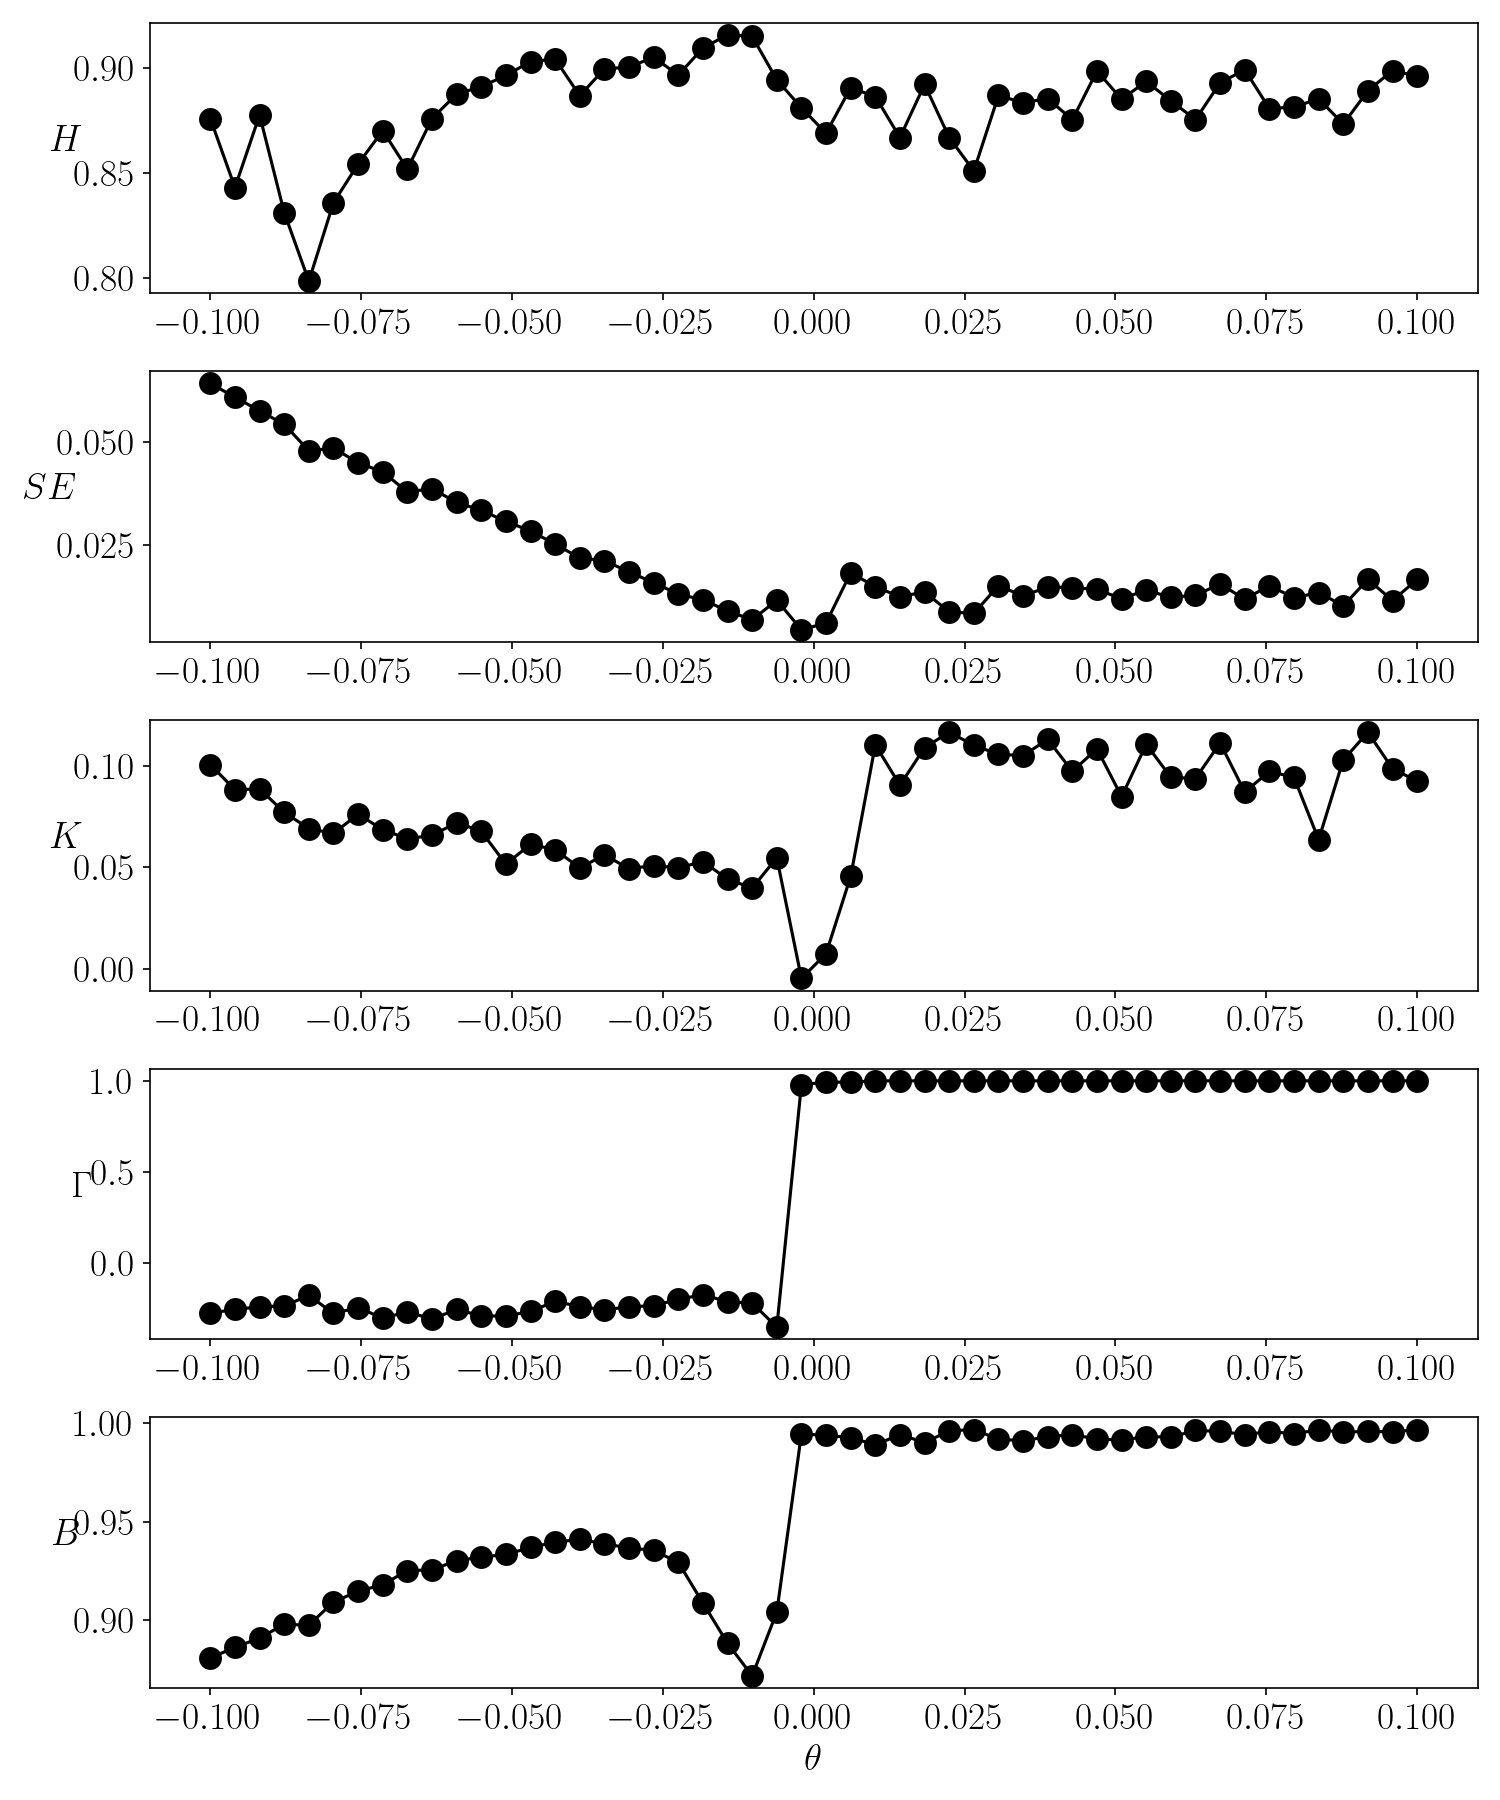

In [43]:
sz=18
%matplotlib notebook
matplotlib.rc('xtick', labelsize=sz)
matplotlib.rc('ytick', labelsize=sz)

SS = np.linspace(-.1, .1, 50)

fig, axs = plt.subplots(5,1, figsize=(10, 12))

axs[0].set_ylabel('$H$',rotation=False, fontsize=sz)
axs[1].set_ylabel('$SE$',rotation=False, fontsize=sz)
axs[2].set_ylabel('$K$',rotation=False, fontsize=sz)
axs[3].set_ylabel('$\\Gamma$',rotation=False, fontsize=sz)
axs[4].set_ylabel('$B$',rotation=False, fontsize=sz)
axs[4].set_xlabel('$\\theta$', fontsize=sz)

HH = dfHO['H']
SE = dfHO['SE']
KKTest = dfHO['KK']
CC = dfHO['CC']
Kuramoto = dfHO['Kuramoto']


axs[0].plot(SS, HH, 'ko-', ms=10)
axs[1].plot(SS, SE, 'ko-', ms=10)
axs[2].plot(SS, KKTest, 'ko-', ms=10)
axs[3].plot(SS, CC, 'ko-', ms=10)
axs[4].plot(SS, Kuramoto, 'ko-', ms=10)

plt.tight_layout()

## Random chemical coupling in a four node network with autapse

In [44]:
def bif_random_pp(theta):
    N = 4
    AA = np.random.randint(0, 2, size=(N, N))

    print("adjacency matrix = ")
    print(AA)

    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005

    vs = 2
    lamb = 10
    q=-0.25

    def dML(t, vars):
        x, y, I = vars
        dxdt = x**2 * (1 - x) - y + I
        dydt = A * np.exp(alpha * x) - gamma * y
        dIdt = epsilon*(1/60*(1+np.tanh((0.05-x)/0.001)) - I)
        return [dxdt, dydt, dIdt]

    ## Initialize states for each node
    SS = np.ones((N, 3))
    SS[:, 0] = np.random.uniform(low=-1, high=1, size = N)
    SS[:, 1] = SS[:, 1] * 0.1
    SS[:, 2] = np.random.uniform(low=0.019, high=0.022, size = N)

    dt = 0.4   ## Time step
    T = 4000      ## Total simulation time
    stepNum = int(T / dt)

    trajectories = np.zeros((stepNum, N, 3))

    for i in range(stepNum):
        newState = np.zeros((N, 3))
        for k in range(N):
            xCoup = 0

            tSpan = (0, dt)
            sol = solve_ivp(dML, tSpan, SS[k], t_eval=[dt], method='RK45')

            currentState = sol.y[:, -1]

            for j in range(N):
                xCoup = xCoup + theta*AA[k, j]*(vs-SS[k, 0])/(1+np.exp(-lamb*SS[j, 0]-q))

            currentState[0] = currentState[0] + xCoup
            currentState[1] = currentState[1]
            currentState[2] = currentState[2]

            newState[k] = currentState

        SS = newState
        trajectories[i] = SS

    ## Extract solutions
    x1_sol = trajectories[:, 0, 0]
    y1_sol = trajectories[:, 0, 1]
    I1_sol = trajectories[:, 0, 2]

    x2_sol = trajectories[:, 1, 0]
    y2_sol = trajectories[:, 1, 1]
    I2_sol = trajectories[:, 1, 2]

    x3_sol = trajectories[:, 2, 0]
    y3_sol = trajectories[:, 2, 1]
    I3_sol = trajectories[:, 2, 2]

    x4_sol = trajectories[:, 3, 0]
    y4_sol = trajectories[:, 3, 1]
    I4_sol = trajectories[:, 3, 2]

    tt = np.arange(int(4000/.4))*0.4
    
    ## For computing the cross-correlation coefficient
    phi_x1 = np.array(x1_sol[500:])
    phi_x2 = np.array(x2_sol[500:])
    phi_x3 = np.array(x3_sol[500:])
    phi_x4 = np.array(x4_sol[500:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)
    x3_tilde = phi_x3 - np.mean(phi_x3)
    x4_tilde = phi_x4 - np.mean(phi_x4)
    
    
    Numerator2 = np.mean(x1_tilde*x2_tilde)
    Denominator2 = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    Numerator3 = np.mean(x1_tilde*x3_tilde)
    Denominator3 = np.sqrt(np.mean(x1_tilde**2)*np.mean(x3_tilde**2))
    
    Numerator4 = np.mean(x1_tilde*x4_tilde)
    Denominator4 = np.sqrt(np.mean(x1_tilde**2)*np.mean(x4_tilde**2))
    
    cc = (Numerator2/Denominator2 + Numerator3/Denominator3+ Numerator4/Denominator4)/3
    print("cc =",cc)
    
    ## Kuramoto order parameter
    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)
    l3 = np.arctan(y3_sol/x3_sol)
    l4 = np.arctan(y4_sol/x4_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Ind3 = np.exp(1j*l3)
    Ind4 = np.exp(1j*l4)
    Indt = np.abs(1/4*(Ind1+Ind2+Ind3+Ind4))
    Kuram = np.mean(Indt)
    print("Kuram =",Kuram)
    
    
    ## 0-1 test
    
    def pq(phi, c):
        imax = len(phi)
        p = np.zeros(imax)
        q = np.zeros(imax)
        p[0] = phi[0] * np.cos(c)
        q[0] = phi[0] * np.sin(c)
        for i in range(1, imax):
            p[i] = p[i-1] + phi[i-1]*np.cos(c * (i-1))
            q[i] = q[i-1] + phi[i-1]*np.sin(c * (i-1))
        return p,q
    
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)

    c = 1.1
    ncut2 = 80

    phi_x1 = x1_sol[8000:]
    phi_y1 = y1_sol[8000:]
    phi_x2 = x2_sol[8000:]
    phi_y2 = y2_sol[8000:]
    phi_x3 = x3_sol[8000:]
    phi_y3 = y3_sol[8000:]
    phi_x4 = x4_sol[8000:]
    phi_y4 = y4_sol[8000:]
    print("length = ", len(phi_x1))
    
    p_x1, q_x1 = pq(phi_x1, c)
    p_x2, q_x2 = pq(phi_x2, c)
    p_x3, q_x3 = pq(phi_x3, c)
    p_x4, q_x4 = pq(phi_x4, c)
    
    
    KK1 = regression_method(phi_x1, ncut2)
    KK2 = regression_method(phi_x2, ncut2)
    KK3 = regression_method(phi_x3, ncut2)
    KK4 = regression_method(phi_x4, ncut2)
    print("KK =",(KK1+KK2+KK3+KK4)/4)
    
    return x1_sol, y1_sol, x2_sol, y2_sol, x3_sol, y3_sol, x4_sol, y4_sol, tt, cc, KK1, KK2, KK3, KK4, Kuram, nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.hurst_rs(x3_sol), nd.hurst_rs(x4_sol), nd.sampen(x1_sol), nd.sampen(x2_sol), nd.sampen(x3_sol), nd.sampen(x4_sol), p_x1, q_x1, p_x2, q_x2, p_x3, q_x3, p_x4, q_x4
    


adjacency matrix = 
[[0 0 0 1]
 [1 0 1 0]
 [1 1 1 0]
 [1 1 0 1]]
cc = 0.999722418801642
Kuram = 0.9996416022469778
length =  2000
KK = -0.0010562857859272698


<IPython.core.display.Javascript object>


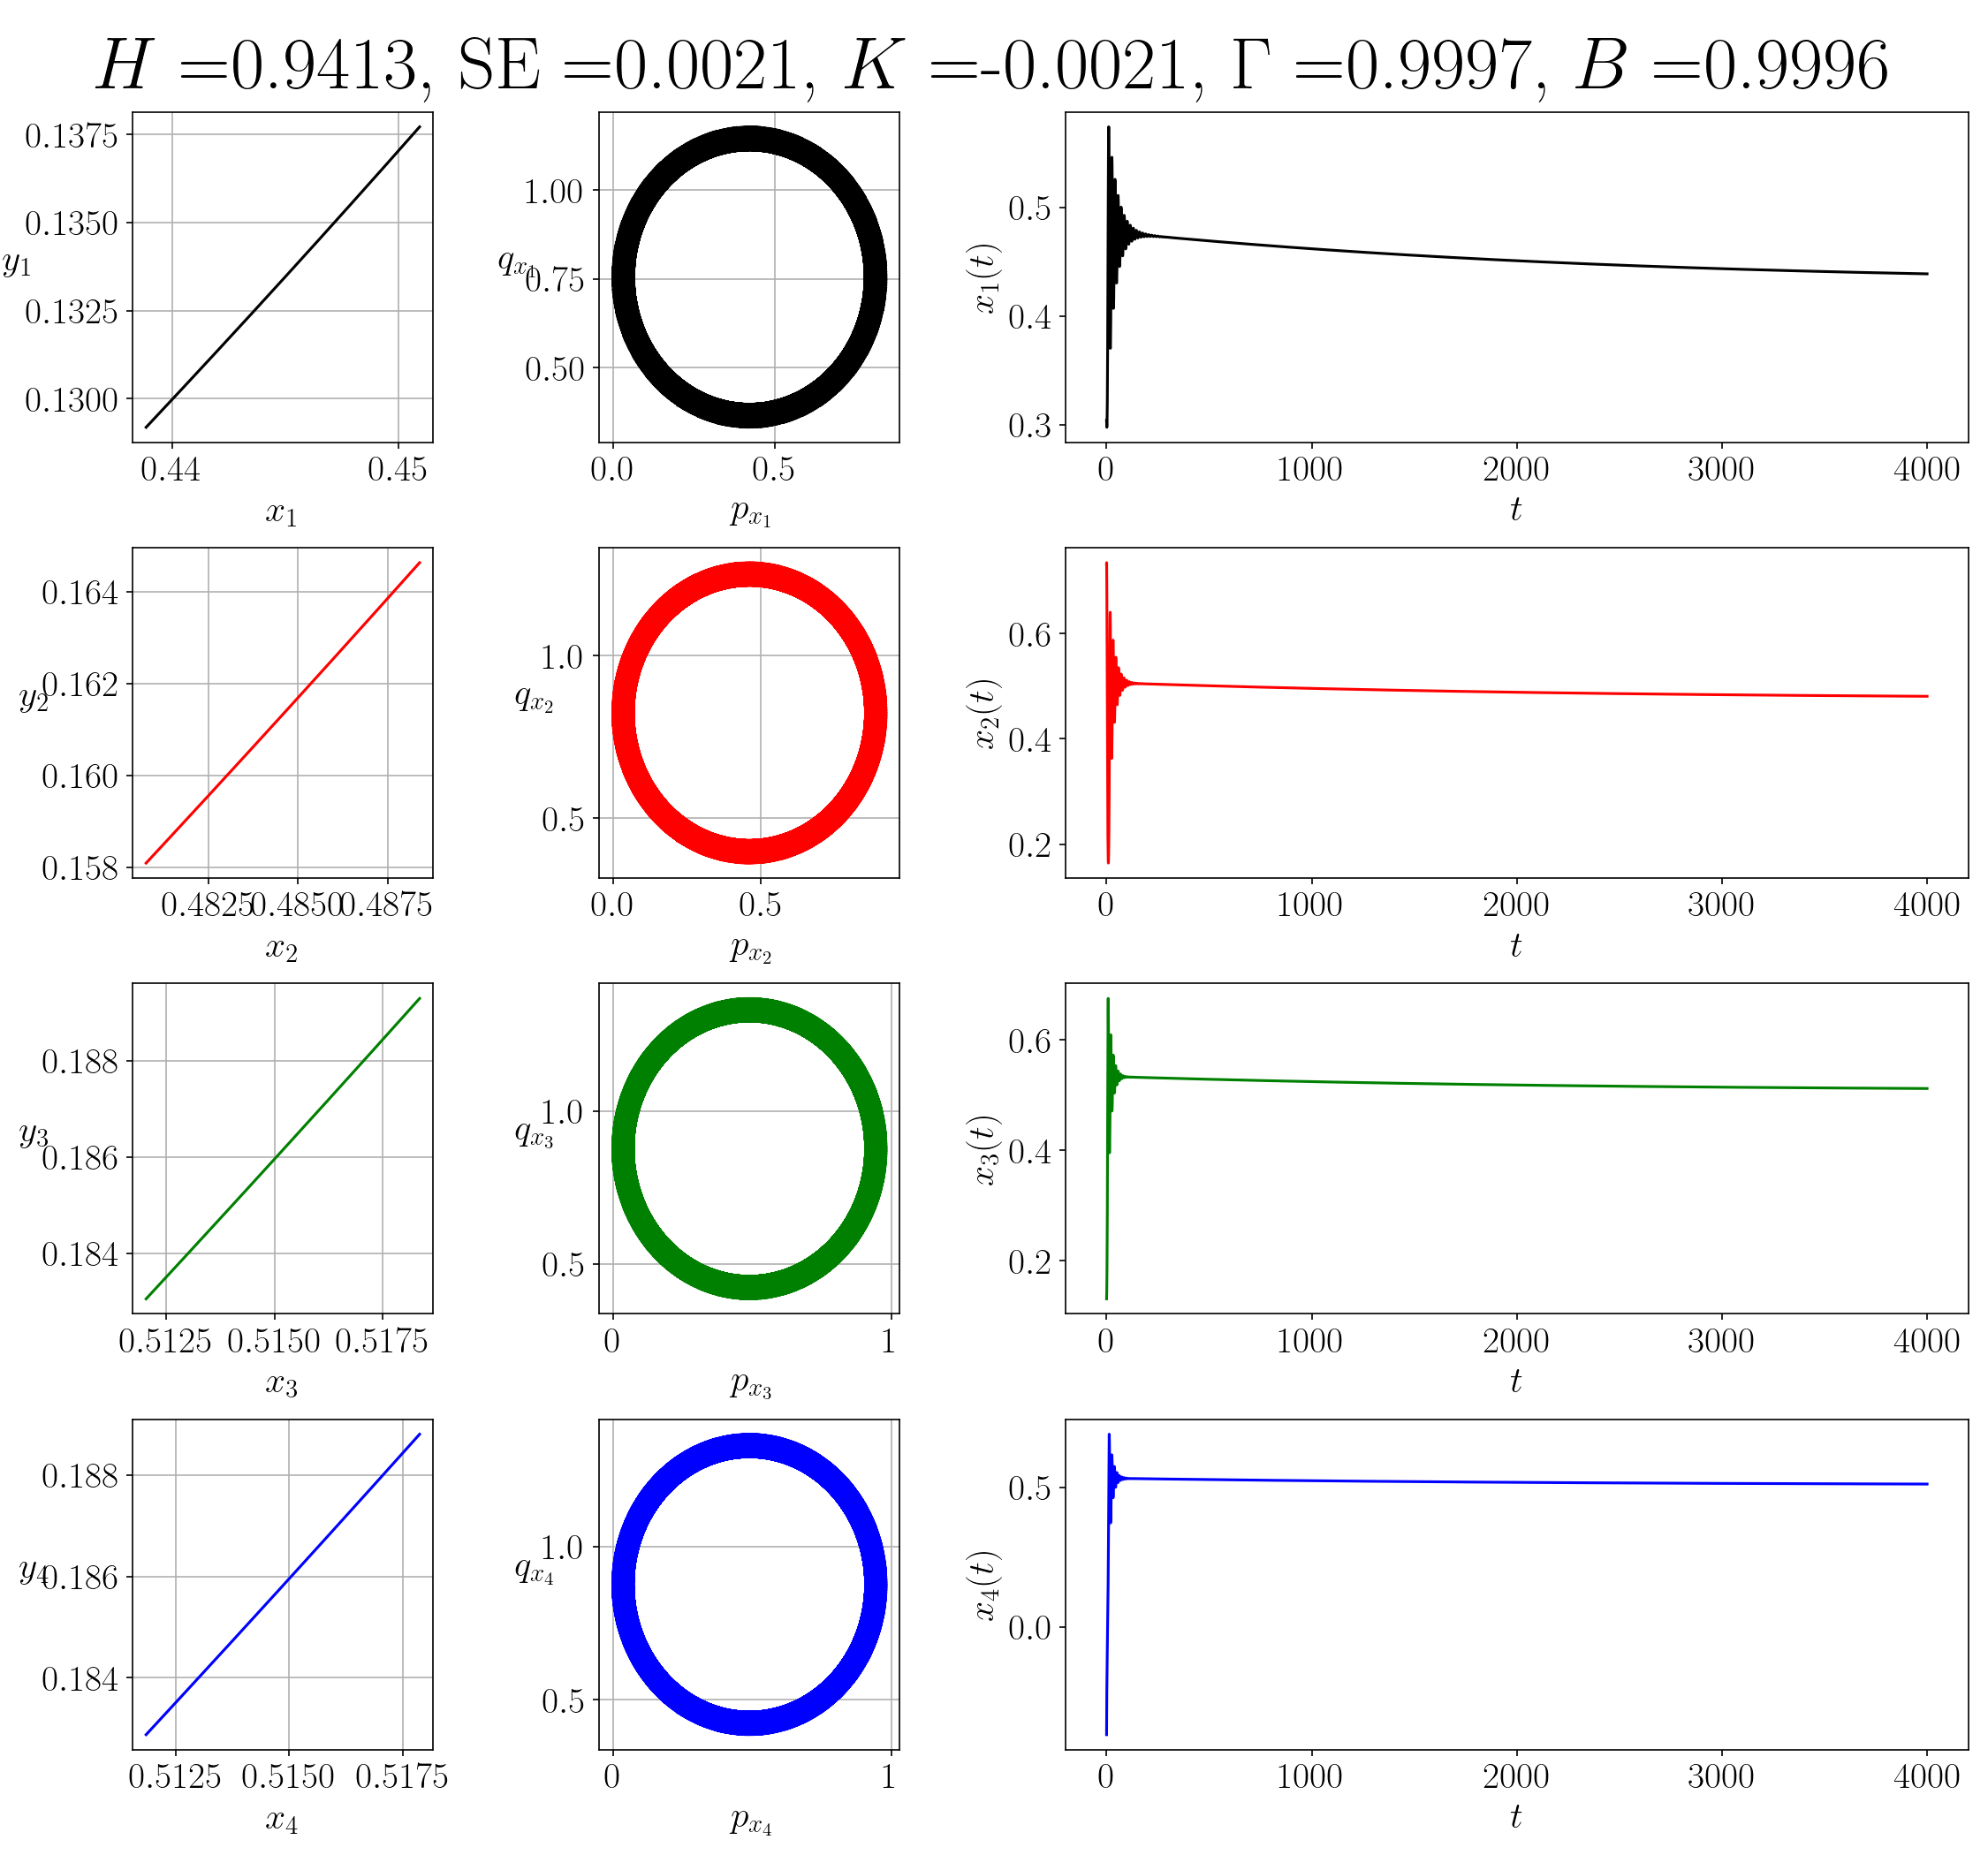

In [46]:
# theta = -0.01
# theta = -0.005
# theta = -0.001
# theta = 0.001
theta = 0.005
# theta = 0.01

x1_sol, y1_sol, x2_sol, y2_sol, x3_sol, y3_sol, x4_sol, y4_sol, tt, cc, KK1, KK2, KK3, KK4, Kuram, h1, h2, h3, h4, se1, se2, se3, se4, p_x1, q_x1, p_x2, q_x2, p_x3, q_x3, p_x4, q_x4 = bif_random_pp(theta)

# phi_x1, phi_y1, phi_x2, phi_y2, KK1, se1, KK2, se2, kuram = [0.1, 0.2], [0.1, 0.2], [.1, .65], [0.1, 0.8], 1, 1, 1, 1, 1

sz=20
%matplotlib notebook

fig, axs = plt.subplots(4, 3, figsize=(15, 14), gridspec_kw={'width_ratios': [1, 1, 3]})
fig.tight_layout()
plt.suptitle(
    "$H=$" + str(round((h1 + h2 + h3+ h4) / 4, 4)) +
    ", $\mathrm{SE}=$" + str(round((se1 + se2 + se3 + se4) / 4, 4)) +
    ", $K=$" + str(round((KK1 + KK2 + KK3+ KK4) / 2, 4)) +
    ", $\Gamma=$" + str(round(cc, 4)) +
    ", $B=$" + str(round(Kuram, 4)),
    size=sz +20
)

axs[0, 0].plot(x1_sol[5000:], y1_sol[5000:], 'k-', ms =1, rasterized=True)
# axs[0, 0].plot(phi_x1, phi_y1, 'bo', ms =5, rasterized=True)
axs[0, 0].set_xlabel('$x_1$', size=sz)
axs[0, 0].set_ylabel('$y_1$', rotation = False, size=sz)
axs[0, 0].tick_params(axis='both', labelsize=sz)
axs[0, 0].grid()

axs[1, 0].plot(x2_sol[5000:], y2_sol[5000:], 'r-', ms =1,  rasterized=True)
# axs[1, 0].plot(phi_x2, phi_y2, 'ro', ms =5,  rasterized=True)
axs[1, 0].set_xlabel('$x_2$', size=sz)
axs[1, 0].set_ylabel('$y_2$', rotation=False, size=sz)
axs[1, 0].tick_params(axis='both', labelsize=sz)
axs[1, 0].grid()

axs[2, 0].plot(x3_sol[5000:], y3_sol[5000:], 'g-', ms =1, rasterized=True)
# axs[0, 0].plot(phi_x1, phi_y1, 'bo', ms =5, rasterized=True)
axs[2, 0].set_xlabel('$x_3$', size=sz)
axs[2, 0].set_ylabel('$y_3$', rotation = False, size=sz)
axs[2, 0].tick_params(axis='both', labelsize=sz)
axs[2, 0].grid()

axs[3, 0].plot(x4_sol[5000:], y4_sol[5000:], 'b-', ms =1,  rasterized=True)
# axs[1, 0].plot(phi_x2, phi_y2, 'ro', ms =5,  rasterized=True)
axs[3, 0].set_xlabel('$x_4$', size=sz)
axs[3, 0].set_ylabel('$y_4$', rotation=False, size=sz)
axs[3, 0].tick_params(axis='both', labelsize=sz)
axs[3, 0].grid()

axs[0, 1].plot(p_x1, q_x1, 'k-', ms =1, rasterized=True)
axs[0, 1].set_xlabel('$p_{x_1}$', size=sz)
axs[0, 1].set_ylabel('$q_{x_1}$', rotation = False, size=sz)
axs[0, 1].tick_params(axis='both', labelsize=sz)
axs[0, 1].grid()

axs[1, 1].plot(p_x2, q_x2, 'r-', ms =1, rasterized=True)
axs[1, 1].set_xlabel('$p_{x_2}$', size=sz)
axs[1, 1].set_ylabel('$q_{x_2}$', rotation = False, size=sz)
axs[1, 1].tick_params(axis='both', labelsize=sz)
axs[1, 1].grid()

axs[2, 1].plot(p_x3, q_x3, 'g-', ms =1, rasterized=True)
axs[2, 1].set_xlabel('$p_{x_3}$', size=sz)
axs[2, 1].set_ylabel('$q_{x_3}$', rotation = False, size=sz)
axs[2, 1].tick_params(axis='both', labelsize=sz)
axs[2, 1].grid()

axs[3, 1].plot(p_x4, q_x4, 'b-', ms =1, rasterized=True)
axs[3, 1].set_xlabel('$p_{x_4}$', size=sz)
axs[3, 1].set_ylabel('$q_{x_4}$', rotation = False, size=sz)
axs[3, 1].tick_params(axis='both', labelsize=sz)
axs[3, 1].grid()

axs[0, 2].plot(tt, x1_sol, 'k-', ms=1, rasterized=True)
axs[0, 2].set_ylabel('$x_1(t)$', size=sz)
axs[0, 2].set_xlabel('$t$', size=sz)
axs[0, 2].tick_params(axis='both', labelsize=sz)

axs[1, 2].plot(tt, x2_sol, 'r-', ms=1, rasterized=True)
axs[1, 2].set_ylabel('$x_2(t)$', size=sz)
axs[1, 2].set_xlabel('$t$', size=sz)
axs[1, 2].tick_params(axis='both', labelsize=sz)

axs[2, 2].plot(tt, x3_sol, 'g-', ms=1, rasterized=True)
axs[2, 2].set_ylabel('$x_3(t)$', size=sz)
axs[2, 2].set_xlabel('$t$', size=sz)
axs[2, 2].tick_params(axis='both', labelsize=sz)

axs[3, 2].plot(tt, x4_sol, 'b-', ms=1, rasterized=True)
axs[3, 2].set_ylabel('$x_4(t)$', size=sz)
axs[3, 2].set_xlabel('$t$', size=sz)
axs[3, 2].tick_params(axis='both', labelsize=sz)

plt.tight_layout()

In [47]:
def bif_random(theta):
    N = 4
    AA = np.random.randint(0, 2, size=(N, N))

    print("adjacency matrix = ")
    print(AA)

    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005

    vs = 2
    lamb = 10
    q=-0.25

    def dML(t, vars):
        x, y, I = vars
        dxdt = x**2 * (1 - x) - y + I
        dydt = A * np.exp(alpha * x) - gamma * y
        dIdt = epsilon*(1/60*(1+np.tanh((0.05-x)/0.001)) - I)
        return [dxdt, dydt, dIdt]

    ## Initialize states for each node
    SS = np.ones((N, 3))
    SS[:, 0] = np.random.uniform(low=-1, high=1, size = N)
    SS[:, 1] = SS[:, 1] * 0.1
    SS[:, 2] = np.random.uniform(low=0.019, high=0.022, size = N)

    dt = 0.4   # Time step
    T = 4000      # Total simulation time
    stepNum = int(T / dt)

    trajectories = np.zeros((stepNum, N, 3))

    for i in range(stepNum):
        newState = np.zeros((N, 3))
        for k in range(N):
            xCoup = 0

            tSpan = (0, dt)
            sol = solve_ivp(dML, tSpan, SS[k], t_eval=[dt], method='RK45')

            currentState = sol.y[:, -1]

            for j in range(N):
                xCoup = xCoup + theta*AA[k, j]*(vs-SS[k, 0])/(1+np.exp(-lamb*SS[j, 0]-q))

            currentState[0] = currentState[0] + xCoup
            currentState[1] = currentState[1]
            currentState[2] = currentState[2]

            newState[k] = currentState

        SS = newState
        trajectories[i] = SS

    ## Extract solutions
    x1_sol = trajectories[:, 0, 0]
    y1_sol = trajectories[:, 0, 1]
    I1_sol = trajectories[:, 0, 2]

    x2_sol = trajectories[:, 1, 0]
    y2_sol = trajectories[:, 1, 1]
    I2_sol = trajectories[:, 1, 2]

    x3_sol = trajectories[:, 2, 0]
    y3_sol = trajectories[:, 2, 1]
    I3_sol = trajectories[:, 2, 2]

    x4_sol = trajectories[:, 3, 0]
    y4_sol = trajectories[:, 3, 1]
    I4_sol = trajectories[:, 3, 2]

    tt = np.arange(int(4000/.4))*0.4
    
    ## cross-correlation coeff
    phi_x1 = np.array(x1_sol[500:])
    phi_x2 = np.array(x2_sol[500:])
    phi_x3 = np.array(x3_sol[500:])
    phi_x4 = np.array(x4_sol[500:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)
    x3_tilde = phi_x3 - np.mean(phi_x3)
    x4_tilde = phi_x4 - np.mean(phi_x4) 
    
    Numerator2 = np.mean(x1_tilde*x2_tilde)
    Denominator2 = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    Numerator3 = np.mean(x1_tilde*x3_tilde)
    Denominator3 = np.sqrt(np.mean(x1_tilde**2)*np.mean(x3_tilde**2))
    
    Numerator4 = np.mean(x1_tilde*x4_tilde)
    Denominator4 = np.sqrt(np.mean(x1_tilde**2)*np.mean(x4_tilde**2))
    
    cc = (Numerator2/Denominator2 + Numerator3/Denominator3+ Numerator4/Denominator4)/3
    print("cc =",cc)
    
    ## Kuramoto order parameter
    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)
    l3 = np.arctan(y3_sol/x3_sol)
    l4 = np.arctan(y4_sol/x4_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Ind3 = np.exp(1j*l3)
    Ind4 = np.exp(1j*l4)
    Indt = np.abs(1/4*(Ind1+Ind2+Ind3+Ind4))
    Kuram = np.mean(Indt)
    print("Kuram =",Kuram)
    
    
    ## 0-1 test
    
    def pq(phi, c):
        imax = len(phi)
        p = np.zeros(imax)
        q = np.zeros(imax)
        p[0] = phi[0] * np.cos(c)
        q[0] = phi[0] * np.sin(c)
        for i in range(1, imax):
            p[i] = p[i-1] + phi[i-1]*np.cos(c * (i-1))
            q[i] = q[i-1] + phi[i-1]*np.sin(c * (i-1))
        return p,q
    
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    c = 1.1
    ncut2 = 80

    phi_x1 = x1_sol[8000:]
    phi_y1 = y1_sol[8000:]
    phi_x2 = x2_sol[8000:]
    phi_y2 = y2_sol[8000:]
    phi_x3 = x3_sol[8000:]
    phi_y3 = y3_sol[8000:]
    phi_x4 = x4_sol[8000:]
    phi_y4 = y4_sol[8000:]
    print("length = ", len(phi_x1))

    KK1 = regression_method(phi_x1, ncut2)
    KK2 = regression_method(phi_x2, ncut2)
    KK3 = regression_method(phi_x3, ncut2)
    KK4 = regression_method(phi_x4, ncut2)
    print("KK =",(KK1+KK2+KK3+KK4)/4)
    
    return x1_sol, y1_sol, x2_sol, y2_sol, x3_sol, y3_sol, x4_sol, y4_sol, tt, cc, KK1, KK2, KK3, KK4, Kuram, nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.hurst_rs(x3_sol), nd.hurst_rs(x4_sol), nd.sampen(x1_sol), nd.sampen(x2_sol), nd.sampen(x3_sol), nd.sampen(x4_sol)

In [ ]:
SS = np.linspace(-.01, .01, 50)

count = 1
HH=[]
SE=[]
KKTest = []
CC = []
Kuramoto = []
for theta in SS:
    print("count = "+str(count))
    x1_sol, y1_sol, x2_sol, y2_sol, x3_sol, y3_sol, x4_sol, y4_sol, tt, cc, KK1, KK2, KK3, KK4, Kuram, h1, h2, h3, h4, se1, se2, se3, se4 = bif_random(theta)
    HH+=[(h1+h2+h3+h4)/4, ]
    SE+=[(se1+se2+se3+se4)/4, ]
    CC+=[cc, ]
    KKTest+=[(KK1+KK2+KK3+KK4)/4, ]
    Kuramoto+=[Kuram, ]
    
    print("H=", (h1+h2+h3+h4)/4)
    print("SE=", (se1+se2+se3+se4)/4)
    print(" ")

    count+=1

df = pd.DataFrame({
    'theta': SS,
    'H': HH,
    'SE': SE,
    'CC': CC,
    'KK': KKTest,
    'Kuramoto': Kuramoto
})

df.to_csv('data_random.csv', index=False)

In [48]:
dfRandom = pd.read_csv('data_random.csv')
dfRandom

theta         H        SE        CC        KK  Kuramoto
0  -0.010000  0.808819  0.011466  0.344293  0.012955  0.980190
1  -0.009592  0.769986  0.031835 -0.149697  0.038264  0.943567
2  -0.009184  0.947535  0.000804  0.724376 -0.000131  0.974404
3  -0.008776  0.704615  0.030099 -0.231108  0.023594  0.970055
4  -0.008367  0.950329  0.000050  0.864594 -0.000067  0.938131
5  -0.007959  0.948167  0.000114  0.002938 -0.000083  0.996909
6  -0.007551  0.928955  0.001194  0.344188  0.000046  0.966788
7  -0.007143  0.949189  0.000085  0.999374 -0.000137  0.995951
8  -0.006735  0.950364  0.004549  0.437198  0.000023  0.943156
9  -0.006327  0.907226  0.001824  0.010871  0.000345  0.927869
10 -0.005918  0.947153  0.003844  0.386349 -0.000061  0.954286
11 -0.005510  0.736757  0.011988 -0.692291  0.019634  0.964250
12 -0.005102  0.948631  0.000034  0.987998 -0.000049  0.928375
13 -0.004694  0.786614  0.021199 -0.893087  0.014858  0.976388
14 -0.004286  0.855021  0.005141  0.026658 -0.000074  0.939616
15 -0.003878  0.937435  0.009443 -0.286234  0.030043  0.905434
16 -0.003469  0.947737  0.003885  0.660844  0.000509  0.904774
17 -0.003061  0.945373  0.000598  0.921380 -0.000098  0.900835
18 -0.002653  0.950293  0.000220  0.857404 -0.000033  0.901292
19 -0.002245  0.948097  0.000129  0.993462  0.000208  0.869442
20 -0.001837  0.766024  0.008971 -0.364706  0.035210  0.877644
21 -0.001429  0.763862  0.010615 -0.316503  0.034635  0.862328
22 -0.001020  0.715627  0.032792 -0.250655  0.041629  0.927496
23 -0.000612  0.682935  0.051333  0.019162  0.069143  0.925638
24 -0.000204  0.665921  0.059590  0.263625  0.051129  0.914989
25  0.000204  0.428534  0.057398  0.425005  0.025801  0.960965
26  0.000612  0.581958  0.040087  0.650615  0.037726  0.974905
27  0.001020  0.806412  0.010846  0.899817  0.006921  0.991795
28  0.001429  0.903374  0.008533  0.981277 -0.001932  0.999491
29  0.001837  0.916754  0.006810  0.988595 -0.001875  0.999509
30  0.002245  0.928977  0.004601  0.998374 -0.001542  0.999680
31  0.002653  0.933181  0.003831  0.996969 -0.001387  0.999479
32  0.003061  0.934071  0.003575  0.999352 -0.001357  0.999378
33  0.003469  0.938775  0.002936  0.999614 -0.001273  0.999406
34  0.003878  0.943127  0.001926  0.999992 -0.001038  0.999536
35  0.004286  0.938210  0.002927  0.999573 -0.001216  0.999341
36  0.004694  0.936652  0.003068  0.999559 -0.001151  0.999364
37  0.005102  0.944460  0.001781  0.999988 -0.000947  0.999566
38  0.005510  0.942101  0.002217  0.999935 -0.001104  0.999539
39  0.005918  0.853441  0.021187  0.823374  0.015847  0.979706
40  0.006327  0.940305  0.002422  0.999915 -0.001109  0.999606
41  0.006735  0.944018  0.001619  0.999911 -0.000884  0.999282
42  0.007143  0.943178  0.002039  0.999891 -0.001044  0.999060
43  0.007551  0.947700  0.001183  0.999984 -0.000773  0.999328
44  0.007959  0.741823  0.029705  0.609337  0.022145  0.978036
45  0.008367  0.946562  0.001006  0.999989 -0.000732  0.999778
46  0.008776  0.945354  0.001801  0.999957 -0.000942  0.999400
47  0.009184  0.944770  0.001772  0.999955 -0.000909  0.999425
48  0.009592  0.947630  0.000863  0.999992 -0.000661  0.999507
49  0.010000  0.797744  0.023150  0.716722  0.019289  0.977869

<IPython.core.display.Javascript object>


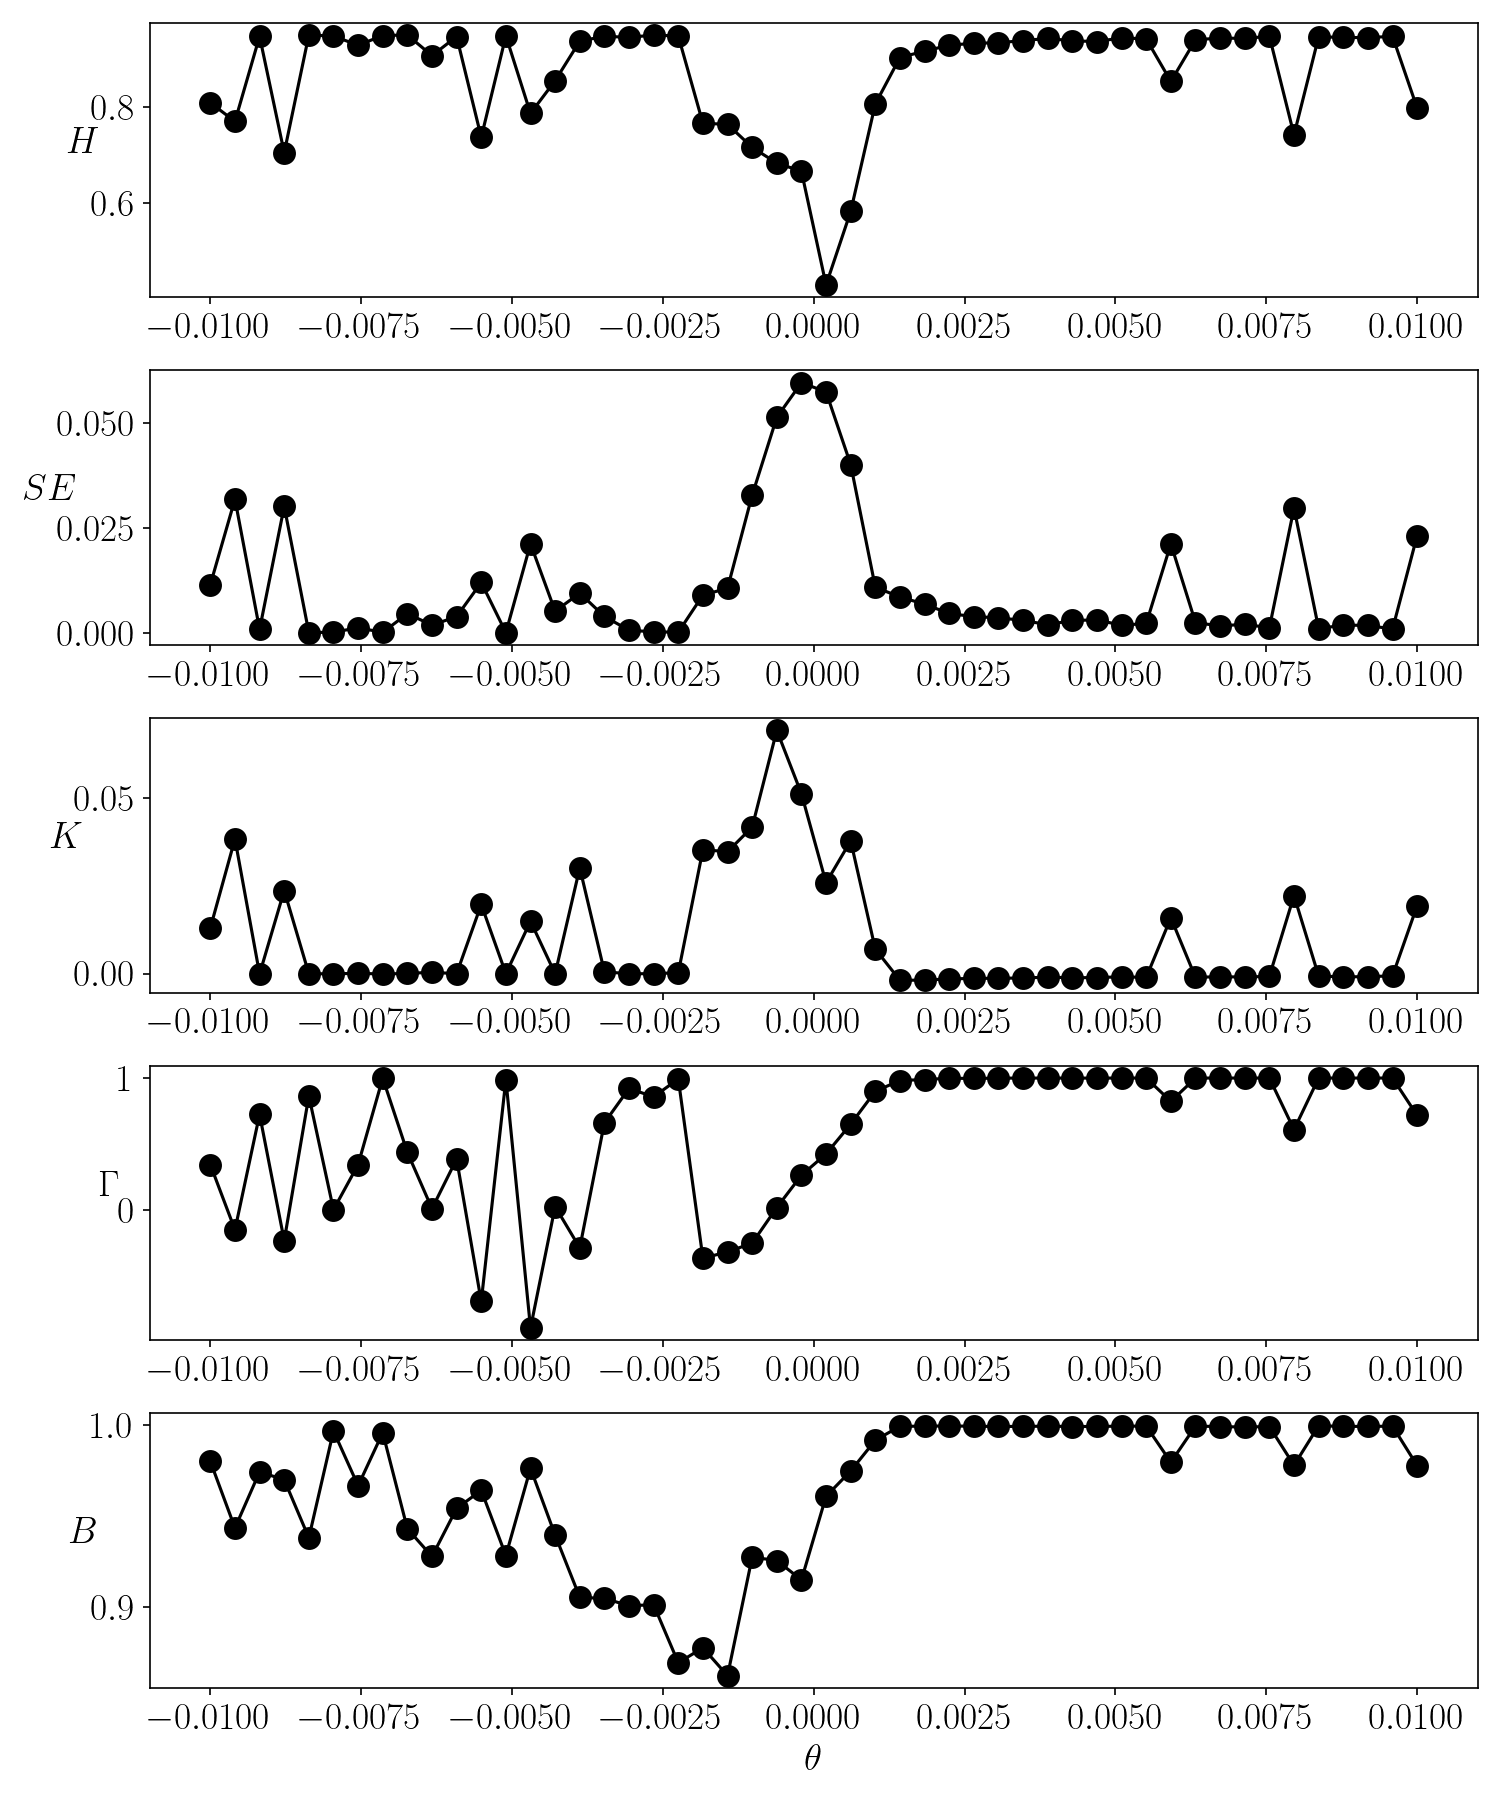

In [49]:
sz=18
%matplotlib notebook
matplotlib.rc('xtick', labelsize=sz)
matplotlib.rc('ytick', labelsize=sz)

SS = np.linspace(-.01, .01, 50)

fig, axs = plt.subplots(5,1, figsize=(10, 12))

axs[0].set_ylabel('$H$',rotation=False, fontsize=sz)
axs[1].set_ylabel('$SE$',rotation=False, fontsize=sz)
axs[2].set_ylabel('$K$',rotation=False, fontsize=sz)
axs[3].set_ylabel('$\\Gamma$',rotation=False, fontsize=sz)
axs[4].set_ylabel('$B$',rotation=False, fontsize=sz)
axs[4].set_xlabel('$\\theta$', fontsize=sz)

HH = dfRandom['H']
SE = dfRandom['SE']
KKTest = dfRandom['KK']
CC = dfRandom['CC']
Kuramoto = dfRandom['Kuramoto']

axs[0].plot(SS, HH, 'ko-', ms=10)
axs[1].plot(SS, SE, 'ko-', ms=10)
axs[2].plot(SS, KKTest, 'ko-', ms=10)
axs[3].plot(SS, CC, 'ko-', ms=10)
axs[4].plot(SS, Kuramoto, 'ko-', ms=10)

plt.tight_layout()

## Granger's causality test

In [50]:
## import the required package
from statsmodels.tsa.stattools import grangercausalitytests

### Josephson junction coupling

In [51]:
A = 0.0041
alpha=5.276
gamma = 0.315
epsilon = 0.0005

beta = 3
theta = 1 # in  (-1, 1)
mu = 3
print("theta=", theta)

def system(t, vars):
    x1, y1, I1, x2, y2, I2, z= vars
    dx1dt = x1**2 * (1 - x1) - y1 + I1-beta*np.sin(z) + theta*(x2 - x1)
    dy1dt = A * np.exp(alpha * x1) - gamma * y1
    dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
    dx2dt = x2**2 * (1 - x2) - y2 + I2 + beta*np.sin(z) + theta*(x1 - x2)
    dy2dt = A * np.exp(alpha * x2) - gamma * y2
    dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)
    dzdt = mu*(x1-x2)

    return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt, dzdt]

x1_0 = np.random.uniform(low=-1, high=1)
y1_0 = 0.1
I1_0 = 0.018

x2_0 = np.random.uniform(low=-1, high=1)
y2_0 = .1
I2_0 = 0.022

z_0 = mu*(x1_0 - x2_0)
print(x1_0, x2_0)


initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0, z_0]

t_span = (0, 4000)
t_eval = np.linspace(t_span[0], t_span[1], 50000)

solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

x1_sol = solution.y[0]
y1_sol = solution.y[1]
I1_sol = solution.y[2]

x2_sol = solution.y[3]
y2_sol = solution.y[4]
I2_sol = solution.y[5]


tt = solution.t

print("done")

theta= 1
-0.6263957567029381 -0.8308926873853462
done


In [52]:
## Test Granger's causality
df = pd.DataFrame({'Y': x2_sol, 'X': x1_sol})
grangercausalitytests(df, maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=94.5608 , p=0.0000  , df_denom=49996, df_num=1
ssr based chi2 test:   chi2=94.5665 , p=0.0000  , df=1
likelihood ratio test: chi2=94.4772 , p=0.0000  , df=1
parameter F test:         F=94.5608 , p=0.0000  , df_denom=49996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=412784.8214, p=0.0000  , df_denom=49993, df_num=2
ssr based chi2 test:   chi2=825652.2114, p=0.0000  , df=2
likelihood ratio test: chi2=143143.4593, p=0.0000  , df=2
parameter F test:         F=412784.8214, p=0.0000  , df_denom=49993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=337580.9666, p=0.0000  , df_denom=49990, df_num=3
ssr based chi2 test:   chi2=1012884.7121, p=0.0000  , df=3
likelihood ratio test: chi2=152829.6342, p=0.0000  , df=3
parameter F test:         F=337580.9666, p=0.0000  , df_denom=49990, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F

{1: ({'ssr_ftest': (94.56084320061917, 2.487614921586979e-22, 49996.0, 1),
   'ssr_chi2test': (94.56651730513958, 2.3699330678743727e-22, 1),
   'lrtest': (94.47719985840376, 2.4793176982408536e-22, 1),
   'params_ftest': (94.56084320058413, 2.4876149216363647e-22, 49996.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (412784.82143893646, 0.0, 49993.0, 2),
   'ssr_chi2test': (825652.2114017542, 0.0, 2),
   'lrtest': (143143.45925824996, 0.0, 2),
   'params_ftest': (412784.82143893593, 0.0, 49993.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (337580.96658142324, 0.0, 49990.0, 3),
   'ssr_chi2test': (1012884.7121127076, 0.0, 3),
   'lrtest': (152829.63422730914, 0.0, 3),
   'params_ftest': (337580.96658254415, 0.0, 49990.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])]),
 4: ({'ssr_ftest': (130891.81695378326, 0.0, 49987.0, 4),
   'ssr_chi2test': 

### Memristive coupling

In [53]:
A = 0.0041
alpha=5.276
gamma = 0.315
epsilon = 0.0005

alpha = 10
beta = 5

theta = -0.01

print("theta=", theta)
def rho(p): return alpha + 3*beta*p**2

def system(t, vars):
    x1, y1, I1, x2, y2, I2, p= vars
    dx1dt = x1**2 * (1 - x1) - y1 + I1 + theta*rho(p)*(x2 - x1)
    dy1dt = A * np.exp(alpha * x1) - gamma * y1
    dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
    dx2dt = x2**2 * (1 - x2) - y2 + I2 + theta*rho(p)*(x1 - x2)
    dy2dt = A * np.exp(alpha * x2) - gamma * y2
    dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)
    dpdt = theta*(x1-x2)

    return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt, dpdt]

# Initial conditions
x1_0 = np.random.uniform(low=-1, high=1)
y1_0 = 0.1
I1_0 = 0.018

x2_0 = np.random.uniform(low=-1, high=1)
y2_0 = .1
I2_0 = 0.022

p_0 = theta*(x1_0 - x2_0)
print(x1_0, x2_0)


initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0, p_0]


t_span = (0, 4000)
t_eval = np.linspace(t_span[0], t_span[1], 50000)

solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

x1_sol = solution.y[0]
y1_sol = solution.y[1]
I1_sol = solution.y[2]

x2_sol = solution.y[3]
y2_sol = solution.y[4]
I2_sol = solution.y[5]


tt = solution.t

print("done")

theta= -0.01
-0.92439937164265 -0.8924566768547837
done


In [54]:
df = pd.DataFrame({'Y': x2_sol, 'X': x1_sol})

grangercausalitytests(df, maxlag=5, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=30.6595 , p=0.0000  , df_denom=49996, df_num=1
ssr based chi2 test:   chi2=30.6613 , p=0.0000  , df=1
likelihood ratio test: chi2=30.6519 , p=0.0000  , df=1
parameter F test:         F=30.6595 , p=0.0000  , df_denom=49996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1876.4254, p=0.0000  , df_denom=49993, df_num=2
ssr based chi2 test:   chi2=3753.2261, p=0.0000  , df=2
likelihood ratio test: chi2=3619.0289, p=0.0000  , df=2
parameter F test:         F=1876.4254, p=0.0000  , df_denom=49993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=22708.7995, p=0.0000  , df_denom=49990, df_num=3
ssr based chi2 test:   chi2=68135.9380, p=0.0000  , df=3
likelihood ratio test: chi2=42989.7995, p=0.0000  , df=3
parameter F test:         F=22708.7995, p=0.0000  , df_denom=49990, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:       

{1: ({'ssr_ftest': (30.6594697041482, 3.090638308214156e-08, 49996.0, 1),
   'ssr_chi2test': (30.661309419507678, 3.072306062389087e-08, 1),
   'lrtest': (30.651911914232187, 3.0872224128434135e-08, 1),
   'params_ftest': (30.65946970415555, 3.090638308207942e-08, 49996.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1876.4253588724218, 0.0, 49993.0, 2),
   'ssr_chi2test': (3753.2260553638853, 0.0, 2),
   'lrtest': (3619.028855647426, 0.0, 2),
   'params_ftest': (1876.425358874396, 0.0, 49993.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (22708.799473112987, 0.0, 49990.0, 3),
   'ssr_chi2test': (68135.93802303841, 0.0, 3),
   'lrtest': (42989.799463411444, 0.0, 3),
   'params_ftest': (22708.799474544823, 0.0, 49990.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])]),
 4: ({'ssr_ftest': (1416.1145120271572, 0.0, 49987.0, 4),
   'ssr_chi2test': (56